**Strava EDA: Colorado Hike #1**

Belford, Oxford, and Missouri Mountains (Day Hike)

![](https://i.imgur.com/W9kvrYa.jpg)

*Step 1: Import Packages*

In [1]:
import pandas as pd
import numpy as np
import gpxpy # install in settings menu
import json
import matplotlib.pyplot as plt
import time
from IPython import display
from xml.dom import minidom
import math  
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from xml.etree import ElementTree as ET
import IPython
# print(os.listdir('../input/'))
# print(os.listdir('../input/ptm strava data/'))
# print(os.listdir('../input/ptm strava data/PTM Strava Data/'))
# print(os.listdir('../input/ptm strava data/PTM Strava Data/hike'))

*Step 2: Visualize Data in 2D*

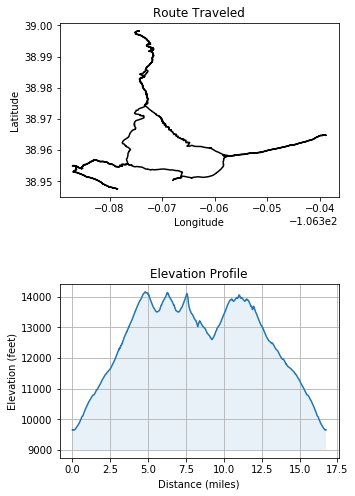

In [2]:
#READ GPX FILE
CollegiatePeaks = '../input/ptm strava data/PTM Strava Data/hike/Colorado_Belford_Oxford_and_Missouri_Mountains_Hike.gpx'
data=open(CollegiatePeaks)
xmldoc = minidom.parse(data)
track = xmldoc.getElementsByTagName('trkpt')
elevation=xmldoc.getElementsByTagName('ele')
datetime=xmldoc.getElementsByTagName('time')
n_track=len(track)
#PARSING GPX ELEMENT
lon_list=[]
lat_list=[]
h_list=[]
time_list=[]
for s in range(n_track):
    lon,lat=track[s].attributes['lon'].value,track[s].attributes['lat'].value
    elev=elevation[s].firstChild.nodeValue
    lon_list.append(float(lon))
    lat_list.append(float(lat))
    h_list.append(float(elev)*3.28084) # convert meters to feet
    # PARSING TIME ELEMENT
    dt=datetime[s].firstChild.nodeValue
    time_split=dt.split('T')
    hms_split=time_split[1].split(':')
    time_hour=int(hms_split[0])
    time_minute=int(hms_split[1])
    time_second=int(hms_split[2].split('Z')[0])
    total_second=time_hour*3600+time_minute*60+time_second
    time_list.append(total_second)
#GEODETIC TO CARTERSIAN FUNCTION
def geo2cart(lon,lat,h):
    a=6378137 #WGS 84 Major axis
    b=6356752.3142 #WGS 84 Minor axis
    e2=1-(b**2/a**2)
    N=float(a/math.sqrt(1-e2*(math.sin(math.radians(abs(lat)))**2)))
    X=(N+h)*math.cos(math.radians(lat))*math.cos(math.radians(lon))
    Y=(N+h)*math.cos(math.radians(lat))*math.sin(math.radians(lon))
    return X,Y
#DISTANCE FUNCTION
def distance(x1,y1,x2,y2):
    d=math.sqrt((x1-x2)**2+(y1-y2)**2)
    d=d/1609.34 # convert meters to miles
    return d
#POPULATE DISTANCE LIST
d_list=[0.0]
l=0
for k in range(n_track-1):
    if k<(n_track-1):
        l=k+1
    else:
        l=k
    XY0=geo2cart(lon_list[k],lat_list[k],h_list[k])
    XY1=geo2cart(lon_list[l],lat_list[l],h_list[l])   
    #DISTANCE
    d=distance(XY0[0],XY0[1],XY1[0],XY1[1])
    sum_d=d+d_list[-1]
    d_list.append(sum_d)
#PLOT TRACK
f,(track,elevation)=plt.subplots(2,1)
f.set_figheight(8)
f.set_figwidth(5)
plt.subplots_adjust(hspace=0.5)
track.plot(lon_list,lat_list,'k')
track.set_ylabel("Latitude")
track.set_xlabel("Longitude")
track.set_title("Route Traveled")
#PLOT ELEVATION PROFILE
base_reg=9000
elevation.plot(d_list,h_list)
elevation.fill_between(d_list,h_list,base_reg,alpha=0.1)
elevation.set_title("Elevation Profile")
elevation.set_xlabel("Distance (miles)")
elevation.set_ylabel("Elevation (feet)")
elevation.grid()

*Step 3: Visualize Data in 3D*

In [3]:
CollegiatePeaks = '../input/ptm strava data/PTM Strava Data/hike/Colorado_Belford_Oxford_and_Missouri_Mountains_Hike.gpx'
gpx_file = open(CollegiatePeaks, 'r')
gpx = gpxpy.parse(gpx_file)

def parse_gpx(gpx_input_file):
    
    lats = []
    lons = []
    elevations = []
    timestamps = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lats.append(point.latitude)
                lons.append(point.longitude)
                elevations.append(point.elevation)
                timestamps.append(point.time)
                   
    output = pd.DataFrame()
    output['latitude'] = lats
    output['longitude'] = lons
    output['elevation'] = elevations
    output['starttime'] = timestamps
    output['stoptime'] = output['starttime'].shift(-1).fillna(method='ffill')
    output['duration'] = (output['stoptime'] - output['starttime']) / np.timedelta64(1, 's') ## duration to seconds
    
    return output
df = parse_gpx(gpx)
#df.head()

def create_czml_path(df_input, relative_elevation = False):
    results = []
    
    timestep = 0
    
    for i in df_input.index:
        results.append(timestep)
        results.append(df_input.longitude.ix[i])
        results.append(df_input.latitude.ix[i])
        
        if relative_elevation == True:
            results.append(30) # for use with point = {"heightReference" : "RELATIVE_TO_GROUND"}
        else:
            results.append(df_input.elevation.ix[i])
        
        duration = df_input.duration.ix[(i)]
        timestep += duration
        
    return results
#create_czml_path(df)[:12]

def point_with_trailing_path(df_input, time_multiplier = 1000):  
    # Store output in array
    czml_output = []
    # Define global variables
    global_id = "document"
    global_name = "Visualizing GPX Data from Strava"
    global_version = "1.0"
    global_author = "Will Geary"
    global_starttime = str(min(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    global_stoptime = str(max(df_input['stoptime'])).replace(" ", "T").replace(".000", "Z")
    global_availability = global_starttime + "/" + global_stoptime    
    # Create packet with global variables
    global_element = {
        "id" : global_id,
        "name" : global_name,
        "version" : global_version,
        "author": global_author,
        "clock": {
            "interval": global_availability,
            "currentTime": global_starttime,
            "multiplier": time_multiplier
        }
    }
    # Append global packet to output
    czml_output.append(global_element)
    # Define path variables
    path_id = "path"
    path_starttime = str(min(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    path_stoptime = str(max(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    path_availability = path_starttime + "/" + path_stoptime
    # Create path object
    path_object = {
            "id": path_id,
            "availability": path_availability,
            "position": {
                "epoch": path_starttime,
                "cartographicDegrees": create_czml_path(df, relative_elevation=False)
            },
            "path" : {
                "material" : {
                    "polylineOutline" : {
                        "color" : {
                            "rgba" : [255,255,255, 200]
                        },
                        "outlineColor" : {
                            "rgba" : [0,173,253, 200]
                        },
                        "outlineWidth" : 5
                    }
                },
                "width" : 6,
                "leadTime" : 0,
                "trailTime" : 100000,
                "resolution" : 5
            }
        }
    # Append path element to output
    czml_output.append(path_object)        
    # Define point variable
    point_id = "Point"
    point_starttime = str(min(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    point_stoptime = str(max(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    point_availability = point_starttime + "/" + point_stoptime    
    point_object = {
            "id": point_id,
            "availability": point_availability,
            "position": {
                "epoch": point_starttime,
                "cartographicDegrees": create_czml_path(df, relative_elevation=True)
            },
            "point": {
                "color": {
                    "rgba": [255, 255, 255, 255]
                },
                "outlineColor": {
                    "rgba": [0,173,253, 255]
                },
                "outlineWidth":6,
                "pixelSize":8,
                "heightReference" : "RELATIVE_TO_GROUND"
            }   
        }
    czml_output.append(point_object)   
    return czml_output
czml_output = point_with_trailing_path(df)
with open('StravaData.czml', 'w') as outfile:
    json.dump(czml_output, outfile)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: 
.ix is deprecated. Please use
.loc for la

In [4]:
url= 'https://cesiumjs.org/Cesium/Apps/Sandcastle/index.html#c=nP3bzm5Ljh2IvUpC15Ic54MA3zXQtwbcsA20btLVZSnhkkpIlQR0G/3uJjk4yRhf5oYbRiVqr7X+8UfMiGAweOZ///Nf//QP/9t/+qc//Z//9D//f/79v/rL//Lv/9W/+9O//1f/yz//w3/7T//4n//l3/+rfy1/+89//k//iH//v/3lv/63P//TX/63v/zn//Cn//H/8v/40//w53/585/+X3/95//0p//rv/z1z//9z8D/93/863/9yz//Z/xK/bcF//rn//Yv//Gf/4p//L//5Z/+6U//4z/++a//K372D//0z//w/9Yf6Tf853/5x7/+9z//E5Ct1P1vyv039fxPtf67Mv9dPf+n599a/3f9/rs6fZj/9te/ylf/T3/5vvfv/DaQ/+m//dO//OW//NNf/tE+qJZS/vf//V//6dmB//Lnf/mP/t3//c9/+ac//z//8k9/+Zf/9f+Pb/ov//xf//Ivvhsy/j/+l3/+h//4/+Pj/uHPf/2Xf/4Pf/3zf/mPf/mH/+Ef/8Nf//Ef/6v+xv9c/vWf/k0t69/2Pcas//pP/fzbe08961//qd3R/u2U/7Z/+6LaDtQ6jpJfnP1Fyf8+VCvdUfLfUwl1bs74oGrlKXPCnK/OQUPdHqi9HSa/2ErhGVfA7skZW980Y5k5585J2+YPm3/zZU3+pfQ/mvJdZO+TYScXsB7Y+vmyHG0929Hv/KMF7Jqw0RjW8sg7tqP+W/nv4M0dswVstFzprAyreZy7PaQx6NRHz2+bLwWt+n9otFN4CQ8N3Tz4Vfjbyvj7sHZ50mffzgObi2AjD2vN3JDF9C3D/S1RCnwXhpXc3tVzpbudPyLxNvOw9vo5hYT1+8DuHx7W7blS+RsvIe7xxmDdUINv3+p/ux/y8zPPHx3Cfg7hbP60vv/2EGTUc/n2rfO3NC47eRsTyIpDaO1bqPzmHfOPjvQ+Z3V/djfvfGv1Ge38EMhO/vcsQV6Fn7uQH9e/WbfiGo/XgkRa7S9u0mLnAzv5dbVsPtUZi23vx11GrYdZvrjaaBHz2eE6n1lrI961nqfjO/2lMD6JM5My205iqnXS5924+fuej9BtPD6yu2bgxnKcvTLESWaNu7/9+SsYjljrrLsHrFbH6XCtVsK1b/f2xjL6tV0RKiRcj2WsOxynR9vogZgl5wWTEJh+XhuNYP0jgT3vcpweWiOePsuM4Ubsnu5yW5dx353dfbbncNs5/HkfrDmtdJu2FyLk+xHerhezLnvNO9P7aYlb1XFXcZNIb8fjumUjDLeVB9S+FpNerKIM0NTBvD8c+3y4dZ31HMx7iZRb8OJ1fLk43EFEMIztO64aTr5fv2/w1Sg9xtu2jAlBaNDV6Dfe67XwEMuhGo7ezp6rkCfaYMtIahDF9x0XcvVjF1dumO7KuC+J9hU0IM+l4Vax8Wal8WaOV7GMBSKY7aW9PkriwAnWdJmO5jVKAq6A2UIYqnM1wgW1zHPs1EDDlWWFXtu3y1PumuJ2xTqI8fUS1DJ3szu0u53aqi/Nt/vd3Lm6bYu8Y3olF0mTemM+3MCV3MuIZU3CnfMxoNkhKW5c8bVp2tM/op8NUtupGO/yeCEEChXY951u27zpjW9yIB+uDDu2M42qhC5f3Mp5Rc0wHI5jE2Nu85tWWLQR6cEd2nsRLKh0HDwbFwx3E8MVvhXjOSO9JjXUQw99G/vb5rFwxy+O4wyeN1D4OsxWz+402vloZUywZcHZrJcOI59SeQeP43S1l4TjZ1MWBAI5K93j2xsNd1cOZ7Qi0ymJ3smLjbMQUUPJUNRNu2qXGJ8IFYkzqlYBRDdFaeHFhfIn0tcxXMMy6Gq0lFVHO9VwQ3GieF4eL2AF0xqfF2WQzraX7wqNaiJTKca/WyGB24QZwPC+FWE8BiOFrPWc1ihZcFBhC4lnLSUbUZSW4ezQmshTdGg958UuVzu1VukNbzNPrSzMe+375N2gG5S7XEzyE7ZmWmplTrCDUfVruyJqmw33wwi+0bqxPYFdfB2f2QkBqJ9is3YTHkWA5eFu4LYtXA9LaZUlEeHK32r7wqEJnzAciRgP3+vL1NYC9t7aroSbMd40VlTGwvfdwrhYL16QMqGV98JsOZ6X3kEF0xhBYyFD+OgNnClNSnS6jk6vbrO3Ari2gTOG1kTtodNdI3BYx6owLtAz1OZOnLHognFa/2EtIfT3Vu3c5G4rNQ9mLSPPw2wCgjtGLoN5ywzNsNuzKzgTWpqIPYSLaSuObdvny63ZzIK+y9Gd6Dcu2yCZSnY9ts+eDcENO97Byw3G3EDzG8Q3SaJqNfit0CFmNUlOvpoOV379wx0sYtuZTTpbYZcx3Cn9HY5EjHpiU9o2MlScLmLSo1Zz1o2jOPamCYcYBAvSk7tuDE32TKddtFp54r4ja8ukA8XpHq9OuBuk4lRYIBI0uaC0K894prUViATyN+a3IRLIF2EdJn/LVxDppUQlzzlwID02cci8K3AmOpeLqyFbQesYicO+3IXx+uB9ie8bZnsQxRo40g/kOGJfhi2pFqx308NRg0P6A2f/rDCSqIRL53D2ctUCajn0HtQVHKjhNa3yXhmuM66uxE3H6fEeupEiANbE2fdVU52FtDdvS6yjG4XVZrqpipa0zT3nrTaeCOgmgpHtUrhTrLfZFtVmumljG4tcthiv2btWO8j0siQsD8CHq0amVfbjuoLyft+OW1mx3g7yu7vQek/ihq0XEquJnC8ZnDiPYlJnhUgo4gbty66xz2VhPHvv5WUtjFs53npxnc8jxBvZSqODYVzDXq4XF7p9g1xQIe0Jl+l/cD2KfYLi7BpfPrcPJmKeTTu7fV6t8+/z0nqXw2zV/G6IKBswu5Rqe7ddpMsmz/q3y3IwwNluyKtEjL6vxOHyLlOKe/2R0oIJVTMYCa7b7rVfKe2D7WXDgJeJWsjPXwiHQlP2+XJ5dNnyPrNE/x2aALbhzILSf8SbHs99NaW9VyFO/dXGmkSK/vJhNt7uGO9c5rmxDpgrRGGydfyIN2nhkfOz8Y7xvs7ijVzymHea2UXYA8bjJzDukFwh2+WDbemLWW4oRNV5mrBwxff781LG6UKpEKLRp0hktku4G9vXqy0XT2QfZPauKZUKbr648YMLKoV1RnH6KYOeNtUGAweeIU+Mzj9+eEYsow4sA1d3/rCMpL5iJmT1OOlws/FLFCy3mNFVcNi+2Xm8OLWCyyZvp23fnPx0hCVNnlyjugKqmvyy7ToCZ4QoTBjrIOp754WAI0zdcKvwtsSlFKGvGw63gz0pwt4DN03qEw5t612kjQupf8cmGputoy74vcikJVfn2+fSTe+Rl8H2Zf0IYIGyB0tVHPs6JlIwCsM17F4zdVd+1Hm1MWs1I5i8g3Y5ducHIez4pVzgNsYbPF48lKWY+Cw6jlELm1DMO6Kwc+2YRcOxte69/65Qeu6x3xBZG193f8SCEzhTABVn/1T56vYYb68PZ1/Sfq5Q4JZdtYZnvB9e7S0x7xzgtNueq/MjXH937YiGarQC27b8hVnGinn91EbFeJc5X4ntqxhv4Pvuj3TdA+enMXC6tzHr+yxQctPsmoiKYxz3dmZBn0YkcgnuBh7Ifn+e+xU446QK02HvjzR3ArZA8nNi2vMzXP9w8+ChOpj2/mzft80iXtpxLJMOR6ksHdaYd5hOJDqAbt8ofMVDijywSLZlVKWmF4aND9aw3GXiwyiLqSWXC5uRKCX4vP0jRAYONiP3WIxfISio6hRsy8Zya2Fdp8b34XJss5AN9nK1+l1dOTOcBqy9o7L40D6rq1D1Bg7LqJPFgk98OHuZ+NegoY5KMq5c/e9091zAXYzH0lL/hLmzhz2FotAqAx8/1qBwDojQeSGGeGgAC4cjLsduYC6iKurxtsbWglxvK8CZLjEaW4/niHmr8a12jJoFt9ksXANnfEtxug6l1r9njT67OG7h+9jM/KlOR1gVpsU2/xiX9iel6V3rLp3p5/1IXyd42trnOE6X2ym0ooUXU3C4HcdUJxFq2UjW4/tW/6RCXUYnHqmulA83TbzX79dj62QTVAPqhxtGYTqerreTBaKHx0m4x2qOU3Ie9AL2sBgI853fvLqOQapsy9sryq+R3zWhfrCY1kuQqQil03HKDVhMS1+N4rrj7PvOJlxcy3nA6/HSj0kBICLVzsC16Tjdv1l5vBrj7fHNi5AY8jmFO1ZwppwEbvH+fca+M9eeL47PrX4WHJHS9vLvU7piy5GIyjEv7HlCQXYei8RrEZVjvQiUEB3bxmPLkepwgQPXvbhGLKepuPXhOuTXa2+gHNtgXKwDJoMOeVg+gn12wdZmNY7US8U6SHbp7cR52Ml0HOvYvNw+EmZipBCaHe8mR2vvM6d1lBLVHuygDAFnmrvYVDDdvE2qXQ8VUHDlOk43ZTORPsOZolbAWk75mfU7snH3dpwexSFFtifKXlYhWdu4M9gZ+9ky5LE3QhG1HqORr0E25GNUY2M4bIk8NwS7AVt2z+TmYVrio7IjicNBVDxXbFrqoQ8deOtEe63AER+V1yqWMU3mUz6r9HTZVxzXe/gymjmSxuXreD6XsuBsUyB/j0uPhvDKmBWBUnIWtiuXY5BKTtttZCFEHW+qH+uNAwhqH9BLhHQsgo4NSyMkLxnuGMweq1nI/BmOAYXZYiGCzMLxVu0LpBKc8VDR1THr4eHm83XHcV3j+ziIriVJQdrQeY/iyJE0as9lgODlLzYexzyWE9/XnlWwoJSxEUIK+8NZ9CG5kWS0wEEGCxxfxpuzwszdEXAzVdMmGkjYt3l6Fo2OrN/Yk2KSSxe6XAqjIxM6jnsBA06HrjEbv48n+Oco5cPZ13HMwwrpdjjMVKvJ0k8P9Vp0HZCATKcE2n5CPD6ToeDuh9PP6xziEQE8ggMJDOwKG5/6KInD4cKiOTtJyz3CEAVnkovidLl9EhsYQQSyk3Zo057RyfGxPYx3R+QiO47ZMR6RfJ/xnHULp+o6H2JVebwb+7JtaMXpvozJ3LbkePYrHb7EOZiNjmAYHUbpLtxY/mlOUkpklji3U7BenNtsP9w7hjO1SPg0YLx9M6QuWa5NC2F6/kTIzHipusVkBG79RvqMGA/DeQgvM+VZ589pLAvdmOvn80oOZ95C9azqLrNbinCgeqiSc5F/Q25qUMHC3V04jc1XvI84tWU6hOKUmtkt1XsYHvxgOkzCc7MwNXKbp71v8pm2L5sv+YznRbbI1ruxf5tfqxwOUawdnlMRHSvHZwUMjG+bZiVny09zEks3Y5bQAiKqiX33FXaCjs3b4FRn8KzBb1VmNNy2wzjkzHH6BW5jsXg12HkljDQOzbyFHS7Ryb4rOdrYu2amZnnabLU/AsZ5Ps9eX+UA+ghdPtsbAnWH2a1jvnnJ2tHvDhqoYODQvycLIqMkTdmRHfMQzjtZIGixWH82oB5O9nCNmquAxtGhBolSdPnJDRg273ZEwZO1eoSpAz521QmnojigN2X9dsFsEfu0CoWzRNzBEd0Rk9qOrPKTmxGo+aGOonb/uyhEJco5674tNuqMiLkTXL+O009j15Ys9Ls6DdGLA47f9SOCtEAZjQxoDatORoWNo0G6HDB6r8oJIa3FxsF8IoKfnuqqhwWzOP0GG8yAIXY1jpZtJb4PflV9na7i2s+8sVo7OnlVbdr2c165jGocbUCUEc2eiTNEnwZ1eIA+Vtss54UwDYOdCJy2K+0yLCxOAquOk2FXZ+G3BaOo1x4OITBbRucEkhrcuOLtHt1MDavPnzvxLbcu8+aObhxg9f3DUb7TqAjNGZC6V2fVJgLOjwaqGs70szXqj0T43YuKPICBfI41mKOExUT4iZ0G/HLrJ+j3BNuuzXHGj0VBLyxhxnKrPT5qedHl/oggERZ6KgxnY1bgeLn7y846BVxgTCS5/IgqO2SBcnw8kMFktTU1vrJNaBgIXpZniRjyCuoryywhY2K9PzLN+mJtZEGg5mki8Jr75536LmVBqKS80lgHXcoePhzBmSFYZEkjg0U8NKOmT+kg+2Usea3GInU8ywU3QBRd4H7e0WBCpfp4IPtF5NxXiNSlWGyRxmPp/rEHrM8vNl1wOI9lnjK5AywCH59334vhwHF3YVnlM8BsjRZR3DaDztrtZ7j74Y5dvLHNebQ2k/P8DGdb/s+ODdk/a/8so8e8+3w4Xe5mzWV+7gXBGSUques2n591fBK6yOf2Do29kbP1E5z+OWf2RbjPgL19/Yg/kaW07zC3hoa96bFx0pOy9g8HJXwccD/OehKpqAbOJCFRFWyfz/0Jio/9w3IPqP4yEwr72r6WHSU4LOO2H/vpB4McokxAL+9lc2dtsSuwMAeOrUmh+gv3MI13XDwdly1n9SP6fRCeqikHtozL5snvUgrO5zV9bpfyYy7+qOXAZzsg2ojAz+v4XIP7wEM9rsW679J5vB7fN0Et18IRd5n8fSPWOw6+b2He9WNW/o7jOBXcAxzrpWFWFpwRzoB8s8tPikJQs5BvdZx+30+Iz/0slBtGwFnMB6bZMgyLZSCWc0J12JWJvnwy+hayGj7tMhwtNwK9NjJ0Yrg1eRUB2/biz2KOWnWlckTv93kbcpo+QTotp/e2E6vdMO/NYkEb+zfS+dO/9oZ9WYNM9TQaOzXCcb4RWDARTr5/XFbfA7M33MizdsDYhXO+qLatd9pwpqftH49VPOSCm8CZB1EjoHm1O3DGCtSVoXmjneO3zpe+o7jqOKWpPnlXPrlKcdNxuo6f+OXzxWtvd5VNhGKI7sO4IIIYz3ShzclPLcIYBFe24/R0B8eXnZrjFeyzmTNFuR6Mi33GC6M4XcesvC+fPKfjVccptcwfKuiBQ7TPbPYCbg7JiXD8LS/38Qgg/bzJDt2dxztNDlKcEj1H5LRdYlsgKs5miu5evIyd2wwBX7Ot9PM4IqdF5ovcIZODFLctf5jD3eOBmWALGllt83K4+/7EevlwM4rMZvLmZk+PbPNHphOi2Oym2O/1k6ZQYzzLzDGcfOdhrVNNXI5T36zihrH6wzkjGo7w4aCXTXi0TmHrSShtL65pJjQbi0KNUcO6MQ1wARG3mdXnvLaiiRTCU9lWVHI4RDTMaUE+5yeq8gYOCeATBs3Dqqcwl+9SdnAtebYwLfu5v6vhdRUmMv40S/nvpjyo1chGQzTWaRxlvz9dQsVOGw8xIMKP6EquYH0d3uu5TEg7Pywy1gBfpBAMvm7/JJjFrEgumMjjO6x4thnPhkazGc5EKnlaOeJzxBaDn23jZ6dz9k7fMS2yYtV4asNx/lsPQtbMPMMhzb3zMlpc3HYx77EQuTM4eD7Ucb1LdsERjH8GR2GnLNL2xnj2+qkPi3AfClFFE5LcGXwUJeRq+HEn/NZnnJ+onW9TmiWsKR3YYic9BjWSfDS1zs4MgtKZlYOUQgz2yP4JP7O8hD/BTDEvctwW/MwirnG84o1NAbdYxWLkzt8kbsT3NWPQC6LImZfjM+MGNctg7qod6vex/z3jFRXXDGciy1kcORjMrMEkqOGWBpsMC+btEeJqkNfPYwt5HSGLVPh79LHQbeHEjRqWao2Ws8+r9hicTVbUGqm6KpJhPNOazubw1s89oyGOiAatXtmBlpHKS10meK3m0/KphUFre2z1At85m5Qmzc0PHE63bczL8Z6pDSHeYTUwlkNKU62ft0c3fDtOT+NwoF8IGAKrGft6DsfeRmi14q7jtArO4cC8Vp+vs/G6SemHTdC1xZWsswBnEsa5JI/WVmfibPcgEJ5LntBaP8OX4o7jZNkaxMq7F+tAku3qZl2+pfN64w6BFS2Ehd4yaLjUESvcejEcxz+WGK0vrNbsHZdVphrZ2rtiMBP2NMyaULHFDRQAnqjR3QSLB62C7S6v71Hp2pZUmKqVQRLcwHi01nLzyBCRo8KWrrXSvS1n57y438NskJc1oXKCe1fELa5h+qEmhLy4MN7pNtq804QpTaghXE2YDTcHYHSyZX2WXsFhNIvJu41klbJWwnB/YB24XDipROye4LAKeEsvp0SU8Eqr+rt8PP08DsorM8SLgtQhNZ3peByUV0JukHM5HmOuFNXJhfMOBya1LNTlckhemfG0FLwyaxfMSgGrZX6hbDKc6fQLCSCXizaF40hP2TZvm1x72SX9wkwbV5jVs+k/sBpfZyLkQhzq5eJOJV+MAgutKE1WRmeQGVXGi82DNLeQOnjZbFzCA6+46TjdPda+SmSmK3XZ9yF+806SkyP6w2l1IcHwTmJ5pYeVrSysFuGbInYQRfWSOPvQha+/8/B4eWbwCSxku2glihfXclemmYzUyKqrWPQ+Jo8SXojhNqoLkVQjsJW45jjdPC5AVUJlKahYtWHWuYusbCVVloI4FfV/G47vWV2JM2V3I6tfV/VHuIJ5TahR4Y8+Lx600uz8Nvxgl9MhSm4ywjg30iRVQ6VpR5AUMjU1+E+ZHudDlFqC5JHatpFOqZb1F1fiXTZq2AiMU28XoeIoqjFdkbzs41gWKGmxg01Oi2ugIFThOWMNUPcUp1t8SA4tIcQvLQNi05oAp7kMjAtYxdeBp7AZuEQa9LoI19eT0mnZDFzKZ+NYmiRiOIs30boRjIvxYH7aEGm0lAvhbowHgXBD6ddqSISrJ3G23D7s3t7Lu/xR1FK+Z7iNAlhCEgyMD1z29gpTQwksFlZK2B7XnXbVRDX1EfkJj0pJS1mT5fTYFld1wxCwxdQIL9qj+oivxKIHuz4gUu7URWLA+hIqA+3q7eGrZpvDuz3DvkJHtJJe7O8ukTy4nBxwvIJ7bVky8w7YwcTLx9v0hSfpC+NBzBDc61xb6mAPnL3CW16haoXOXhaj1Bcr6djtae4SAb7arpJ9UFi7SKFCWZhC5Sp0E2sA7Xd0REz9puWse06OaPu55wTptPegdTEBRH7R9rpJpZ3+R0CselV8Yy/lD1aN27yccvp7zutGaQt5tuY3s+1O7380MyqcKLAbcNCIO3cHkoVObYum6hZ6PeMES8E3omhT6Uzd53OMySNjT+deqP9TRvnZ7xZA7Pf2Exy86hPM5CCqZ8O1KMDOU38mWAE2JMyhAFUhU/K6YRUQoHE0BWJEPupwbi9PclIvJUY8PyPG1Igq2UirEeCr7OnJxPbYdnvtpjLrz8QrYFjKQeUwYUe05tVaAm27kacjwEn3ICwSImiZWLuPc525+aQ/HWi5j0yj2Y12Jl/qsCivM8Hkz8HUq9CI68QuwpuWwEYkMXfNEe2kEe4kP+60i3PE9sBRvK9f6sWrDre0fIOJrfv6pV7MyUbQ9xmwLZXiwEMjRpHF5XmQxU9w86LHjkV7zlVxitiNgD1Jx4Xi4veArCcCHLHfnlJQGmhiT6KJfoLGGiwkxfnJXpfXkkB4RrEGLRj5sztBPG5dKKg8V07hg0mgp/BUJ8fTNgNjGz2KvjqVURapAGecoEsfkNMEuIh4xn2ASFv1p+Oc/geLcfkIZp5aLj9Go+78Rv1T7/hEMsysCCEUGCpL9Y7tvoMuTM8rWKDI9+UDLpq4l5NAwzn3vsxr28hNxLcOPDC1MK9t8e7vi9WP4cBKnxhsZ/sfEVdea2G2077ARE2DQ+7vdSCz2ojYEyBeBkRuV71YBIz7sj1kFFUrBHguj/idyvZYHFgjqiIZGIv2EoYIohZgI2Yb2qNorDagP9O1Mim24GPbaWhNB86fmROIl9grF1Zy26igMQMIOXMtH/HQdQkLq05tONNvZSWFzqX0OECP1d8dA7L8dCKedW0vDOVvpVzbd3POybVMaB3+BFay/nwPJIDQxPb1qUmUOJGwHIs+kBprO/SNJ4ST7QkFByX9anuzxOTlm7nf4GNQ69WYRt+4n+3BM+dFB2t/01oVeBI4CPhqREsN5h+wQ3fz8oSVCmjIWxpsfvvluah9WvuhDV+xlgY3HGwFQoyFB4yJIaRcv6mDnhehvLiA9Xzj2b0a9LyclThYNy/kNnUW8NYE5Rj1XtReqlxeVHA1BzQh5fqLKvo8n15wO7VqGrBiKbPyUvISFJOYE8int2ZcqzIJRxdaU4wDZ5uoQeS2N3PxWr7xFsoJXxhIqkaM0sQrcAcfuLx28eEPbIG7DrMjZsHpREk5Dd7DzmzMy4KTbGFMjOoCagdAMeTOhxfC3YIkqjURbMVrMl1/sG2v861e+3ktPruQARdSqIVTYavXDzXkxCifdF0wqOsuBsbUawE4sZT9c5e/WC6BGaO4iJMRYP/5xtjFNY4DMSIJi+F7lPEcdx23f25KD6BvIsr/1v1zzKHAL2T13oa63ZWiE5cmB+cn2jY2fyUpPFGBJ0a0M7rNq2MfkpBP5NsL0CRWkQF8xEnAsWYCjRibv1WHVJzTn1WbaUXEFFx88mcJMBcD/5gCjSYuCRunh7FrITHqor5Y1eJFL7CdBG5U3vAXmkprLA+GAxDk2J0cqTCqTB0GNAHayaDEmAB/Vh27M0ye1XraGJCZ2PuJYIsObFReY53IyhSFzF7oBHZeSw3iQQJSVAYvg6ceOaKJolrL+xqQH952Y0TIRpq7ghH3+YPFoEjSV6dbtAT+xrAbombVVy+7UZENjf+KT4Sp189NgK3+wQHCFHrd/qP1sXjmwBkLuvBcqfOzMC4OEJ4wUQmxFApGFHUlNwfFY6/bVrjsqgCTKfuj4eWw1dNPwFi01zDQZORmJeD5Ja/BROfdqASDosStVbpZ5Su1L0CQxAIn4xqtAgzFYMIjpkBMzfegjGfq6kDbnnZ4xJ5Tg00sKNJaxJeBK79xORAF7UmFOOFrXaifGzN3OsEdISaC6zXr5Kigymv5ogaUNWLRFzTRf9YSCtvE/dZC4FYkn0IYQ0tT4MYJupAsZPozdeDMMiHHiDUPOhcPtQfQZGQ5HR/wZ9HBQycSBO6B8NTG4hFjZpvXJek2SKbcaUKbqBGkNYQMSPXMBLhjD6dtpxYDR/8A0t93ijryVuIDYZtu5JoTYKiU0zifptAbyVKlDMGFsu2vCwKJqhYK5/Fixcibude/kJJUeUCIldfvwCJGu08SIviUOh9s6vW6AkTdDDFwWn24Udz206gKhgDj3Z+1AOg3n4IjBRh2LNRUN+BFGwbaxRDOZ9EHcHjd7do2vS47skRk5gPgwcxUskyFtQBaJ5NR4FQTIBkt9gxxXzPzrVyUL3ozJab9Bb00BNh9RLK/7HFy0c0KS9UNktiXpo6S7nIOozrQaOzwqkfSRMF+1+NAejW0nkjuo43YIMNoFPILbKF6TitZMzSRwL7xkNlCY/ziG5eVtWrja5BB3xiuZ5F1ju0jqnqLLkten3fE7SNeBxLT2T3odlgVYQPa1LdXXvWHW9hGOONqu3xVe7iRxgTxdCgH7fJdjbrta9ipG9D2mwppKLAGsGPEb9GX93sFbmFAHGCnWKS1I0lwodDHKN6mRbaX1hLJiQIcNqILRb0MmrnmzLMRbvKAIwfsjjuG2/SFER220FJt6Hw2YGVWG3rOt+QB40ZnkUg0xFiy1cDReGG7V1YW9wWu/MJjNDuLAyePmPfKCjAIsPvUdM7rnjznYmtB6dfaqXnO2iUXY9K/AMGUe2U+VuKmDsueM6CN2GpjYKzaKqgaEK1imJFFFIHQNvbRzYG9Dd7v8LyMcrE93iyGopAVGPfK7z4MIAIkSXCXvAYFNDYtBL52Kq+xVt7oAhqbTt2dFr1OAmuxmZFbWK2ezQvMEyzTZsYDVLm6q1oDci3LcbbmTgaOdUK8G7ZPAoR41ylqWZMNcxc7Zt7+iW9+4Vpp1RkWrTAK6u9VLQ7yAtcXxKn6kI244erq1K5ONeOdQFsMyiZUS4l9gV+hmtVNnh6aa46pF12EFbSjiqIBnRrH/hnxBNBgThCDuJhqDh/s2JKPH98kLrZmXOluApwWr8EHTjLeiVB3AwjiPvCbd4qHFmDsdre2VFqaCCuZk1YSbR5XNwKDnCgwMmStiIlf3QIzRnGXXadIKR0vtnBjby5k6b7IeLeiw9rqZgq1eo22FEpUER325JrBdFwS5NqxK6IIVzc7nuD84i+6z2k17CYkD82ls81eTNotLpU5akYt/hKsOxmXA+qjPqp79jRgmoChrnVzd2kdKIzIwtgKhtPNYGIlKo1uNt/miAAWRV8vtgD98m1m3DU/0Qrpj4p48Wp+6QdYRmy2uWZHRVJaNediAoVi8xsvgD41tQwUjSpUnG63ZlSkc9XOsti8YXzt0wpVNucPh6SSma9VN7+CVebEgMzDUlvrEDa0TQu6fDFxRzuChWwiAcIs1w+5mlaGy3QfEEJgv8zCMiyqWzbg8AYx1ex471rCrqp1QQ3o/PjSWz5vEq15nYa7rKoZRN7tDr+15cKMisrD2rGsEC6EA3nujLpdquzUCkiBN4HHgXahKSZrRWK44DoKocIvOygkS78wjsW6qY6KssIC7PyJOzbHKnNpfS50SyvjZ82x3ZYyPzzKSYB082f6SLqVgzXgMiAplTOV1A7ZwDsO1FH5GuRuV1BEB3FzudiV9txuPSxHdSFwUEatWlzjC807M9TliE5yvJR0rFt6uOB8b1gSmyPcTL05EH6hwZLYzItfQbLDV9KIbwsul4LLgiYGlSvBKjBPpaHiLYy0o/GaR665YGpUjBAg+SBmVBsToMmA2nkAQIpjmKkodrN8jYpSyQJk4o5o54WKpUN7FOAbmbij1JS2vLNVT9+eXsff3cZ2wWjBkzS1gRcdhhWkH9v5Wu++Tq+afOJ3gM2KZo2KIlcC5Bs9grib1TMf1b3Rg81dc4R3tJm2M7TzgW0jm7tmZAXJy4WbivpVAvxZ9Aqcvbzq1bbN4YAswX3n0ox+BehUO35OOsTUNguqIC8fcdc/GHGA67iTeYzDJJEHM0CN21s0UmVYAcar0axXs1wo52OTPOazhzm3WRdsLWzjQObdbefU+zrQjppDsmb0PJJVm8WkHug4g0OyZmTWrIan0jv0jUlhOrOcxGFiWEoHm8ZmhueKboUB/U4vcjcRENwE2YICJOfxjAQbGcBMB9Xd4IMK+euIQWNj2HZ7m75BdUx0xJi6g4Xe7UASumcJS2SzMqBDqwIYr90/qy4JNBGmudwm7OOdetyHdux9acXpmwrFqiFnJjVa8eniJEEh7ALsuWp7fT3sVYAkg47IglbgduBA7853H8eOV9U3vKFnkQDJyTbSFtlgZ1Cgbc8hM+jIIIqGNV9vGkriGGxSvoumM7XqJ30Wb04YvJq5iYa2drDLz47FcULXaBW7WI8vhZ6scZJ74z1QoC3lkh49wn1VrZrl0NgXWwuFva+RgkS1VF0Ben9WquqmwBzRNH2twGWfePmgb8BM523NX7ZLbGzcUDzR1UCAw7+QePdIObCaii5Av/osjY3ISIODbWimtp7KLJXvXxgN68JtQaVcAf5c/aCbCi2nNe+qWn6v/keJ1ZK7h7erqNpkmLnYd85WxXp4GwrF0cw11KZqht3hZTl0eOLxIbRVCNMNiYTal5a+sIXqWS3K7AGSuk1Ak8YUaB1sKxnFZ+RuC/BOAm7+xFCbqgWFJbCVzW/B+IMRqdib7s53CbS5sgOXASnUY9aWwMoj8n6XYE4i037Aa8Afqo3QVwi/WuPWDpDNXSM6Q+gnYhu9wS+Vk5VrlSfdTSjS2DMAf3hTz90xk1xD6WEBkt9sZMRMtThBa0NgR83S00hTTe0Y0duMz04xHGOGv75C4mgueU+OxxqRcaeea4y4HEiCxIgyzwv5vgY86H9M7KmPvFljeq8ENEomg+5Ix36d4KBoSFa1+DsBQ1GNb4RYO9lh6KWWfdW2j965erL4NKJw/aoWdqzVpEFlHKg+an2AzYFGZZO8bGpQDKDtN0ruCo78TSMNvxWcEaV0BUcmDlGE1889mMeBFLeShfuW5eILDu7juSgfoZ+EDdtDDxedi1bco2CNAo3hLWd4i5xNPZMwBGhMYvnFWkS0WXN11YaLhVpxlSvgarxIPERmUGoLVgGugLt66qnIkTfFyo55kxTRZw5YwZ7wZQIkq04fkdVRq4nTza25k3ozeqSK44xuNmwwomLTbveRN7pg5ukz8zmnr+nbnD190RRh1luoOdV621nLENvuUxkYdmT5RgDhf5xsysqaLwtJ/0MdBUazh2i7P+PZOR/fROo+vXqKtBVeXAXaUthApe2Xf3bxIE6Py+GuKLywkNc+mkfSzkvWuyx2FCs5LkdcWrK8ow/QdhtsU4D0VLaVD5tZJa3zCqYmm2WbDxCi74WMpSEsL3DsnBqvxoVxZbJTseW7VrCWC869qHqciKdhjkdJzKGVtqzzeiG5skVNoSWKkZ0LKEslpJdoWw1zfLH8MwNuA5L3saZ8Vy7eXoh1AiT3Y90RHl/s1RyaQlYNSCHl2XxUgOYL767lrEK2kDoSZyhw40WFE1wiAAzmCO2ZYd3mqdScsswbwIXOOXj+9G0nYDwEBeaIDkmoLg7dqs8mQlTtbu1eVD1h1ahVo8DjQHwjGcdqCQ5vsWDW3Me2ppKFv2TIUTHb/PAGINqurhDwwW3H2cRUKEl2OEi2wIOkQVM2M9Xo1SMKeoAJprsaphr9C9zBZ1GdYXTkWNdF/Se1zPLI7TYcXqtFHZDkhyVxxj67x3mo8e0FBm8KHK6pGiYJl5tojVUNaMfHgWAlI+PL8k+E3X5xsmLZef2sLJXZ4jD1YuD+O0A7Pxbusk6GLms60BY9Bm93PJRl4VZV6GEim54/+sZeHWj7PQt/43xI4hCQYsZKtKZSYH+nnvNnxKTu3gi4f/YxRxyOs5u6CpPEyE9sH9AOZjVe9MibiisN3lAXp+OVPcbvNiKOaS2yCWiO3N/ut424mRp3/ztAW8wmqbtE0cekMsiLi6oS0F39CByv/tp8s6JfYtzVCsvKYltN2ffZx+tA28fTf4APf/r20aamqrLO2b8T3C/xnJ9b/ZBj8/22AW9h+p7jb3B2V/nZL2l2kpPe783iZ7/sEH4L/IV6qW1z2GJSMi+1WLcSAw4AacTVk2pLd6CRBIdsl5mMZ/rNqr4YZvMhdhcLFh+undZdmMbS0l6s34Ux5QkgfWI610sfH3AYkNxDJeruiuAwqz8cAJLiW1regwqKCCC5hktNoHkjDbgMSMpGKZ+GLNLSrs/btjlavIRsqV7LD9gBfKae97PoTnTVGt4FS3CvZKItC9oHtEjKr7eeAhcBP6PJvLt/D/814HvS80Y3Pg1eXgR8LYdTI98+4HQpZvuiXx1w3pBWBbg+oO03iTsi5H7WFf1jd3HHRqyNRmw9pob6mcBBi6k5tUW5PcBXLlLJvn9AKKoP8P3Gcz9OJr/jdPsB6WROMCj5nf6N2AEcBPykUAHW+wh5mlv2AiMtXUOxp4uNdtb1tRXJVT2Bm+3FUWGI6a3TDPgJg3CLcXFf0cw+aUKABTRRfcT3QRDgp8fL4Pe6RH0AHAyMEed+JO9NmZLztNxF85CZLL8A3AwMHKw1Hm+8KaNScDWB0Da2jzfp+Fpu9nT95QPSTT2ROqvA6jNjKYuOL+JkVYG99Il78t70AC5MDXl1NyaICBmVP67p32hXtd2fXQwS67COeWLj7oWBH5M4bjS5UPc3Fc3Q7jYxc/VthIVqdz7nCJqZp8A/hB6RlSsqC7AEQcBogp6diqPNCVFZ/gjLE5psahftF7jv96pOhIO14+fXXwu6/vBb83Ztf/mS3zd1RlKAwOZwnN3Svmm8kEEFiEM50yeme79DwFPgcKAdcyeOvFcsWSuxu6EBe/jqlQKcCQSFoW+sMJxXThbgjXO2wiO2GBtxEEfekfQ5j/kuhneErZsab8wMVMdT0NyNu8erms8dFfkFVs9jhNGs5RcYaeHzVPgrtpP2WLSLcUtN9x7aQRgw3ux4yqdZEM0yhp05tIXhoZlWVy5Mcpp+/eAi+lTXARufH/J8vfpz3T7zA7sbNjHgq83Ode7giT3sVYTIQrgHZkQznQzJDz7X8/xYIX+LAwGQ2NIKxUW/cLpV2rZmvrYNAeZWr+pmbmNf1E5V+4sFQ6y4eZ7otqmeqwLjTBq8LsM3cdGrslZNtgRy9RJLm/p+zBX9N5TPfw4ITD3pG2eN82vunrk+4qJjGbGWBvrHq1M3peLOFY1GBejuMOeci97m9dyAdLDZrSclbK7nXfncMzD6irpAn5jCkLaD8m7SRjqbSSwqtvqjZf5Mu8y708HUvPXuvGrQXIS5vXxkRe6c5nwd9/Xa9uxNBxNhhCpL2NTV93u/RvYppBSrdj9ldVmR8ljmPPkCIXeguWK+z+ucnQ9JDPdv+80/r59S1P6RQLDjioyOfegFEuLJT4TZvrrscgZ9YlRZ0WLu1d3/tmhKjBHcI2s40K/WIVlj9mQSs3whDxvARcDcHcR3KhCr3vSNLZ9Tl5sKLMmbeqQIsMwU2KaHjth+U4GXOaOyoMqhFmt1YTzYlGozM2pFR0QcjN+E2+gbyyPbIWjFiewS2Y6bgvRE8Nbxi0DxnRord1Ocbd73HUDa73HynTRN2aKObHcuXf8RhhCVexHw5FR2iTmO/Y44nsioQ2qv+hhXApvHWgH4+q7nmMnoLc3dwryuATutetaRwOWBY9OAg77x4WXfiHAjHUqSFmDLb8TJbBRP0qTaF9jyqBdCdNHwSID0TI+WEu1CoOw6/o3EJ0ZNpmfCzKie6SpA+saanN7qQkRE36GAhtlTXjwbwW2eWXxqY+B41KvtUYcVwErAnkCEB3sduEPW+9lPslHrFBEBj/Iiv1em79TsELmiEZQYkV5/9X8GcAKI+PxTNy0mYjJF+TQxoYLDK/Clnh61vObBJ6KDmODoYHpODEtI9YpDh0JlZ++ph10EY08nMoqVnT0y8UXhHsNDYO0LGzHwHkLCRRKNa/iCI5VSdNyVQETpwvJ0yG8gwJAZr2U3G9DWwrpiu2nV8ZhatIkTIAmr2R5FgOBQHs5wqF/NbNGRPEeEZn4akXd2NFFzRPdYZ2wj8e+0rHwTd18z2WraCgq7BWx+wMFwqOqPhrvkF+JKewnPQ8G8U5OhE4jAcrjDT6f3oCWFfUvxOPBDTQ0F2J4RETC+HUgcr4WHVg+wefD7BXASMKwR19zhitvA0e7ka2ntk7SLtePIyNDqjl2sSK/okKlPZ4KIaSu+z5NNtWjdA6s3rXwVx9eO7yGpLzUfrItIgYp+j/VQochZw2mgxjRbsmfOHsrCn+n6FCB4PBR8AZIGWEcwsfvlOCCGUTuqv8AegtZtvhgIWoe6NM7aQhe7X74GslkOpZzN9FXO28F03LtwxuukmSWP2WqjCM6ZGAU6zxIxh/N6Ao/v4nwjAGZJ1gSPgabl2CZSmLP8Ut775Yk+AaQPbHun8bX7SoxiJ2k6pYbAcff5RqwADgLGZsOukrjX+6GRjyst05eAb9KEAPPiw8jwACcBY+aLBCzYFCu3CRmPQdVqW7w4+sJwkyhwE/DSF670SBfPlvJNXK8ZZNwQdFb5PtDIa71OV5EWy+MvwB7C0XyoPeW4LX17npXjxY7O6jRxiaDbUpEa04p/4aClZCmR0r6rgk9833uh3gjsFhKqfvmM4axX2x9PVTchyupZVZh504gr4n0L5NTmwiJFRck1yhiKfpszErsr61XYVEIO4ACTbcvXcukTe3r2kF8bQNKQNdQ6R+zdgcZxqNf4ONHtZ6E0/zPiqyFnlkiZ/ftCWzOlFo6nwEvxUP8Evl/4lFkpzjthdj2Ugzj2efx15QPaQ0BNXISbPVEZuCweQHyoCqk8pQ/w0tNCEV5jR6pp2fhEr2MgTGC8uJE+4Y0sn+6y/qFT2SEBykogUXqFz3MazZw1Gcrx19lf08O72HJqGErjeSaFe2TLHAEi8av7uVB9rpGV3TxASAUI2xzqNjMyx7xcSGGf6HLeZ1dwM2OY1ge0L7yFBnz84BcPgUfInvsaXgWYYXKw0IbARuH2Y+1nas8584t6X8PhWE+4b0E60PAX/xKNrRApV8WL4eY7LW/54jI4vqz9Cr0Ubq/Rwz1DxlyKVo5zS6EPXBnMWvGBaKIswFeiHGtm4gAypdBEWbsu0cTzCQ0cropg4k4LzntfXbpCercAX7uBAN9Yw+taFYD09K1Rzg/QFbpLhS2G3NLLMYSqIlYDvllIY6Vzu1oEZeiSImDS5rS9OO5V1VjbxfoKdgKsTwC/68W2i+RrFUlrbo7+1kw3AJnAKgX6VgQaaNtxWkjJIOgOwnYN/1KdDDVrzAyMH24zwLz0UkXIj1YicBsExqM7Cj+jA6GHeAGD2+iOPnmrnipR0Q1GgESHM7o1rgqL4Zdgdxvd0ZklMatnW3uFqktZnGOuSEitcDqq0cdIthElqkk8gJBQ3Y9yqRbZmBlEO61ATkXfPMG9BqwxZ+ZUoJ6NWrqwaHoH5sjdcVNOAmm/M+h1+czQYG/n7e7xAnnyzJcCeHulNUcDMwTJVC/LdanKbEaLqBP0McTdzlud9crqdtMeUj60mcIDHNHKXoCjP5mHt9OT+2ZobByeZx5qk+oX+GRobJj2vBg8dy8aIj8EgUEXP85uqJi/Fu151tIfC+kdtDdjZU7DxoPmGYWX6taOkSHsG5rX9btCSRKCy+2G26p6XYlLJdVE0M6lHMiTXljiUqyf5rDGdh/kW97tI176xKzOUeEVrR4ZcElJG7I9sZiL23f9Uk16c0dWbq+WtmC2cCPt+fqqBVgS6Ebz5lOTXDce2r7ty2W0xVCY4XgeFlOHLJ8QM29adBYnb4hI8tjZeifTWHTxE+D6Ug+xaLqm+roHEN66CtPspVojY5T1ZBS6e8QOkNJbtaZRDOihAZ7LqMUrHqBWlwwgQsm9eu2lRo2jp9DUGjIAPRzxUlGS8SSHtOa7AyfcZeWmp9TbrNuUeZmMvqmL0+hZ9LghOwsNi6p2MHpx82YaLPIy0ayxXqolN3qm36P3qSU92jZuuqp9ZB7zwH572uOlDgYilo9MWp3bnXWY+vV5jp7F4NvwDM7pQHozen0ynkG17ie8VLNX4yMjd3R6IqWLBlSdbvQsndkmvKOutlxKI9EoksNZ8Jr3aNtDPRFGthsXYP8SH+0EqeWU5qvE1AvBE65lXMo30WyerBGAOB5PsNPQuReY5SXatggw9QkDOGkxM7OtjycLwurDjazUkR4jnvYBsZhN3zgy29ramJvb2o6QFZLWc8NhqWxe0u1eErpby2zr6+lw1YFvmsbImMnubnVbyCWJu9WRVShwDQaizu8lkbulAaQja0CBmJYemBa+P602Mt31jxFJXKxJOb16jAA8npfK5+nrHXUtPN7BMwXvpT2s+6k3gvsyXKS9ZLCoGZTf4bIepiU2bSFFuJzZo6uGaYmtsOJSZ5Z1akimQtUPAZIdqWbflP6l4dk7LUBioTV0ctHOmweDYEDioDVLOHdr1GGJgtWAr6Nu1KztMvpwHAY89IU1C08NnB/uSCuFNzHfoY5qFQ0OplaonejIEgbaizlTFAVHtpxaQmNCv22LqLkGJFosN3cbkqBmhWBEosXylPtBAtmqH64TLpdy+hfzY+dMOTYiReynVJrt9vLjq2/uhQAjP6T7LV0d203uPC21liOafUiBB0BadGamjNKe9EgBkjEV8eMORO7hmlg1FVwesIR5nT0fceIAKb9nZIT4QPS14uxcyJ+nJR6jCGHrnm9pX0j+vFF6bPd4si0FNmgPs8LY8FgV6JMCJG5c3nKYHnrm50wtV7UC31M383pQGVZCFhAh9Z3VJhGl1n1EugQlHApaQP14OJudM3nfRskSoBOph3tiLRR+2W84tddAFIH6Ge0+95eTCDArC67dMn9Te5bfF3jGA/S4POBeTqIJwlEkERUy9gVpU7hkv2ltGtvjOf1YqIVHv2nRHPDPy6PqS3kl2g5j/jficaB94ng3sT8NryzN3Ooa2SdSt48OX5HjPLYRw3X6wDRwD+cjxznYGPSBfWYxWlwphLA2bfRKwLBnjoMR0TFVi9XTSlpI++OiuMrtDjy0lDYTiEt6hwMvLaZlGU5UcfSI4lao7GK/4eoUIM7vLow4mRQjYkMWc584aQEyKZaTq0ZdkHtxCeb7qGlfkZga/PheHMx83YP93Kf4L94gKICtUIFG7TKTlONJsP4STKLFk/1khgcX3+treaMcBJhlgg+yvRBeJUrZyxQFmPVRj2dHFiyGKjkqMFgEIlk1FN/uy3rNuNr/p+aIJ3NWWyFlSIE5InLh0CtNgJdXXZ6pm+e32ru2C6/6KaJ8v7wCB/JislDwvp6oYGvZ9WfRzwmOzKUQYKs8c0/gyTzYViilXmd+9vtJFhLg+sOD8UUfX8vP7mRx3VO/vFWjMkpIo8Wcejyhyb7xzP6HIw4CrvMH+31KJeDr7OlZcQempcRRuWxaNDjUA+SDOXmAuxGw0TbefNm+PKUP2IlNPKWHv2/c2EYqrK3NeB5q/IjHaOIyF61RfNG5qNK33WpyaGhZybys67yX9f5w0WfE82Vy2GW9zEWzzsJAbQIkcohAVGnmkSe953g4VCXXh/YWyRP0dBjwPG2oSm9blh3f/WNlzYCdHqO5HuCXYAPg4tcyixR/I9pAmpc/CRjmmrEReY6G261WXsw8z0P9AYcB+WVdWZnZqx3gpLmXXL8p4UGEuaYqKoxFmBTwEGTR0D5BgLzkm7KJ9We3hxofuFnMuilmjeZPP76Q1KFSUh6bnvMBSVDdPyRbprTjNpgDIVQb0JC0mqQz8GZtCBOVcrhGll0diJFRwQ0DknO7ZJViXYXLlhhwsMCfj+BX8sPX0lhvynaqwy2CiCdVIO3OShKDq1AlbwDJ1P7keY9SP6Hf7suPiJ4W9I7alAocANLU5ylGDcsKOuw27p+nJaBb6mzDgVj1oYO5wZS1VK7rL3axqFGxFkPNmsuhONmInTXf2rLaM0StNRxInvWaMpkXIP7UxUoBcqqnxTe6SXA1/0Y2NDzlmT043lXaSuqB+r1jalS3V2XaGFRnS8NTutrVseknQyFyap9OIFgeQlkFSEdYM+zHCwYrdeEbfww7WQYY+sFc2MbBB3Pm5CK7bc4PSIu+Wdj7S8qBvFNJ4xg1C8p19DD57DCVou6GauFZO7dmYScBNrLfpTu1fzCMRx7I9hiA3N42GzaRymOp7TirvsJQVMBD2UHUWlz+7hlkbsvSgpxssgyrM1p0qFreACSLbgaYtDM/uxxGZCPoTBP6drucXwOK9lOiX2morW5kNFocFAPTVhq8XXMb3zYSV24pXnoxVzeEKvCweTqtzmB5iPPQTlo0YurdbX3mVzuXSTFoPWuKNzhyW/dbMOlKZ9tVIdaapmTBEffu9alCCppFDIwAiXv3DChow+v3wYRQOYKwZ4hCG3gtuz/TpGaNnm30ZM7umU2Ymi7qU8OrdbwHzXkt9XQcPV2vrcFt0OYHJPdLtvNozUeExlE5NLDf8+ucQguaxl0ix6hZ6rZCiGmwIghwETDL8frj1mAtqovCnZTusyKnu5I2cOS5a1m4s+3MvWpaZ4V8i+mJR9xkQyMfbdZGS+l3/1TaRHisAi97VFsCj/vZMCI9v2Omp9vvNF60pjEB5EfOIpEIGnOnYdMaGOzBTm88DJwovdMqVWEbT+VVd3WrFXICSOeSJVWriRXmKbWTpnJtA+aN123fXMGr7LrLiFYdcbs317aH8uzGU2XXQwvcpNoq1cQdIsw/U8ObW31quqwzsttXhTWtXmcTlLk3Zhr6qzXN0bfJv5FMz0+NbTncL2QAwM0RJFlVFWV/NAgBwEOLiboRSyulefgDjvBy7EqWvfNWD8c5D3X6HN72zUs1PsErAqTXcu4Mjpqe+OUvwun0jecJAfqiSApwHFQUmzMQK3f8XNhnONPXjWq8HobTNKKcoqNK1l9EfKfbJCsVAh4r2xvWjkBxKGGtUoLfWE/UTIvC2fhEjjBLG2L9CmL71Jfs9yKG5YheYduvIHsDV3Ior29YUcGvacwOATPcxCv7b5cR7uDIv7wHvo+fbkI6v4YIZlwdwpy364KX9zEZlMcI7u44kiXWAyz7S3XD7lDEwNOipxbkBOzqI14GZsyHRcFBa2uFw/mSYsv1PLfjQA4YvRmkfhFSviDVqqOGY1UjyvkigGvhmW7Ujn48TbcKngMPYlTgIuAzIm6BS+iNCvPJqxEcVA1THmh5AdwEzEJsqKHgWWRNDawclZzA5o0ZjuE4HDqdU6jo9fWOUCmAPvGtxYRAerDsxl1ax87XoCxcwD4xdSXZ5OkvWnCtenccifyn5VLG+XKG7KQ5IDNFy+JF+BHZ3Rr7NeXBjS8c9UsawoB0LOfJl+jeQAWW+VY5yyDF3wI22/z46qKZI5dkwetmOQEA0q26Wb+2OCtBYH5TRkvAHLFGBD/WcjmlI17z4nGoDRyiNc79yLh3T4hD1ExrlH44NMk7gGNnwkRrVENaHv2sm+QXEOXMFTcImLl9fqUbDPOtcZbIyWwzCzC37A98I2eJ3J6pNn4wxb+R8vVLzWQuD7lHsXcBUuIz8ly+slIrGw4J8HBmU41v3OXJtREglaApEYyt9aBupkC11inxWa5dfKP3t/hG5HzBsh9gowEpfbw82ZkjgLbfnN1XS+ZSdgRjV+cmVBB71qeqVG+bpqb0vhox1gr8sq+MKVNIaJYVn3DlfalIrVE9bC2t3nPAlpluShGbB3xG/IAYcfKIUevhonCFAm13KDBz1if3sYG+q99+CsyctbfM79sf0BZNrsNMR79QfSsK+AmMkufqyGTKdhaNR+meNVNXm58zXNhtcl7h2rnkft694RoqNRNSYeCsqG4ouEWbfTKjsc6vPZedyty04pvpntPTw+w+T8rVzQK2AvzyzWwhpM3O+uTsVeSxoPOqAKlcU9ZuuNWzhpw/kHNxtug4oguZznFsxZSXNltE/umI5+Vha3IK7jP12+5LgJSInjRTo9kXJj6UMJvfB0mjDV8IVQeRC/tkZH/PgI1H/UvmU0jOk1i+52JTcnkbWeGvQnP4HqDNqcTjPinCO3O+BEjFE1roDjKiv33wQLY9OSV7nd8RYWqTO06HEpXMdTHIvHJy2JQl3J7k308mgQ+5UYM6zVc/vynZLodRs2AB3vs3CdR2LofYUrvrSdLvnqFlu3MGJfM/Kb0FnLP73TvEv3pJ7uBCSfdtPFTn6HmoYC5RwQ6fSNW2esvMWoRYa0lBzEylPPrD59AwbTjJckGUdyHL87PsMl+6o33WKALh8sOAWsydh6fWIMwSC8cTr2wld3ARiKzshOhz9YNhRBILevTr/SoQVjfmtsvVInZW53GVYPgmXt7EHZn35yKH0+3Ijeuh9KdWIXyuCtQRe6GSZf3kiGd8ndCOAX+rbkRFiwOJBIUlBMj1UPK5/6puuPFcK0RwCZHAoV6Eay2dlJE5Uiw422tf4Op30kbmiNL2OeL2Tzztj8qhQC7AjAK8VA6lZYkctK1WoN5o9TNwJZb8RlwDVBBp3CF5jqxbtvDoTkS4aI8+wq38xN0e5U+ja6lYzFN0B9xpFf9EKrQ3srzKWl/unG03183UDmE/ZWoWjCq9cgmYt0IO8sE9zLI3KgEzVhbIghs3gZUWnYX2vkUvOHx6a7To/Yzoi0YYVefylZnqo6V0Xj2/c/3K8ZRoXPOzHNiqKfNLSxI9wO5AO2nquMxFjqAK7eJT07Mxbn0qDdXHtNEppUuAZf7WBYLi0js9G+NmdcjlOX4Izegsw6MN/HeE14G2mN7pCMO6gT6VX5Kf4AZ/YnKyiazGPRxI1DhLeYpPbU/ysxPkuo+z5H5P3BjougIkEWaWrB+GYqp1++3nco6zPt+4vmxAAw4ucVazYOjEq3qKA6kC3HyLn7qhFO6mTrGMc7aniBeozA2gfXCNs96emltfdpzd6sH7mEVbUD6zHmeiY3MttKz1N8Gg0B2vqeWDyrBlEbYv8QwfSHWG5srKXKjW5uXImip8VP8tq799aWc2LVfomHvkxPuzsBttc4UOkfyz3CviRt1m31nLmE/tMHSOb2gb0TqrGdluVoDw9pbhQFIz5h33d2onxUmq2rxZ1MlDnT3YSutuU/2+fCs7ApM9fEubYxAwufdAjALyzpq2NyHgzm9EKTtU0VMVujBwJLASkFSN9ZT4HIgbrf5wrNc8NVe+5wOhNe5C6lQvX3FZXnd/pQON6bC2sWq+gT3yzox4WNtQB1wCv/Z9AJK6sbLo1XHPJ3xRCuQqkeOp7Pu177Pd2fTArKcEW0Mh3urvNLmQ5goPspaTrJ7zhqnJuLFSoj7ofuwdAQVI9YyjQ4+upWWfP8ERNWrDib8tO2m7c6jszhpZ0617S8CFEzxMjSNvTHf3sV191krWw0waLlb3gz5MiymstvHU7tQemfOPyovur1kbBtw8YB5fG18ume0NRW7qJ96fyszdHw1K6NLE8Czy2b5AAbsFl+qqrTUf4PLQA4zIZUOzQqQPiJqqghtc9zWZCYratOG7QwUmhKklhdX71X01CrubK84+xXj31/3NzplKTGix2yw5O79ebTq1CvkEPFm3F+5jFLFto3Dd3p03tXrKGxjeKHwBTz6AX5BQ8al/Cve+dXa/pm7LgFyb9iRnRFWwhg7Nmv23uWTwM+J5krAGVZlQYG4PAi48t2pQlYkpOkZuz/xSoWzVlW/gfRYT0VvdgHwD794/hcIXuLcZJ97Cy+UZ8YlEG5UrSD/vhjdMRBu2Zo2s34rPeQe955272AalQglwPCNuTwyyE6xcG7o+5Di/Nmw2IqVCCTALGzvdesCj5Rm/wKdIc4RQHgNyee3W9y9wOJCkjt32Uyp5ex6PnWDjAtvRK05LJS9vr2bEw66APcrDojw/B2vhKuXjKWwMDuUi46AKEjPLnh8PbO2AsR9AXqXk3YiDQQEJAZJ9eD88tEfeDUYkhX+vpwgxKlgfXzK1C9fy6PlMo5PsLaDuThr/Ps834gbebzFU/3if3JzuUdbfYg5NnT4fmbo/CTqiPl8ub79+hJOLJ2awcnBKfSSy4wk6xk5Gq39QWX94bPkHJD/JyRdmILD1Ojfh0uzgXlR62WNMNOiGezLMv+nJYJszLvdkeGo+n5P9Dhr3H3cZ9RPxvnh6O5fJjS3azQPE44aqxgIk2jmPQuSvINrZqTvlZy1xUc93fo7jzTkPv+tOOgBOasmQJIYaYpoDZoxxkoJ1SlaGh5R1oCyOubkvQjgXNkxzWlHUjnkyKUY/Ze140J58NtHsiLhvVH7cG9LOwcOvxYPoE0OX3qhTEiyCel/pAmJqmE0a6uCoGb7xoj8cyi57e8qmESC0iTWBX0qnURh7IU6NauHbW294dPegsnde2R7AjiLgqD+s/cCZwqII8Pa4ew/a1twDbr0xAogcvuWPBov8WUN2N88FLj5g444oX479RAW14XmuAvwh2QRWxKuh90DTuAn+xFiLdz2YcJCOffcfLLrc/iRpaxlAvlbRfOMLiParfzYDs7VF9fRwv6hslX8u6oYTRGUd20ZKXXLlxoFQQKdz2tv4YIKZrOsx0U619+dggnjWQVbgdPmAC5VHCp82X/hip412uE75aeHfWzC4fSHRAvyZOXDtC5227b5r/f1eNbAdqoSOJXPvoizOvDzc32V+bqWuT08MiHg11Taw5MutauKRXqhf9gUHT5bQ8YQDWNHNoOOlnIVb0PSw83sTRs1juQbs3JPow83rbeFBtIL7g090t2tDJcs2uew5hAcAkdWFEi6CW7yUMHnN/Wjmk2uenywOO1f5OhngAw/PGzaq6U3hwUHUr37//qs2hwfyFuxh/eE5YVuZvX9GGDsVbrh1Uqyczks8C3JSCpaKah/JTgTUecspAc6fxThueNdXz06dXKAcchWA5+tPgC9kBtGDk4yDhHN0lBIgPWunRx+T4a6SazW4NeyAZo6iTGg8Vf19no1bJkUju4naVV+trDZ/Wl7NsOmM7hXRrk/c6cnIxmp6nZ7YzskFys/KvWlecQxuiMnCvmxIfGNBPULPJlOnMfUiCzar+exum8aqyfp6Tiymn/baz2fjp+DGYvq6n9PAgOw0EB11BnC6FwI4Etlu2gO9ooj6XmwbWdzPzPSJGknmSLJFUwtUD5AB0KvxujtuctzP7SWB4eDDNxI/vlkFv1f4wyekg8l6wR2x6OahHvNbNXflmyEdNA90PL5oYsihuDSv2za+D6QIk7vitrSN2EC03lEgN/mLN62hmIK6rw3IkUk3OyK19XnDbcWDDCs32sgqjR53rwNIr2mUzp1extLzXSYHOt2T43k4ZIc3fHLrqfsM6GFEHcYkubfUcDKC7WerYz0Rm3Nwr9KUchokCDVpYG8O9YYNatACsx4SYvQ1LnWwHDWBcJJ4kIn6tQgYyl89vT/hLfIwcH/PHHGvlkXZNTmIpk6CqEgsrohuVODilsYxtfuuPe1EnhDuDRueuOpeVwykwMa9YQOHOIrqksGkTsUi9n1X4Ivyd/u+PIfUDDuF+IqsxuoZHfLAch/usNvXAQ9y8VtFpcc1WeA76Qppv5ZvLYcahc+wiwkZ2mLKdzCX2mtnl7jafWpEj0xSrrSsYqy6I26ywDY9KRhs1fQO1V4+YAfwcnv0mkBsT/URGzWPzzZQlnk6imevz8WN2Vs4VCqYU/Fc80nhZVqULxaNoMTiefMiZtLMGQNQzcswCvoQtkl6ndZ+y/0GziWi9fJZ0S57koTlA5RbfC2vdKBlyxaTRHEbkQAPAePZRyqrAY2PbWr4LC9F0LddrHIgw0+qDKjJrfmJHTM7RWzaxVyx5VcIDFqdaKzvkvtz9VFGvezvA1/hwJOOfQ/tVdPOsR1A2pude20xdcWV7Um1x1dPu3SFl8t71gqQWsf3G2JJhWeouIlWrRQPcIQNpKKuo2h2+MLzymKZcCK4Apw/QlR6fGnC4AeE2lk8S1ntRS9whK2rWhEnA2JEIrCRPTur1a8RoLOSQ6z7HbHiWCZyXUQOGfyNNae2zfE05UnK33oicB6gbTf3cBaqar/fCOYkLIeBO0c00nbNeJHvQ2eeiVsOxICv81F3J4DwfWj/ZIxIHa5RR8uBoEXXtReV4l5j5jWo+EQ4r+QlowF3SZZjmXM6IYBEiyPPD7wOFmGBMSXe3EO4Hsv4VkIMfmRsbu39A9reVOLbTxs0fwmKpwCr//kFtmSKfqFhxtFKmYWAoZ9WqH/FXYCrdpp65CMEUbq4U3FRxYw1H6YDoa249r4odkuYc9hKKjqracxdNeBbhXGtklcVpg1V2gEkmWilDaQiOqmAGyrwvS8rimVN+OEe3CFcSgfW5iWBjV7elXF/dZlkmcBKM48I4KgWvSJAvBmafMdTPycIIN6CRV4cAUZjtQpnffGkk0WZH2v1h2qn4zDz4M15OKPvTvtmpnPpKem02R1o59IWz1zzYlVsI4TfRX4hXXTeVMN5ysmiBJG1UhWqFnivhYTxif0NoliPt76ipWrxaAtZ5XtXZer7w+XdXqIpjC9wp0SEaPGCFvMqXtDUGdYqwpXdg4IIT3luaerIDpuIFi9eKWtRYydttfBtt7APzOy72N/YCJFmwlvv9SqvV99ZpIfJUkoCTV29eH8UOAkY8oGxSI3LPQZ7vUJrj7h/qMt2L2yawtRp3ujyML06i2hmWPIg2W5nx7KClpvX03+1JA4B410ry0ccDty0N9lTsaCknzZnxDcemjpVEq3dp0AP0RMuTCOeYGMFxfo0MKEZ8DVCCj3EgHYTr9s2hLU2Gi94DsrwaFi1UexctIkpmn/jQVtb8/C0ier+dTbt+llGrAJpcRf9CQRHOt2Omo5q6cSA14F0UcKgIq/ytH2G6i53kk8urklBjafrouxisXynuamg+8dFbX3NeRhMC3HEqAN50YhTs0h4xFwKgnTVYG0jUkk5AbYkQxPJggwpoUMt9EnYGNCZ+550xjPE6AK31HVH3dpMrmkwdB35eka97C+dclT2FuClO0ppGmunIaKg3/R1R+s6fJnrfbiIbSOa2mvqCJ1gzUuKEqLXKyEuqlGnDCxZp0Xnyf/HflOkk3DEkkArj6eJzgCSYrXOI6V2AGGGlyGYaz8it0W1aAdVI8fL78Bu+bIUPBiIPF/kl5EHI0WD78FwqZIimNb77lZoOBXG4XU3vbvz5ojmcdEwI3v97uVHLV98dIwpKF3fRJv8eSbvz3OKJLdNbWG16U6+z75o7M5m2VxueMoavujjM9NRr6izK8DR/MUvBtw/0ksolA3KdsObsQsp26vtNBzs5uILgCyztVw00h6L27t2rTx1UhmavBRPKNYG8LyYVLbxidDCdv3ZnbRiofpN8dzoTcWh10qnULX+RAa8ALLglEI34sQTuFhmGyki+4iQP3flqxX1ZOVxaouB/Y+AoMaY+o0RWNmWSM2Gl4A/wl2KvlZv1IALwP1HQIhYbfuIfBHS/1fP+YA4wXsZGORoZbWGV0AUSio/MnKctRkcjHi2AeuP7HvT8Dtc9l0A8mJCM0AipAGNelr/Icew2jdcVhixdyOZ6LkIDTHOcavb5BvT0nrul3X4JzJNZEiNi/F1+Bey1lRDgmkTtrsKDWJ3EhdX5hg018MqrIa7k3nxCYZuC9td8SLsH/E80xvQzcH49waQRwze2My0ZFI3pubLGpXdNNHQDrAsXwzrVzWdFfd+bwy+cfIdDCHZ2w+U8q2a7AxrxMF0C8QZ3txMgGQhFu0lfUi9+lttJ9OZ563got1UNhMTjPOM2lh7CccZhMvjd5UcKvqwJu5ChvLdGWSQXzcHHC6VQYXYgyzyOw3EHetXgdCokWq7yQN8E2jvkgqYxr8HaZWylPAWjglJ1GlisOI0SwL3ddkWqybT/c66A90cyCEE73FZLwkFprvQ6jXVN/tUdsa+dnR0uF73UkTAl8pO5o93VLa8Hi8qwEbA8Gx0u1sGxIgki56e++hi8IJJfk96ZJAkBSAcNhoIAuAbEbJO+uH7xtQLlgYBXgJGBla3EswGxDeSknWjQcPsx6f2K0O1sYXKgjn2A1F9wfe5qfPQuul96RfUA2lMgTRi9qTWKrQGhHi7V6cRd3p8bUfVomqfuMgcmXVdBWdfOFFFaJPCIyJazYlxLrP7gK/gKMCIMekuqXsQ+F7vU71LXn4UJRdO5TO/7ERkuccPb9Lr9fzZTQFru/Q8FVPjFGeXn9wVIvMliSHV8LoLee9KM+9nZpzzgGi7qW7aLhmkF0AYQzYFtgkw4lv6xjfilWybineLchI2jo56PXdUX8x7fltr5QbQcP1by2u23PB7OM420dPcN6luwu9K3hbLfhEi9okPfeF6bouZeDSnogI4CXjyC81Gdz/J9ryKrcpdCTQtTugCJHZeA9CuZzzA5UCb+tC5tIfGYGq51V8iKli+taB2AI24q7MIKnKmuF+mU11+Oq/XbqMv2MfvMKLzu/Oa0TZqNH5AjOjUTUn7qgCfXIsBvUC8AGnEjGbvG+9G8at/XvFyt9TctMq5AZ0YqVa6CNwRq9ovVu0O2k366tZHMWNrAIR2ualW+tbtiqnBk70XwL6tMnAlB50EfNV5eX5rXsH9AW3D72uoEuD+m8W4GEOhibvXh+NB4Lsu+FPIocp8N0KP8MfrmtZ9HTByw0NuHF7t6aL10Kai6rvniz48IOeCnxzK4dlPWYPPr3RBPae8Duzd03U+EGbj/TgOpfDskaH0Y4GO3BZ0KIVnZ67rcEvBmT7gKzWKOJWRXp5S7vUIDxUC2JnHNryN76m+5PdN3SMNkmNDOHPv8CFFWWSfkHbc7r7hrjyVtmZmRZjhVdi94t6pr0i9Zz25NzCjeMW9Q3k5IvrsnBn7udsHpKkznBadYbo3ZxbgG626tZ5CAPE7C2rWqYemHsGgvuz4hbDkQ7ql7FwoOwOX/yxwiUOunz136AfD49dWcyDvY/TOwKksGKhPIwKbGVXnxsYzIf6e9vp8Zd7Q5GdF2sacDly0kh3GRlHHbG8mLNmHCnnteWuGguJWDd/E9iZhqGwWQI8Hd1fpoYC+nQ2G5/S8V3RkE+Crd+/HxaehQg40iqBMn71aXIOJffe8QQ0aZtzNT8SAiIsUafcl2tVzQE8ZGXAxnP6m2olYGEbg6ZF4XiH69Lf8owDjUZ2uwHkc3Bn0Gqzo8aZBSUYTA+/5IbVNXrObIxYe8TUiiACZJzhAE9/BUCr+fgyn08vlDb8GVEB7ZxPyOd3VP45PzTRxIoZregzbgHXnzEIjRtk9nbr7iLbqyauOxlUyNQxmXmnmTFr1jj6+CrQNcAH4UBcgkRND03Eh73hdGBFOXnLMdvNTgzD9ygB4acQMB53eEdaruR/Knt87Xc7Tozq+27roQd8z3LQaUWpAOKhELtoEDAfVdNL0lA0tCvICo+dgrvr61CRq6aXJ+28jeoV/4ZGHgDXvlv3KcoayLg9Y8xKCfcO82Q41AdKZk0/A7ohO5AJsg0eMTyyQzrzD3NmdPjHZ9/TYS2+9cCj0SbWAeC49PHT5g743H0y+HB8Hd+64DxFPyvMT1LEhAh9y2YgWkNtdkNXmwVTajukFZrrW9DZyXi3kUMni/Tww3kDLnXPnkE50augwbkP5RInzmmL2k082C0gMnbQFSLL3yQBOkSqaCzEAkuB2MoBzuEPUvX2HKgzriBnzDyo6/vxSarquJYAeeeJVRc4l6eSkxjE2Nuogr+uQZ0eOpaa8AxHBvXgan/4C09MwYLORb/NvvLSYkRIZWKO73G6ha3AyosmrBqnovQ342k2F3iJfxCWti+7TAiQmcTKNVaRG6DowAt8y6ahfqdHVA2hPl+XVkzhoRNc/kAnihh4/DuaF7ClqSGFgpk7ABa3AasBKm52x2+PWT7M8BnxNxaJx5atqKDASkW1esrk1xYgC9dOPpE4aLe2bs/r3gcte8peoWpZMEUaTBv3q1k0jtpTGxnbdfBjuNcvLpc9LikTt610FLmWfCDATc2CLbFAgbqOX5Y58Bwb2pkEkuo1kpxv91zX8Gp8I3nnboKVkMYyJBom3HR+RXhZ5yWNzUNzntutrIRH0ZhrbRLMpta4AyLuTAaZeXMQr5LVLOeSiOGbGFKwCHa6ISw1zTimP1AbjSodOcqlErCiYEUc83aDUHfcqOcLrU16E2q9A28X+ZtcLMK7U9KvXUcNBTvYyMNZ81mfLMhLrl9bSn3y3il30cxkv6QgwqHvBfikAY56XQoAEeBOIGCCXQC81jxElOCT+hXil64mNd7xxVFoSO4EXhtrq3/jSjrxpkTohktJ2e6mdNPkD5MWomV/YPyBG5O25YRKExKMmXbswlEIuuEgP1cY1biO2ASmFXJ6g0CEW3C9eW+NSmoOI0sGNkSppxmkM+HInUcAzSRPypz5RtovzZU8nBdrVEbUzj8/8ivGnpjd3uRk0gJeW0vNYEmgUsV5FTAtvJNA3xw96DZ765FpgO/RA67sOjzifRX/OAIz4842R/vWNuGCCvZRPfWoWEnOX+/WKIpfi6U9dzwEiKGbBcnGpC4fIZXkP+utTuZvP5dZnLXYwnkR+qTCSGh1iLVb5y+LC8ImvDHFaCS6xBhwWLlbe83ppT0uX00LvletpeULO7ze2FoqYOmLd2wXgK1ZqVfpYtIeGuWhwBg04QhRbzsg8tu6STfe0kMQWah4qzs7vEMNr6f9cKKV23UR1KaL+tB2BAB6fqc5FA1ILezV4xC4ehxlx39dUI7DcGuTaf+GElwoeyc+e8foTDnepGcVp9xlwfkAjnPuqViJSlkwgh+H3OMlSNrUAky0eXALI5tqLaxMwaftAjjj2Dgmw89RhMlnu3kOwpQBfV9fpaRBcqC+rzuFrwNeDJcCaQDATaEoCJI7ca/K7L7bPvDQiYRf6xuiQMNGN4yJwrHPn99Ojj6fW18I2Xiy60gH2lrQN6VuBto110Sc+ifgoW64yvu0OxcOoHSpv9PUYwG24S5vzPKkD2w3tQYvZ0oAjLIKeonDR1FKARLXa8ySAo2bcrwAH7eKI2Ic1PE5x+tR0UXtG/noCjtvhBUi8u0eXJ+V3X1Sh7U6jm9rnWj/vCzqDdm5vrkV3ckSEFSHrW4CNFrNKygceA1hBjZTjqyMGTbQvINsWTYa+o0kRIZns65EhtpbOJ53i70IxKI81EeAlalxJtR4sVJy8Bz1YfYenRFb1RR/aWgYvej+C20K0kBPPGPSNGYe7ClJL6gB9j0lTn8Qh5BKl+LUQMs18kiSKRx/6AVJHvaMyZwih94t8MtqhRnkn+6xpguRwoI0462BgSNTXszGcJObrrUSNSJeT7/HgQ1sz9bU7GiQXQMTyt4lFU+SDANNmiQpYHmgmwNe3KMCspoCu4Opmsqkpp/NkOpsoB18Gih00mQNP+jXm9mQa58lkDVTco74cBxpBLJK7R/rDJ+oW6ytgnHGRWjKy0sv0JBlkaQuQroFWLUrrNIADm7MufWPGHspqkL3kbIe6p53xWFUnDhq2ZA3Aom/McpETIW7TCYKc9meM+Qy4PKcMwNd2J8AksYm8qWlSliiVhQ761ZER7AVlQ8t30+7M9QCrJ8jZNh7SK7UzWQKvA+2oqdy9WvJzRKRCTr+q53WKnZEMT4DDgRjx0H5Hc+UJR5olJNpiqI79GVkwcqLWS0HNPwHyqh8bKEo5FPgfBEj8aWQIyeygslXxjZeEjrGTnXRsD97nrtHpBHwcOh/O6Ju6dJ3xmBrsybZMUb2qlcrOC7A8QKSoDgeSCWFkdN30lC00EFaBiaeOzfFkabQu1kIRNPPtaT9H4jBK/mlF93fmmSH4E4U8NdG3G5Cv4A2z6vRI730xIjmHZcS02Hh4O9raCbDxiCFLiPZsi0Fzuc6duXXEtJ8jlhnZFgJ8fVPvYsYFScBQK0DSnWS+tEUi9Q3OfQFenjpCCofjcPu5kbY6qtLo3L5ccpuZarqfmWWBx0Ee5vWDoeQ8Aa5J1ulRUChPgKQgzBp17cb2THvT+Dv3lD7IbPxsxE+mfa/kez1PRfDhNd2RV6Yxp+/tn6+9G90uEJTSNWuVgGFWGivqEGBqemOe7FPhaiiBAJ5XWdSacQWHFwIpTjtU0kRwEYkzvNQ3Dq5rz8UX2EMYHN7oqSyc4CCtaGbkITKTR3WRrFIkrE4dONTjQHnsXqkKugwYzHaYX8AqTuATF39izZlRGKZcbA5VNz8zs1mH1z9BFLUAL+/izrAZb/Q0cNKTxMvZ0obu3RjrwElPPulnd7wJEFJRBMhkG4KtVuP3Ah92p+dhihhPZI/j7AsX38AMbh9fv6WFi8XyzswWLbGUjV1ci4k2Y4paqdnRS/t5E8fLgJ1WVvbfUhxvYhglAugHvUhDn2U/uz28U5EB989uP0vZ2fVPy0YQKWZk9LCqsUP7cNipnPozYE+gV6+xYz4k/86s1PUtpfs9ZQFhpgXo2+3uT+Dl25IcAmWdq0uh9U6+VVmBC7lOWonHWAk13TwzmoznJy6shbrI8Ijr6xakm9NKLX//Qlcve2Tevd4oIkxxwUoKWMlYPiDz+CyCPso92RFHgJN3MUO4aq1e6akYkA96POeHTgQTrLsVPpeRXlLfRpdrW+XHYEYsxUD5DG3rWA1IRsGZLvvhLWBduGy10zVYGcPVQIwohNVb5ccgddrR0f0Iu9K1sTMBQ7gcEAUr6mf0VkmzDC3iq6E2IR5oB1iChYFljK8rjW1iY4LIyMjvzYDduWtLRAKGZXXM2rKaWG9UlE2BQbTTW7vioWyNRB3RCXNEnB8KmQmQfBsrbXPy9G7v2Go0RqFZZ9X+eIa/JjIG7MRptaoQhQlaOxVbdSdRfrUME0R+l/fR7Y1Sb87TNQCuXGuTYhTRSZTPzMmxvY+uH2Cna/AkEY7lfYuLD3h45nTtr2xU0jWRimApbWDFp4MgKJvmuMvFxZKvoUkH8BAwvetIxfLie71RZvxZo+QduN75BLjJuIwlRDFpTaHDJ5JCuzKGGeq3FRK0QxmH9zojKJuXJoTZss3Ci05J1XkO+Ks2H7q82ckXz1M8sWtlOz6+2EZvt+Y2QS3/xYQTQf8XLebucSBxiNUyuhwGIG9t3rXEDo2YQfpn3iwZ2bXmC39jBDuf/tWWtOtChbD0GzMAHsV+kQXWtUwDATO43Bu/Nx+QjzpjnfuuXycXO0GWS7QUTwTAo5J8mdhvSu84K0SsjlolDSlyvVF6x1kZeQ+jSau+EqpGpR2jYuKJ8vBuY2yUiyHAUAG9Anp1yqFUjLOemYe3Ppk+IMlsa50nTW153VRb8qaXYGXFwe49adBOs2uw+gvMR6ijwo42KrGpDz0GK1v2dOufapVd7fxOo288me3X0IQAYRcCZIJ4UlpgTm5oWNm5jaEAk7oriti7NZLbGD6VPHtB8fUGcb9RooPgQoeHW8l6pGBmssCu9Jw39AP31gO9sfts7SxBedcHtEXfxkfdEuhNTQo4HjvQ1jgJRFHn7tt4ybn4VNj5/9L1Jr2CNVdy2F8Rem3ROQ+9lff2QoAXbi+oFiERoJoNNmVDMPTfnSdPZkTGrVffgnxVFS9vznnGOJsCfnMCe4O6d1jkJm3a3wVsZyziXGxUzdNhSwdQJMsWkP9tWcCHt9gWX+sT2rPfyX/ZD7BvoJoPyPCfvKpXOtJvlmyD4bbhkxQ8L9BbFENofeb7HK3s5oP8FS3xtllRssPW7C3K9NSSCPTaC8f8ayY8VSqZ4HyKw+zcoJxjUBMHcF7sNDnfaDa7juhNCAlLoTYByqtaSAY5vdpEOdMt1FVWJ4BAp4kGsGmDXGn5bBNLJJM/1zvVDzBvYNfvkrJgHKBfoFkIrsxkCS4JL0Npi2IfyUlNkbxpY2v93YpJnqtSIJ3H6nTg2e+SrKIqCY4PCYLh9uIlUdjsdSKr5T0t3mBTRwQpInIdAlT7a8zjN0D1BBaKtB4i8gDlWJWHZDWH+Z6/rE6xGUiF5fTdR53NGsP1kOB5OWkrCpUc19UdR8qsUxXKVXitEDjyQ1vVTjUqH0mX79aXLC+TsHwBZRLzQ8gY/O1NZ0N8XJA8pTGE+rxCWkhwZC5LGL4Xz+uSiwQAPQEIwZlqDVg2MH9iJMie41d3OhdE0fiRjgcwONHwfVKzVBVZQBL3uDbEFsV6kOh4De28gC5kLUElChAuw1NhI7nEn4sGmlQyZrkp2eZ7AyVDfCTmf4Xi4p3XgM5ZEr9Hehh+sp/AdC5ktcklFm4MzueQjvXH6ndKABDGHA8p/hmLVAsZiYnIwakbDdgcKF0MUNjWg5cEKNuWtLLuFdg476Hoa05YfHCnQJkLglm9pBFcgsaleI/+PqhNI73AKFZmd4kxu6hjBLES6XWlMat3kE4RNQdKNEyEIcQKKKRzJ+9plPQKq9yCwZxKDvF0UTZtLANf9qqWxs+3d4RkVyxgwSyWfEue+ZenBszdM11m7rfk2QZ2CWSM4PdZwFNEwjWxpXporN7EfCevKORF1Owak0/DkmyVMuYporbvnS5enxjZx1u/ze0Rph4JsGAar3hw5lutoBEB/2UGX5jiMqilVEhUJkcdXBIs52QJtewIV4svY/q1U93OblHBgrvrMoYL8vU852p+DSBUWMBTI8UDSOwCkdDWa75be+O02E6LEtAQICAsYHtKn+Qs+dcjwJN7KyB4UGbeqTxvmC562GJl7bac1YUcynVLLWAY0qA4K0JJ6GH1ckseYJqz6hoMObb8y1tpZk/OlIcooBhOGaeuiJepzllYcgf8igvnitjt4tTQ5NiwzumU6ZvnyxqaHAu+fMrr1COOTY3cjmzvoPaIp05NDO3X5hyoUxM44lM98Rgii5qwlzKHVXa3S3LajFzEI23B75jsU62nudq7w0PecPrBFl3Xb66vbVZdCdB/gHcS5wZK0vfsHcsSXWs6G0IrEy4g7s8RveiR1/9ZQOFJmEi0NY98ZlmfXIQqzGpRYdRHKPIA71w0A3qifHgZwUd9gjiKhBP2CZbc0k8BmZp9ZaJk704wnZYl6pTz6bCBkgI9ExocZ0+446wIsZellSQAvVZe9feqCLtWnxGvRr+Xjm/aW6cX+TE4Br37NJ5AiiJO7tX/6w1fwL3SrZ4GZcwDgV7FCXR2Oca0gZKxPFC33ICdJbhy0Yzl0bEbe/dyyP2sSxIqhwFBcKlQXs2on2lMsiVG47p4we3kTOhLVhVKk4HyGaU7h5sFOu5RZ52diguvVxezRjotagoW9F6zs48D9BY12w6pEwasB7hHrQnGHMopaXvM2FoesI9yzREGnKd64l4XTS9GlfiF8z17rNilaNpgYXt+Pfn5XLj22xF7AUPP3TN5PyqQX3ZL1okP1hp9NtnPqiQB5g9w8tNdgJ/JflZPYOMDI24ocNbf7RuvznmBLWhGHr/cBCasAmYDBSwpUFgFRq84992V3rsqmi88OnvY6y3Rt8+KRAiuYzrLF+iWn6KUR4Pifu8uLY7zXkm1bWNL4W0XvfaeR0UWpTKaSEy1azGdYn4+GMkjnSliMOOp17r0P83+ytyKwzV936q5KEORC9DnhvfK4c21q9KzdJFi/BJRrliyx9KLZtHxEXLbQb1fFo6LifjlMry+wJUW7U4TYOODmt+npX8e1IkG4xECz2PVhz76jW+5l/l2yiqjUxuabAdcve/pFjeUTmjO+Lz58wxld3EIe9NE0Fi51XGrq2tFMpVN0sEsnjEPX2fNKHklonRKLB6JaAwVnSa6mHxzX4loaJJYpGzghUogEU3NEosU4k+51hb8mp3iLVy7BS2W9IiBRWMoQqaeUY9A6yrT0ger5tpRiB+PJF0koXkpBZlC/HgnUSMnA8hy1h4v7ZGkteTfsFhYAGd9JOmipnPSeZkN9rZoc1PDJ9UOMsQYqBY5N1C8jzFQTQzhFbBqEA9EjAGKp9M2mlZXNzCr4pmoodarJvqnxVQa46PJHpi3J6tCwjFb//monQso7aUCm8U1nF+gWg5yR4upzUeHNoYYzfKDiSGHq2y3DZTNvfY2LQdu+il3ujXVruBymuWM2g2RVeNFI0o/m3Xjthg3MKm5BLhjkStucK5q3I+N033qv7phIVfN4IlI11jb+ZRpD+fLcgxiJ3CcQpW3i03NUwmDnvlapn3QXbP8Bi1oPmiviZGr5gTFiUCBs2mPNb5Kzveb5BfOXjyWtirsRGbjQ4NxvCa5qh6Dhz4tpFtKcx/A9DFDkhc/uzMlexBoTXJcUhk0bB4XoJsiqiYZpYqArLBLYsE0XZOafeug7bXnx+9ZpQz5UrLhNgt1XCttdaCafQfJ590aeMy5VdOWEmuVhOYX2TEk1yQmojRoFfc43muarkJ9O9KEx+7oqLfBrImI9BWGE3gAoCZ1xYdTfr5jzllT6EiPf6xYx25fNX89J26d2S7Qh6LOj4fsO7hy5WpDNm4/yRJLSSskGbBs4NDkL1icY3Qh6zikjRPn55yuGE8f3bxovHkCZEGc61z3J8ti8dSTU5W5PHl6f7a4GMlvIsP5eP3Rq+9B05vo5wqvV9iCwzTJ6CkXFB+vlBG+iZ+L1boyrp0930XTNVjV0i9yOMSqZlaVx+lzisAe717VwOBSWE9lE6TxgqrqV3w46k/h23z2hAb/eDjb9VS+N6PG/pSeSDNen+rBuX5SsAa9gMNVtuJprFaBV9yzrEozr1d4b0bNdK8B052CC6vHK6zl9xbwqfFYFKiOa3L4LvXk9SCbe16DWuH/T+H2cR9qdUJ46d5LHj6PB3kvYNN4WqZVHvbw662on3Bo6JXGPtKfQIH6CYcm7UIqfrJyP4PR2PyB+MB04omOj6Zq2n4l50pqsb3btsffREUute6emP3pnjQqEiG66Zio7hnUtP3GVzB5/h4/XTUe7KmxWl8XctUE/ydcLo2mfRSPbyPhYJpn1OdC6eI8azWSufyEmWRfQvVrNJzVNH3f3pe6yyXaOnya6RgtnUslV81la53TOMe9RPc0jijzzWz3HMSpaUWfNZRpMETpOpF3H4e4h9og6+5Rau/bPzRmlA9wjq7xH29zHU1jmVigN/mFko7cOPon0ovk6jfQa6/LJ4qqJ8aY5XZCx3waNYqqDcaY+aCj62P1E0Ul4W1em7sf4CeKilFrnsCXTr5GncIX0hgvkIuLHU7hb1WD529i/zzELHqcQhXKVtuMlUGCF7jX5RNFRTJyN+yEIynPqaeAZOTtlOZ26aSFT0Dm0+IpCu6m3xY0LJl+c+MJPYGWYQPzJ3JTuad3iKe3qJOYH9bydoJLHfe5I3gKpgdET1fHWtDIzfyQlnvA8cnpakGDdBnXWryCTnSCXKt4GzRymiG1zfvo11OLUaNLcXuXeIAu7qxl+s18o364v79aKHA0kq4UV0KjE9/u0rgKRFB09pygY7lcl74uTGPc/YlhdhG4RT3SuTCcft/e8RjGmyYGtCdl49QPn6fBT3gwU7C8hydbUusJSkS7GzijFw7ITbWs9mQjuX/WYuTrBkrQzPq9h9A2nqj7PZSkEeOxPNxy49RC90/rxfgAPTrRlNmxgRoenJleMfqtwr6BWYTB1jjqUwDe1y1rzbx1M5Id0PdYPZsx62XyUIMGzwoqLiGsvSLT+CT4n4jx4vmXrcg56OT88zc15rPQSpPQJqd7esbGSRBvSpPQRnzY5c5QHPcZSn6IDj355Cy0ckw10leUk9jhUqhWjzNvAFNO883X2JNYdbJJ7lHchh690JyV5oy/3bS+zi4ot/o5LQ/z9FanYzsXXlP5gA02T4dwck4rVFE19wQ439snT7o1jQOn5F1aefNomqbatdAeEu0L3GNuGt79JMU2P/nHztg0wKVFXiUnKfbYVlvX6X5Jr+PNWtoL2CX7qwXmQbmH6GYtNeUqqJMpPJvRZe8xB2pSLAPGS/bsoepvb9Po99qfBNFzrs4x6BL8V8kAW5JfoCdGqWn0e30ScmN90/La0FSowsskegn4E0HZhkYwk+VmvVj95CzuefzmIj7ZIj49Jwa9CSmpxRvnTwLfMUC10TRpmDlv0beZ11VYQDGbVtZyKskvvOQWxKam/je7OLWb+unAqGmskzlqYZyk0317z6zTwwtqRwzufFdvUZMME49C8bWORy5SnoSaSpVcqJOF3Gb7JH23b9L3kU2mJtkzIbedBt1S3KZm+LKe0k3WOgnVTXkXKplKSvccJ2catdIomrXfHw5RB7rm1MMnYPx5sLym2XQZpoekzAJ8973k0xHcekga4T2E9rYYiULcOLG5lZeYt+VDA+ANZm0wk200Hl6BsnFKzsKiozV6YbgxD1BuxvLQcien6xntzI2EWhby/1TPZ7Ggmj2WqNQenRwg6XzabaY9ihur9Idt26s4DrdJ9KiDZnJOzV7xe7jA0aMQM5X2MHZ4jbQRTotNWUU4aKdSccU4a5E7I2dhF51M4cSP9PiheyGxegZjx56dFJRABm+l3d6HLGSPRaoBGB87yVm8olk7S61kXeVhAPLJaengPgH65D2phx5ljySpHe3hxa9+Bk74T09qR0vkPGpeFNILJFmRGtncsRLoO6eW82l5XZ5A/upyhAGtN11t3iVmEp16UUgvRGAlQrrSLaHFXi8LjwN1cgI5cvsh13FvrpUIEWstCCSWEBRZA96AYm5H0JMB+wHuHfExek/SDLtX1bTJvYAfozfZXd1vGMq5Iz4R+hSSZ73F4vf5+wTok46mnXLte8BfMzYuiLXK9fBB7QF/7NiI0zOCsH34To5DVzt27shsbKe8XTq3p0bnW80sAGc5HFh7h5VPMkQjf9opEuqaYleDd271oYC9hcb3qKVo88h1Psyu+VCJ7U+rwTuTlamlccnJ9jJXJRJkuSev5LjpzrxFnUemaTbnWorldFGnkTklzYO2T4HZbAFLCozCDLqDQL2LSrT20HMemqfgESlabW1kChsLmA4N3R5LU2dJQj5SK7eG4v6yJsXmRI4+J0byskdZa62NzKvEax9uLr/dQyUne0oKWVnsU+J87zE1YxsnFngg06UR9C5++DQTmSXn5UTcx6pNdciRKK+fusgeWNC7elRnI/FmvEWe92C6SBtPIaXmdrLLGNmlvLT5DPOXodMj2nuX6UkP995Il/7SgaKmJianWmVvVmJfQGVYRSbGajHcEtj79EvtMSNOJcOqF80arsN3tRFbaUoAW37IQZfyouSuhWyxTvU9zolRG7HlnwN4isC7PaIP0bBSISliP0Xg3ejVNYE2kR+7XdpWN65oqbA1i7wmLkXukcfGUC7dSHZQMNXuCVcGtUR18XgGjO9k70dlUEt0gvip3qy7e3qmHK44U/8wavYz4Rou9BA7Ozt2P4LglFmMneyuqCzv35VJjPW58A4tcPRlUc0g0j3cTmm9dudGjMQxPdygpxClawZDE22XMkUCaF/oQ5sxVOCPgayWruQZAXRzoATEPMvi5t15xLGhqsFSQaK8B7u05d4kGlYUnrPqHDbzBMoPNTuHjhS+dbtexu09taocrC6Sv9Q347E0DOXnDYyTOFVujWZ8r77E6FvFMiyhp23OE4anRcoMSAJTL1F4Qu+1SJmlgZAdNKTDrb7HF6Yyz1OWH2d6PCraArI0ao4inhP0erkgA2bNF6F06SzsxS02I37yRVgm5TwJxSUeYz+XWMFHsG2HHN9xUllESgz4LssedjWi1ksYeLVqPUUm+2lRSpBMshDUeopMuvQ2ohSlmY0i9SER9svBjrtmMLSn+EM+dRD270aN9XwKFTmPqlksfDASXv6WnTiVUbM/6hadJLG65Hf1UgfzuBc/BdJmfLRfv3pOcuVImq0SSd3oFQpPMM56K4KWAiHloJOrp3QalPoUg1E7xStjzUM4Yc+Uhjw34a7JJ8ZzJ6VKEPVDcuNM1bGd2Rka6P0tcWelNb2PQwPHabr0+jXmVfQWp4bfk4Sr+6jjWcGs5WZyf+r19VPzZe8JqY1hhYqi1iicxym3RqnFeB6vxWnRybVG1hhzeu7L4Tg4TC4L+ClB9BAo5lNkcnc7a10apiOX4aLc8XgtXUiLJD1ll9yTN+YZjOZPPFy+7hk8pD1DFDL7MmvXudZ10h0+Zdz6gIMY9ZncvWEcugIkXW1wLeBIPJ96b72/xavGqfXo5dxkvvtTMOjICycC3whqtW4WTWQu/PR2WpSTsNSaqTWkjonF+FIF1x9q0nTqa53igp/qY0+lucwaYNtuJ8BKW4xbW7xedf5UmutPgTQ3bh0/lvF3/qZM2QmEau5aGRL91HuZz5fTKbk2vDyczGJOj7nIWzqSTNUibvkp2OevTT3TXbWI28PvfEzqx8iyfuFTDO+Xam/5ALWy38zfwof+RRuU1Aqc8SmGN055Pe+C1ORZJ55szPFW9gte61KLCpZv1bxydmPTao+dR/AQlxzG6E/VvKNBPJWIxgm9MjezlFLkwzrP0TsNyvZ+OI3qsZC4um9uTxlLfe02foGdD8v2bjxYLfo8uS3ZvJnSYHskzH5eDJ8cTVlpDdPdzpXvz6kdRa0KSXXnuIySu7GH+LJ6Iw9JOzXLjkFmaM5K65B4evBk58MmMTRnZXXxHoR+QpYPAYPlMeunI4Ddn3y/TjRn5SmF2bN7OtJ5BfvUaYS+0w/HkNfZsmJ3+ecF9AQqE3T80+LzsmsHY/EKypb94uXzdBor9NBxePsO2+nQIthPyNc4ppR4rjyJVeoQgccRmw/B1hg6ORUGnnEk9ujRBWOGn9tzAXh47W0rdCdTUyDijcNtHcMFFgUWAP2ERTd1jJm0NipegxnK0QsOUPdswUGdR1YIR0CYkn26lOO7KlaRzVUS34riGDOT1J2cecqJHo/XmDrZpOmcJyUznHM1e/4dsBy16Xxa6mW2zD6e3ORTKGJMSYhspL+92c7B5f4pvjF7K+/OmYdUJri0M4PeJqzJPIe/bYe3bga9aiOsiHO6+AGgrgzqybRweLWDPzCf2oMNclFbKlc6gwleg1BGDcLvBTybwpXGKSxXnSyYq+1wFNrzaa3VG697uoUjIoR+pkfXOqLBU/b7LPUMerLgdG7hUMWcmiBTc89bTmixn2l0lWNGqdrHcsIWDHbnO3gBRN3gNyS1hcOkc3i8Z/yeVgL9xg8uDM6oS41KAwu477R+ZOoZdanb3TwthuLAflosnyrB9QLjabGeUUsFXr78a7/th2Nppgf4kSUqWkynRdfxppbfbkhiXMB0DGl/cF1PCz0jgtQ+HQ/w1CIMCpxsMR2g69ZJR30FUTs8biJzuVEr/K3Hbc4v0E35S9seKkEBV9wK6yaMqSpHAweujaUf4DFlqJAXny56i/4UzSL1MNtMBLZ+gN6imCbavMJE8wQJUzh90EUHjZJXVi58L8wJ77MUW5FYM0bt1DdLjzwtyiHs4PtfwO5WWI/k1AJ/C4ix+DNoRm83b8kz2FGNtsXNI2UalX+5SvHRHgO+vGOqNifNdGDTFrEwTmLQT3yfhahLixizG4WsYImb6rSOceqYxdndE+J+XYtBEU2iYCxzum/F9Sx7m0SJua7sJWtnb7GeT7dPJep7sjxLwa7L06JWy65XbGzJ2V36YfBY4sDPJZQXcP+4fvUMRle6XqdpO+fgkFCbxKLK5QBuS7YWczW8IqB+GQuY6nTgWRfNu+/lxiutKz+4Y/XsnZZkYQpbdOdyL+18Wl63jqqdFna6Z6fk06Kq3hGHOrussr7h09h6+LHeectOAN69vKcZ1vVuxP1tYaPuxPb93VRYRnEV80m6t/s8rP0jLGN/Z6/ca66sU41QheXrRWjFnXr9cIFNLdTdwJjSnHHSdJfm7omoD+vd38VN+f2kPcyPboKyCc35wTd11SlbqC3ibixOg3g4rgwoN1nmWDZpg0VAnNnpHynhnmrn/baYivNp4TlYlw0G46XP+0mkmEMF9QQZqrjHr6czPUOIDtYRxaddX+9HL5rCW2sC4f20pRnvmJhzoQypAtwi5rHujAuLxvENPqrKUHjTq+/1HssZjOrUMLxbTT4PVnKZfg6Vl0MB0LWzHm6LctFXVM9sx5RvJRjcRSgb3NIgLtCL8doBcJ+svKyW/HGB+1SvZn3QU0xBdUByXOLr8OjDAxQZijdUc+NgOyQscwq5SsWOaLt8gUVcng6+rH0LdwMS2rkb2wmWmqrGLCBazPFEhZ4eSuVq81gC6EPx99mc79Jiw0N9Sr6aKcQ/LfcO2WhbK7u7Bty7Vjx+vcKvtIDRo2u3eGIBAtJHCsHNzY3Ni5paET9pEYSmC+gL3Tf5hYUKFQUOAn169pNuwQ6ydaDltbYz1vNJlCta7XI9KHjd1ozu0ExfEIvHkMHAz7FabB5wvb3zRctiLiDG4tl4VqHNa/Pp7MSCL3fftW0nR1lsSRNgxVjGge1wDHF8rcfyxkJYqtL0SO8DLDKJges3fet4JLcBpYfUBZu7UJpHci+giJc1QJPo57y4k9PibmRuUJJvzU3wgPnqWyd+Z/vOYi/7MFrq5AkikhaRxNG6RwVYcIrX8ItdF/oOxrmYWhkXNxWHLnqJ1uaxZAuYtYt3+Zay6FkH/fRQ1Kwar69oAbd72YDN6xbql7Fnh+tjzWuXWIRVUOAAcD/8zaUYi9kSIHKZ2vDn0IA+FqHkqijyZ7kSPjv1tCiacsUdYezVp0GPaAvh52UZFV10oAjpFYntS43ah7uVc6yybm/EGZzMlOaOYguRk92NeleWz3gX2husun43dtYo12+LHksnVs4KKkCLA7/r4i3qLKIMsMWBn4SVM2h52Aoy8Nr066K5QbtoadFeMObpWYVWtuCEGb5XBCsgts2VbTk6B/eGXvaCqDMLBN/rl08PpbBoLzx/04m4Wz73p9KGFZSca9ODsZrXzrQQzHf98ryb1iLGN+7sWVUDzaFxcc4u2pxjwYDvmDPc7QvoT2U6k1jFFpPb1Z16SH7f+f1qAarSxXqj/BbQL514rlopCd8zFJOlBm+DSHOTrQXRChDBz0cNXuKEr0uVdw1q4IL5JRbDaU/4GXO5SsQSKMZJc/T1U6UtgwK0h76VUYsq9PqUYrzItaCHmxDakk+9RVXGMl79BdxvZvXqeQbUFq9Qa5r6PC16FHT69PEOJnrQRp1nSzSJHMigplvA3s5gstd0lBbbvUwWcJTTog9G7uQMF2x3I6fhPEBc9JcMFas7Afczlqqbkbt7fmZHPN7XSmVD9pzgeGBdYc/cNF+/86wJnXAv4MFdwHkSnH3rCJ1w9yJzDnR2EqN39jB7OS4LmAlMAhRp2ihBLzDFkyfus93l6i6o5LiA01vMPt2S8d+9epwDs+OOLCZZWb0g1LU7C/06uecxVwdVQcDS0m7iSfQ/LYqUXBAIvIDF8/fP2yv5+QvYCRzxAD2tQWyhBW6iHusW6ms/T6oEafYC2hRrsSpQBtPv5W0t5gP0pA99NTqXeucTbaBX+RR71nqwsDBuvKn93GMjq9zWMRjfjT2dL6s+BFdIj+MM+kiMo/4oRyw91rdODz6LQwVG8HL1tDPRjMjiTM5QKeuKYz3tInZGjeHAqQJjuDzPazf72W/njpgiMBYeweSveW1nXaZub75sbq2tV46fco0V5BIuXO0HuDejUBmbNQsN7mSrTe1+6pDKORg3HaWnM91X5JfEMROhH2AWoNw7noh5Pu07oh1NbH62913AtFMadoPZ65WKZFKvQmsCv5OguLIRgzjGS8G7n3dBRaOI+YPnriU901du6yc2fk3mH7xqqK4LKi/27Cpy9UBJK1j6uXbuoI3x1/lu/uC5a7JrTbQHcOTTYvC0OXk3wMxs7+Y8LXYHyj0Pdt2em19QziNpKYBVhZi7G7NHulenfSxGra6yCT7tTsbqxbAt71JaLAGfdneMBa+cJEV5LJHM1E+iTXXrqtkIZdTwt/Vynt8jy0chEVhA7J7iFtml2PuooxipUZ517aPtoqse9GllPqXBaxTsHgq0hBrfjFEeSytPfXFuFajOOme5o++OSBMi47p1nY9reIuqVSa4xtZhzM6e5cpdTG/OaGdw/zreviz57FopPmyug3tLVCehqvnsWuEQWEAstDu8az6bNomFI4ETqFdPa6peWmIBRRRMIKU1JmP/sp/9qMpdGvxy8w3hYakG1BYHPu1ymxeespwyGcqIwA2/8JIrd1H5m50wyIFeZrt6UIwBP1/GWJy0zYDeRREZU78q1rV0VmdgM2DX2akAtsOId/rYtEUI88f8XdM5qRr8mDqk1VZ8N6bsC6N65QKixeoUe/5Kx6Lr8jTongPTb6YDZb6R7NWbJw4YcH+5pPjzAjaPja3ulDaOB11BvKonoOzUH1xA3bWDON+McZyxyMOfkFRrmTxOpljOWIY2iBu0u3ZnSWPR8+qHbrI7i93DpWs8T1aN+umr0vZefZNFl71j1U02MlrsLiEE131jlYjPhKg9I28/rKJ/OGwCct9RIOtHLvIIEuMnkE9PSMoebVfmuZIle6yTsXB9eT9tBnTaiKhnGjJj37XfjOz1D6cKqowF7imLtb3A4IQj/edBDw98KfNsCaFB62Dm6T6fpuZ7sVQRdjLVjeGPhlX58aHomxoqgF4roMyzdZqaGpCx2r22W5nnoKrqlEE/bBZB7+J5UrtI6ALsPuR4WlTVFz5sCy/2ZQneRSnZYsC7fsNdd8XT0YyrRsaCzT03cbUZAHz51NFmZawv0G2Hdpy8QVGdrHjpBXod8OIWWuPdkS/D0WbE3dV5oy9Q5QiYGqYnM5WR/NMjaIsY9PQowBN7sIBRzSEJLe5CJ8a+fVoUmTGD/3sBu1OOn8tbY/Yycstv5QrLfj3ESU2tHPeknuoapZ8rdEhAekaJ8u4e59LO06Y+LBRoNZ7t/eHmNo4ohVOumLiAVnrEgfUPp/Srmr0ygM7QbrHgp6Jr0xb7r8BTqFXWpQW26OfA6daNnEtbvPKdZWx5H120XMCpwApgjQd4eMH009evaSkD0Tn/z6fz74DuOCge1mDcZdrHglG7N7d4MY+iBcC7+Vsu0ANxiwdxG22atjgxPZ63VzyIewHF2JBBxjBcILWcba8Rq3sM3McjekZscSIkKw6i5qwJoHsbyvEcJK2dkkGSPKKHN5bi5yB9lAOU4TY26erlJ3wsUe+dcWOF1/PSvEDGOC2KzeZEHmyg13QuHnO9gDKNtBaN6NJlyfkMRi4e6C9GEu24s3c0Kq2EjNnxADXjm3JOQLV8IUhyJNf0Tnq+sQxWNbpVAIcXYTkNqrkdNMDrBWynrIt3MX3N7Xdd0q7MZYViTouq8ccbijtS9oss5gNURf6aQ0baleysOI5vHSno+Oi+lonrDbosbwVE9cvoYvWqRW6ISVnNJuAKtwQkr1pUD1AnEXPtruzi0QJFC5T3kjhiT7UqHjRrpNgyknRzN40h2ksR+ZuaVEC3yb9AD884KURGlqpzOC5uBi/9dK6S/JnDa+ozYPeSU74oRU19ES3mTSluRay8xY/fJxYCi5fPcnNyEsaIXuCbWsBtXjKgF4vTaQy38o2l4fun02mxqOW54tPx9PFsiNL0Lrlx5gtYThkyn+8iATYZouWwyqhe1+x8Wn0RuD+X8OGV19xsmYo+qZOz47nelizmlStkGjNKHhiNQjzA4EXgivoDMBa3JeThjhotj94zqi0Mm0AvS/cHr/9R9GUbGLQHDdveOkUzpEUUfzNgP8BTouTzTE8C2wGekhRqARoYtVup8rFlJ5X5YR8bRz4yXHWcyjrcth5pl4+F2k74j9KTZQ6eeoF/ONWqVB7jwlRv8Cxg09cFKB9v/MMpaSWLh1gPIydxoGsk6aNBFLx+q6m9eJ7TbvVlVK7Ek2++cS8Lefqnqkbhp3tLAlQhGf4Fy99U4FRPIOfa1aHs6fRWLOcj++LTXvvnhC/bhSlzjSIBRn/TvWjmAarohEA406+8j64CJi2SkxGoMIpHNOR6DkEvHx0CQC8AmZ3hzyp+fex3BcDhxUfdjGYWHwWixXNHHFNtUj/NidrcQNdK8rGXGimGACM+7aU585XGhs4jpYPileXylcZG/ijxaLGmU7fWB6MxeAnFgbyoohXC/cOpQpVUib8wD3jOTjy+cF2NAhljdhEzHztomh8D3vUOj5M5nb109QJ+rAJ3Mx7uspzPSFQp4dN7yNCyM3UvXFELFd4Mz8rM+egFQmdhdqf74eqZvzmdHaaOjbWYE8BtCMkevGml5OKPlkMrdJa9BLYvszo2EnLajG7Py3n73ZRVd0lwxxm7oZfzdsNTDmox4VNg9MgbGA8w66hx9qvfFznuUMsFLPNHG7GRP56a6Pu5yqGp5XAQ6H30wOmiheNlHjfBmJVtP5/W6eHCuEciexaahffKfKOS1qjOnG2m4baBatKdbNFTAFbX9lJbUWs5Vtjd1b1i2SkI7XyrWaehRa+St371fFoVtsBp3M9aOka0rIrGg3O21LWrfbaVXCEhsNV4e/sG+lWyFlxslmB/ObzwhttbTCkTlqh+z1Vzk23yXJWSNcaMFnnj960HuNc56VUCer/hxOeWRbOXL0l4aQIn1+hOnmJqg3dRbAIJIUqjp719k5MfLqVNj0u+VrnRPRfavA97nT82/vvme+2+nJyyqGThMe4pwWrR3YadnImoZCUjSBFadPc44VPKsVgN5xeIRLUxPKopeV5+2UIegRGe4eG3YjqCWJaCKAsH+WVsBtd8Cl2WrHpBnJDEhvOZJ6f5KeaPFOAN6BvDjWRGYOEtimk6ItdoDE8dScc8lYVJriM40XJF91jcCli2lePFXePdGC5kGcfG3hBFbuSItCk3FJ/9t2BiA4kd22FJL3s7HHevFTiTD1/z8JjRD1V10fzaxgm8s+3VrfMpCVay1qV85mY68006wY5Zw7wiQtHG9LjydN5TKxejwIvzqTlexe3Clh7eLTs9u/uYC8qOp3gnBzrByf+0yhc+ZtEJIrXo6Y+/XSAHKLOIQKYFLBe492yVO+yYXBZwiQxbeDkF64sWb++syT6D5xKc2jxWIFVbvMHBM3h8RDpv+Y5mFGC6QDdOpRNKqMXbLVYFLZYDdDVDi7KvUV8j7QJuaTEd+0sWKur16YEWPVw1OaNv2bkJMj35As9bEF0Wy/0zPR2fdkOy2Zp2H3vSlQlo0V9rq/y7P931pEL1XJeAn/3gjhLTUX5c6yXMFQeeS0I4q58zOL1g037P9hnsIjxF8NHO6CHF8UTqGY/Sj4d1xnxaPJeycFbbtQNgKQ50+9SmBniB13g39zYyh/7uocrccVwDml0SNk/GpLS37dC9gzd6nh0cPROjZM17SVAgZvSkjHgCvTYLy/sQVQK3rcpi3h0oz0Hisri/25jb97JM9c6CjXYBt2U6tvO+TPXOFszhrtO4xZs9lKlyZW5s0Ht4VMXN3/UCcVSj397xRChZNpuM+foWZnQ3X2znZtTskxRxS0R3RcbqprGsSSUJlEELOBzoN1lRsTuCFHYmrzN6anQXi6fXF2sCuHW8eDIDSvjcO1fWWcAtHlmetH9apKzYOlr0MDgD5g1segIHWnT/hxUc7xsoeyfO62pewH3vRC/hVSy+TYC4lpMnq1vyh6315tcWUQJ99AQiA+4+xqhHFds2uUflEK2XTfYubwxwuz1n5Ci7HsQ7OfdxW6qhn8B4eygHK7aMBfRk1XguvKLBP7Fzclw2sb/3Ho7582WSnO4jOqVpKRrWE2HbnB5BGk4ccflE9UCDX7itDh6KcAOKUBswh+7JCvN+OOuqjMkG/ctnL6avJIHJ8aiP4GW9y67/KpODFl1aMJ5uB3a9uzvWZezn0IB7FtNHlphocR9Aw3kX9Y6fCZNjv2CK5J7DrAogEsQXbFt3wpGSPzXZE2r2zuyqRvAEtVKUpyylmzxkdVLzAe6Tn2UrpjwA9MyO0P0VMmlHlZcCYPFP5/NpjUYpV9c3oA/Gn1R7DfTuvjtsPfh7WZoLoXY9iYIV8Wm374Tj77XzIhpbQYteKdbumj2P5RPydEks5lIv9sq0cD6toWg9YzDuQA8nJNP+01idDuC+BUI9E670AglkU9OqrW6gB1GV0j9RJsCdBtMZi0Y8DYhZx40dTshh0SSQhEyamZ3DdkmEfgxqSL8DbiOU0Zk4UFSshNn2Q+AVEBdKJ7vhFbJkdAOe0LaiGSBLkb7rfGpK2ivlQA2MKgNf3gcxnJCsogn+j3SQndTYSLD3HFZV4XPsbHB/OXqggJV5/PkxP56scGw6RUrKLCAmp7jf057mvSpN78+E2Sm7nFsOztqzgFlFIsi0xdnXgnPsLKAaOFDtYxYnDLZS1AeoZgbci8XZiMLxK5ampjFUvFr6kJ+rEM9gui5MxKjdBWM82Htlms4jBMayLX5pOkGLnQE5VgVvednRhwvognwRLmq7nu4KlmEi3DZV7hXsaieqN1x1eiqmhYd5F7vejA3y+fbPWOXA82XdZOA0sQqfeQP7GYtuMoQoWH3IvoFHiug6OSPjy9m/7DGMZXzO6QBuV/RI88jnZXxsaFjouo1V6dS4K0VjfxKMK8ZSVjaw+YFRBrAM5lhjwHDg2TrjE0OF12BnTSxcOjgNJoqduLEHfR8DpQC7ZiKjtXBYOzB17JUbsmLMGQ4sPtlTc7VAKrSALR7g7qFSgGUkuk+vAJeMGHkfK6UAy6j2YVQFe0PUM9ua5IBHv+1ShcnYjv3D6mVGioolke/Dcvw4ZaqXmdJG23stzZMIXDQhvlCBaOeweAGmBdQMnsRZnH5OvSb8ejGEhauUa4rcaX4bOA4wfbI07w7rW4+28PHdR6tCK/kaeHl78p1zwm9qkOkpE8J03w7SNE+CaA0ayzDZ4vYeb2DcwKFAqPB9+xYWMB6giHcFkaUWBr6n5/iGqjJXMY18btfnxvWNk9zU1RHgui918fuzRtHDaoAA00fMB+gtarQMhzL9tiu+aRdOM3gwkun3bHFzfI2aJTaw0CP4kP1iKFX5mEvHKRi79sUG7rlJGugB8/k8N0lxcbEqD5bJAMTlA9xDTprgW6HMjtiiAPNn0xI42t05//f//F/+3T/9w7/+8e//9Z/+4R//3f/3T//w3/749z/97c9//Mv547/+9S//4y9//pc//e///e/2f+dv//mvf/nr387Pf/sv/+mP9uP/tc0dz/+E4I3/1X/1P/z0O6t//oyYBP/9jf/zz//Zu1X/5/7r//f+udmf/vKnP/7n//jn/7a7FOwv/v63P/75L/dvYrD/7K//9qd/++tf/vvf//zXf0FTqwd//s/2p3/6h//jr3/+l7//0z8Y8I//z/r9P/6nP//lz3//H/6Pa+36vw/z38fxH2P8x1D/MY7/9fm7lP8xz3+M1X/9X//6b3++X1kf+NO//vWf/+tvm/Ff+ec//u3vf/0vf/vjv/7XP//z//an//K3P/3p3+6s/JL8dFYtr38TO1hB7IJtgOEIPRWo9WlRadkRegfk8eyNgxDidqQu2EfOv4sbwExLQGzFMuwF1a9wT8/T0+8mhd48PPLNIF07Ur89ySH/7jN3MFnsXiVDpF6dva20T0/YSrsQsQ1LZ7ehxAOIdHG4fPkMWf0npkDwpKezfnoZIGbPPnQhRbNPM/tS7y7QF+HHVj7Jru8dMR3SNFu4hPIrRPPwSnzm5fRFs6JLKVyArX8ZRPdkKfGXDdX1Mi2BU9fOSndRx2RbpvOh3j6zS0g+I/qk7L5TN3GCdNA8Y/00MjSZMLf8y5g1+VUmF6308mM+8jO5SqNUQLb67MuZdKEbJtdpFg1S6u+WaJ75n5+Z41l0wluDjM9Cd949p7sxfJYxszO5X8yHxyJhqT1nZGM0O7Y+EHyq6yrBzjfSRaiUA7e1DTvhKtRH/Jm9WIGR+6M91/K8EJ3hUbmr0h13rCp0UfSZA+20T/owRD1PT9wYJXtCKabZByDzQ3uSKWWd1YxJ+bQi/GbGZXgxyqUVYYfoTu+8MUqRE/ite3A/6Y5LQoZ06ELTxijrE1iDLMvyzk5SkpYARdRSLi5mKE1Rp/R9IVnTlW94hCWm3y9l3aMjEdPuBGbxMhU6ALrHgG+MxrmDb8tYP+4k58/tOKD9zHsNxA+ZDAiLjPHmDkupRxm8bZRBwOhWDlRD++1y0cC/iXfOtTbHfMKC0WM3cW7IJ/8Bh+YQCW6M+IOYQmJUjRfzIXapbCeiy5/I3hKIwQnV9LxMc9VhNd6YpsGRicaBcVdC39UcoUfUXVDcMRq7jBTyhUl3v2sYLSjJjEz+Dv2bXAflqxYcm1Y1KAgacc0Q99RDngZsfzVdySUqz2QaEICqO0W3OB8/EWkYVih3KdSBnVp+rFR3w3e1yMMpta7Eu8G62uPAyb/UcVzLfWr4Em1xvMDGx7rWYaRsOH9D7WW06KE3Q7OrQWKz3lVcg2q3SXyO1ptyJ1ktMc/AGx7QmdUJMWmxvLJqVOqIVGjLLVe0iLO131g+Cy6nqQZ4BA3PknHxTA13o1xW3Hm5dYH4ifqixbhcyMc7HWCxjQUqhRrHaYL192JD1EWT+SnswE9CFYPV5skyMozS8iXUdp+H4GZjNKKT6n1xOs6NEWtGapzB49YyjJ5QBLvNfGWvFD8HNMIfca+d9Ak7fFwbHn+xlUe9UpDPNQ+n0cboQoBNemYciKRP8XPvnGzAjenxZ4Nr9hIXGzM19Bmzc27orSQqewCNYDljRfUxToPekHwFxpSL2qgR/pCdmHlj1BvQ6AlM6HPWWAawfS5MqBfzOeoQYHO60lUqetQL5xk65zq4H/fg48K8u1AzdRIE4RyxFMrO9rojuVGVmC1l+g1xLadP7jwuwoR9quV4UqRrfd5LJVVdrAB7eIKR4xNJBy6deYhqNqal3/nI653j+okdwJc6plgL30QEUZur/V4qTUYVaRlM7UoqSX1YcWLJzy7aGHVfhaedKzOun/SOyww6uDaPpNzQiRKGZQddw0lQxzu212HN3piocSelaQzGxmSN+KSfvzS0o9FUnUtRcGy6BjPidjoPxoZojGftbCbc3T5S/k18CV4kq4SqEYSNmLtcSlG1BKBIzO3P0MC4wf2eM/ozdKdmfuuK1GmqwzRwetK1BSTV0VPojBXCOzFV2gN3uAUe3WnWSilvhBDsPknZhSO4G6wewx3X1EgjUH6sfo5yTW/yRr6ROeEKullLkzzhiikMmvA+sb0M0brmrB0T8GKgQya8o1lJfN/tHGgu/ASYMWLtPqRWufjnOyxemTprMFQCQ92MEFCz0iCt57Azig4YzVvJjFcc93Dl+JFWGPoI44K9PCqtIPaw3U+lpE9JZnzivZnXI/eRUBEh2K4VLn+e/twYOdnRjkrDTyxka2hHPcGgKF8Y9Ofz9NMqED0LIJyMHTmA+Fa9duacP+FUWNBy1fmcNRwN3OEz4l7ZybHy4mC18n1xLMhGMAwszVfx/SUqH1JYzFd1yfqqx8Edlu71nUvTaFfs95juOc7lc47R5RPatKla9Bhz93iWcThUQPJKIuoYxrRNNSUYRE/zUFQNSkbiyQzj2nB+CXtHTFTw6MRw+Cx//hYe/6wMpJHKaPAkpY35RKXDkhvqlXo2se+LgbljaRS3z03MHbHB3BvyQH8+wggQ9xHIykQT6VgMCbPziShnmEDwlJbA6gfEoMdhAlO0HUamh6sKZFXD4w10HRMnSxMxKYQtXbejx5/UjYSkAygmu7qZxHejnd6ASZ/tDkzDkRg6KmbGzHqto3l8BEfkAN7oLi9Bp4Hk+BZXYky9eZAsNyPamR/JETljk7OsWZNxIEd1zGvo2WWIpR0k8gzs5fl5IpHwNnCDzY9Egyy7Bb7TPMenGaQr1YHufAL8QVRhqZ7H0xU+SUqRuUdXhi9K4kjpabgFyqmlNVgXtB0j3WF9A62ZPDhgX/jEWKcAtoAB+0L5CgfYGad2rZM6qnyORGFs5qIegxRBhtLHAOaTtwaqgd7hTtQAh5SQDt3b1ViNbErNJkyUa8CoBAFa93GCIYKz+miwbNG8vODkLT/GHI4Ot5cxiYiYwXGlAIxaAGvBt+I10pdPKmO9Fo+FSXfZlQCflsTRAzFqJgRtyKmZGjwP+kdKPzsTdwo/ksjAvdL6lRu/Eczw8CwMdrPS0q+nHP2BUddSpTQfPCMtNKCdD7kZcshauapAycohAEv+ONUOg4f1qx0amHRNYRZx/XNqbgvYqh+6EHCojTpxclRcoV3cMHeey/jwkjUk7d471cKiBIM8uzqul7fUqO2AoKP2e19+YnIz3FILcwXrohV5M+pIj9o6vqVrEUHBUOuNLyhqZTjUKI7BHmvKghWZK12uffgTKZtJq1MLbjqVVzJTYmu+slrRErknKt2z1q80Uj5kFQlXS40D31LKKab816txlQ8bXi6EXPGpaPabsTIAcxHlQ42PDsNNVrqoHRmqycLg7vmwzz3N3KkZ4fMlkhNcJahoOhoJFuY1d5ShtGuo/2KcCXfBPwGkNZN/Ac1IOGNG1bVxirJvzPwUNiAGE6wmiAz5fdDLUeaH7Au5vRYafjHqI8PRK+zy1CNDnp+Ck/ehmpv8UsHJU5Y5BnKOkq8/8xuaGbFDC2TqqgYIEqlYUtqFKCM3zq/doBeisRoJxC0FTrSqdUYLtHDrzf1U1ICaxG2REbkTlQI7ZnY5IEYof8Jc0R8gNA6Mt39hAFDsysiPDPYCU7YVDNMSBPhSvJu9avWdPEnbku/kJFmGPCO5YuKFaMzw4D6Ge6cmfWdAdb4wmBslN8iorT0KIR+uw0QyHCxn+rieyak1r7pRc/zwRIKmZ2I51UBhDGkk3rn9URaDTJ62PK8fpGqhmlxIgzSuH6RqHFuGAWecWoAbMz5lNMhBdCXGWvT5LOTg8uzgjal6wwW2c+1ktej1VXCIc7/XV63KvFNJTDTuk1a14iafh9yvhaJWnZ5KwrLe8Cn1zKN4ycjwGdcvG1Yi6dNtpuklWGP9dZbbpzuBzaQ7g2rqFwx2ahP7cs54AA6npWH6hygVHJa5XTm4qqn/Zceq942tWqAjF05hvQKskaz8WChm5Hqv7vqhcWIzpeFTWpimYQYLLh4tn7ggZG27ho464oeUEyPH5IxPMRjSoCVs06F8y4MLAcWmqjMgTx7RhGZ0rRAzvyD17p3PQzye7lytuGrJiXVNAIPAwPrJxJjki4u4LPWxLoH74i7D1ND4mCbpAIHpnweUlIEdPf5QHxJyJ6eFD3EkODCv79CibPRtBLXkvBdc0yRt+EzHIcXZkE9sMhAViJ5/RCAopKkhoCD2ZhySJcOom+AhZ0zt7s/2eaZJbnnXusVPDZtA4s2OVjQIGvVBx1HBN2aogIKVTNDfW9KotgR6IPqYmroJCgKcRrr20PahM326HK9eubRH3ViTlKdXMWi/cJOSZ7UgtvhDvVkIuT3OKuAlHN4476XelN6/kC8u4s1rmgW89jCIZNv1ZrXcPyd8guYWq5VVHEcQ57AAs4Mp8SMNgdy2XHG8FT3h0Lpjvtb09gnEG7giT7XzjREjSaZ1McZ7qbfPMz3IoQtDSis6LHKIBZ7Oz1OOCgUjDLRTVXWiJhL6fWDbh16zYfeEdjXq9nnvGzjkQsUurP1z93eyQN8l/VQ+g618Ya5BrzW5uxipOELGVlVC/IySOSNAW27fwmS4EEJkO1VT7CAuhnBjFtqHmLJOMEdzvT4MkhW1ZyZuyv6pETMaOcnvTu3p08wEwfk1WLUPEWQlmXy/qlrrny5nfKsPYFTirpms69cl2Ma3rg0p3HG/j0+wJ4pGzHpVn/YRC1jpaxakLWiAvpElg6n+aglNI/Rz7mSzv/JQG/MTWJrJoX8gyrBIW4sVfLi7cKaPbQzc/gOQD/1/wsjD1SPa/KStoo7PmNdc0KZaUlAWuo+BjI35odbMKNgwAlI2PqyaoMcf/Qpo/cPpHgOqJbR7sfSgXJqRRSTqXfUe6ofqE+MqA/1pH7NgRpGJgf6ofsQiZwMRHT18wnexC0e671L/hBHMhuIO1wBkUeAKYRGNa8W1EnVaFmOyFggxMiwEhnTE+/f4KZuBDdb7fSW7lk9KcJ6tsxuQYfPhDMWoOsw7/RtliAoPHRFeXalQEpyCvV85o3/ZDFGzBK6z/uExHDfaxerIoDfqAcADuDAVGA0Uhj+rt3GPqJULU/N+IeaueVYGDLgNDXNn+RM/OFCPjO6G/inhM7CgTzsaqJ/gel0YnL+iMSgjsp0bT7wUOqX3iJhD3N79WwsnTbZzx14/K5pZTQjzrO5/hLH29erd7lR1aHUuV0Um2IeqgjWvTjHzneelXe6cQti2unr/yd269vuVD3r7hI3i8q6z4VtfftWCwlVXue5qTU+oudArLLm9fUJ4Ub6lItJ8qAaUQaDZS75LOjROmszMV3fYGNXAoVS8mKiGBYjfZgBtFxN/pmI+Kt6GqF0hsBkEmIxPtNQEJjPn7lMLqqOQH6TLoaXdcKmcHFZDpE8xMpRfzNiDQ9OsU2dNPETzr3tBjg0YEk0muXPzpVlFmcCAVvon0aGyOOHNAVQlKFVcy4c43zBZr1xkJHbEPxs1vcb741Ph6qvjw4TE+kFGnHwx2uWEg3UIf3byowafQv27hbk2RiMe+V6n3tGOlmW710VCtIKRX2uIGL6ENEtlEYoTxcYSEiZGlQuX1KuWynHXoX6o0iDqMRJ2vSifwAiWFe341oezCxWrE0/wL4HL6E8qSB9Vtkru9oQstaE+RcYlGebeKE2jhSpLpmILtqoQXJSMvhxqzYwsrhRhUx8auBxhYbTomdudrtR1hYVwx5UZhxbOQuyghTFVZM5Klyl0x3aFECMTFgxmkLGMo4uAH1kVNCIlZ3SN26L0Hu/1Pz5Ml5EFmiuu26FBPniIY01oRmPjEMpomLtYWmoqpqfk8E0+GGo+jAnHJtYAjPIcpli1dPHGKKFsRKmzWO/szA9VY8L9FctVx6bWa1qic2P14wsRSqdIvSWWuy+myveRhYzztTxPFe8ji7dGNCL3beRipruaFj0pEDwQMd4HwkhRH0ygcB9B1WABqILhMsQb6jiVnjygwIpNAfojV1wA9eHC3Fd4KhlJgAHHpul+SxkPQ2c99IZmZKVCY1XpgFbkLQ9gCeqnYNXGdG0ms2A5eyxiXoAHztSvc4SnBuYEUBf1gNTYqYE5AW/smm9AxFT+NjPwJXlpQsW1HfpEMxJkFuoNcVnNXN1xKpEEjPK2andy1P32Qq5NYWohnwWJ6M01N00lmwi8kQMCkmYRE9lqB5PTMH9q+gvwKhrmrrlqCAHZhLZDbn+qyIHwSHeEEc0qV07IsLiEhlFVSfEOORBzfZNTea7X5YJPwU5rWb0vJnHk9XpQZpN3hndFKBiU0lUvSCMGzYg8HiBqh3J179nE4hIoaod8Y/SmMssFlEexqbwj72KqFAzOZ9fzwAciJNykGh4cOIHgTDEtST5VsC1AcTE1PjhEVPUMYCox6+eLCXjTrkhgXgNBYIojmSfk7Qy02sDwZfFq+h30F2qIhVbqmE5fmqVLX4wYvsKVkc0gdnuj5ryAFLc2J06emvMCykk0C4y+GFEyAopdtDmuU3sqNVpAtdE2IQwZY4Ng4iDmDmtOncG7K5rdOyTvaApCh9qNBlkgfSJga2qHMN9B+vSBzaHZNQGQvn0h4XMIz1+g90W3hWoXhPSOaDvvd6CGjqsu+05BuWrLAolPLyAppWFpF+a1c7R5S/UsyODHuvRocI887bzOCSOmQ69zRYck+cd2D3qdOZMSf2NbFbskIUE9SOqvTVIECCwJRtcvnxtsieQs6V046zhAiI0331L+HYijkyrjMjrwlAQpNtgmUoTbDBVfy/l3X0PW9wIVaalzBsjGESRL2I4QViUE9kl35bgOhnWJg5UiCP2vzWUCiHNZdHQDB3yMQVDWz13T2gIlnF4xB7YJzXOBQCkRii4dnHiNQfmWGPRpCZ/roAAJUqDPZhxTgKms8fOxBgi7XXVsLSWCMJXiD1ygq+kubQ+kN2s36Mpdub3R17BAeuhgFWxLK8csCQnu+tzALFXuppZkeWuPbAkrJwJEm2BtbaNyvpuODm64NuCuWv+kN0rBvhylseNDWgJxUhtcuK6DA3FoG8/91ZOAMrcATB0LVOT05oK5zM/nqqxvHtgnJHkJUoja+k1QmCR8+swANgG5msIIOuEExYRVGakrCNOEVJAFKjIFtWJVAs+TpBvdN+mA0PEx8m86Hrjnpl70JXb2CZik08R2QA4ShHXVnhuCQHSz9FX5WA6DIGD0jkNhP/MKgNMq6B2X8F72iUNgL52AGjCgw4lBr4F0A5EsBQPsWEGvOETuLFBml5p+Dfu7I+RwgcbUlu5sP+xXhlIQBocgoAVKcslBq1naExvSrZRwn/TCWYr18zWCEmZAzOT2KFeAKlsasr1hQbPPgdMsyHyHjEUpV0BdIJErBuLQWkdiwwK97ts2BvtNNqgoVoP72DgIr+qaySygln8YXBrSJxRsar0EdvzNXFgvSeVc4j6JUr1ggZ4pCOB+y2/Kk4EGQRidJP60gfo+zaJiAWoCarhSeyIzZx4ymQ39To1cc0EbwsfwXsYi1/dAFZPWI0+TlAVzBuWDAWNRFNZ/Gz52AOnxiq4IylS0HkGhFMtnRXDjmBULDHlRu82NGyamqOqKoJ5861w1YfuyLqHbgZNUm/b7ttNmY0Nd57oBwzVTkQJu4VO/z2n9gg4M69pmwehVoBg94GODC9KyLgiEnDZ4cUm1XARGtXUDYmCt6XpADmq9EvRZWX6sgyzWaukoCJ9reJWMPkJBE6CKCej50yfMUuMx6iIswU+z2nkw/bOzM0CcpP5ZNiiNDZldxrUooNo4OPCiRQlJMtBASxCGLTtYQAWDqyAvjKMKqLRKEDbTEPF85Gd0UNOj+AkWiB2HvyFa2q6AYBBphTtFKkutXTYI6omEk7J3UafKpoktifIx4IA0EKkrP6PDDBTIb3HqZfJ2CddSkhTlNpDVs5QHvHBJrBkmSGITII3Snkr9XGFLBRyXQR+vNNESmSdT6OM3HQepwwJN7RNsR+DOiEkSlS1uBF2CCW+BUvzNosDxYg4k7Tc2E1h1zTkUFINFgXdhgUSmHJETQHpApTpbIF6E4RmcTgAKijXmkppoIocOBRoWCEJ1ktpNJiZHgLi8ahgZILm3ljBNavNYoOdzoFRNQ1vK/ByOb5IiqQZq7BOWLos4POCDag9japZV6XB9LwxMQyl/+n29oHY1YXD5028oFpWmgyRhS1eb2KDOVZFKRg01ahcG/LWpyHyfkFUHQRZM5TM43F+VNKSpNG0JX+O3RJ7qNK9U8B3EJBwpC9QxRxV2iiRZSgsEUWC9O4kktgqCqlOhnyTJOl4YKHq8vY3wUtvByBAfvqTlGH7XEFl+m1xwfXAjIW1lgV5z7VKBIApVEHTHJFnFC4T3ssZA0JDPddg7Hv7PJHnFDUE6C4MHJXW5vTsipdfXON1ChWKCC0BgrV4gUYh7hQhrWZQA6U6iHn/4lR0kenwvg4ODhpb6lM+BcnTNMUS9NHR0hesbOJfCdNYs/5rzxJbk4e0J6lAFvdYCiUps8T7oE+zjSnbWOlxvSxbg+ZaqM9JSZ0tTLoGesedK5+6dOeroLqZxmqYepwyTfancBFPPE7hFW6GHIElSsoEiQJktTZ3LBgyUL60I3zoSUhqTpBdI7wokv7QCUqEFKvK1yK9VMlVXbaiwoQxMlx4hsqSdEhMbFPWKg4z+Dk3FhYayqa0g33+BRNtvs7FH4EhWdrTWaDdgCvgCybo11EtcoMB+iwbSAzueGwi0o94nAaepIIMjGguCgjC6BAk1J71Q4Blde5LzJPUbGz2+rQQIllqE3UA4AzyXWZKkbHSYgsB9IqnKrfHEBe6TLINrg6AIo0jOsitNv2JL+JqwqZnmyX5jD2RRnBvqfC0M1CstoG5JLZylzK+9eSyt0SpQECgSLan6BbUbpGVyPFqS8hymnXWC0PFSZPO2m6C/QJAZs5CbN0v9ASjj0JX+aWkABIjcJiYFXwjM7EuCk0lC5cCWO+nqqxhzlnAzAeKmlNjEBcJMZlL+Z6k/aFoXxo9NogaPhljT9TGYKrXSuLWDKeocvxQPt5bQozbRIwnSXvrU4Nh4CTRdNgjMuYPY3qqVCQY9ojBoEuKLSTgAGaUKtEq4YdgQTOMWuCggqBUZOUhRedoWCLuWCnjuetoQqbcUSyhWuetFGdklELkaj6GMPxRMJF1WWQrv2W5jnyZBojPVAfE8NxTfyCqb1AkDW66sayCvd+UrkGnzzUPvEmoVmQ9zHropQXfbToS8g8Sk3+i6z2xo6lXCkIucYKnRktumc+IqSdCt113QBMQNl3i8p0QKVAS1N8R/W2WHIBg8qDlxVwpVu4EmQawRIZInEv4WBq7GIiEe1iNMN6oyLVDWLnVMAFhBzAj9GRumEumOCySnstJWnUPn50TZqVSaMt/TEnXrciaRER+Vmq3RVpdRT2dhimCQXblAeEwshVhAPHGRGJFMKirPrel+QCKZVB5KBkqUJPfkwrDb2NzKvGYgzjbMYiXp2ArHFp7PiW24gtVkgSAHFam0skA8uoFFQDTCoyICsSXQ7S6QbkrQYFiJD4wux/LjNCVWhCg56+CgpJ8UNAfJS7G6dBclgbxjgfTEFWzKBELdBRJtqBZ4kBJN30VNIhUR7+tF4Gkqn8E1YFiWRQM8FubOd2IsQSmflYNoliqcWkVCPqWlwlugDF1eTjiNrMrEtkC4mVOGRGVVEF9QhqkuFYiCSzyQVUmdn0PBiqIhHhX882t00MCLhnhURJI3GjNKlTCBGgYxk/VrpNsMq1u6ABpqYtYXEE94EydaRUD5+uXBcjlNu4QzlwrMYlqD2FrC51iOowiJrKXkNy4KZql/RhcIwjO/jvT7uTKfPcD7W4jZzBBQuZvQJwkVXaDM0eEFK11kr4Lst3ZKHp+aQe88lY7X6Z1MoYUxdoPGlrAsQ8xehQ7gxAJFIp4c+4XPEuT8MppOAIwiKWV+TFwWZUBmTpGzNOQpKIO35XPvTtHjUB+8RbBSLUzShvDwxsk7TthhDMSWoFmWqQs3AWEVpynXSZlQhg5rroPkriyUhSLIaIyMW5YNGROPw6KGqOcEhqOIUgwL9DmWWP9ICX3dXZ9jeXdSRAJftCJjepvcdYuwrtSgl26EqB9L4tf0uYQAEykwri5IjxLUoZhYyEqKzigI0kmNYtCsyNFboKdsVtcuQdSPDAldl3fXO7f80JKQxtgM3I1rhdQAErd0jYmgyJZ0LlF8e4ESQZ8dhxA2CnrK3mYbrrFLmCahb1tHgCuXITDU/LknMmcAZpqqjpZC730Ev9ECdQVB0In5aUl8zqXCJxn5OleN7yjI/jCvHVqSBEuzq2EukQdmURByVeTCUwDvddW40ULHZayZnxMLcqEHUPokzpZDRXhGh3lSsaKAULVFEHQvUFZQfEDYBVW8FkvX4J7DXFax6xca9JBetTCiOi+FrP2wd6WmWyOpT0Me5RJGJJYX1WpbTHC31iYjy0jaNxAunSZG/cxA5QXC4W2y4ch91iJjJpVhznzauORZ9U4Y5pZyznkEa9kCyaubKxuKvCq6WAVyQcRzRInjBZL9lnl7USda6p3MZC48cYFf03WjTf+dgC7RKTlBRI8RVqg6ooJgF1x9IkgHh1z4dhI1HSR7Mj/tYN2kmtxSqCDCRXq2qhozcuBt8syS0M01JME25ikujFhzSNwgvZ4ytPUePSAWNZRnJzU+FhE6SlVnTKoPqLHfYvY+SoCDeDOrMybxrQjodxMGmiWSwXxKaqsFEpkqgS+hLYE+ASRCVYown4YJJ0pTj02knBMm3q+mLpvYEX4aRmNLEsbJQkcLBP/f+vmdy1iIAUJkqvOKbgjVXaWys+tqAgQRzt5EAeHCDVR3m4aBxGeSKJ41yWhtETn7BhosfiktBdymjCdpUsTWhorBNc52kkc+zAeDeRTChzV72G6B1nrlvbOpx9pSlTcN8gV13G8nU9ZBcr4DRQp6bZuw0q9/CMTg6jKDzAvCPSEYOd5nHc7H8DUNJgmMPA2NXdLkmNB5TECdsUBNQf1HkAg5zEW2IWDhStGpxKMTGk9A6eN3fcLzbd5wAdVnedEnKV9jIG4UKHtm6FMQdyVkTyOq0T6xpXvpthZ0eQu7lAhKOrjC08Qjp6khoZfywzRJfXW7W/IPoK67qecfQSJVBpA7yU6R7FE5T8/G7HoKUPNFzpPq+6HPZ57Q0sgf0HNXYJ6Eze3eomdV+LnPqXu2E5Z3Bt2XtfyAyXrCO2cJQS5Nn8vQIegF+lqaauCBeU2hQT6z/CMBZe44yGdNwyZD5UVQnyK/eqVCrAwM0uxB9wmtowEcyQaSLtGRGHIhSMzxAZx267HFm9o1ADMk7t2I1bWs9BcUCWIqTpciciYanJWrkxF6XaM0A+Qq8/I8oOdzdV5rXWXFgoV5X3CjyE0XhMRcAzUBXSW8zv70+125OlF9xAILOQOv9ahalMwF1cE+vTpKnZDQFgiihzLXLaHuaur2YwYoSUsp43NUiZS8zlyA+Bw4XmMXmcEk1nxBVJy68OTWMe+NsvDcc5L6sqToe1ksfGZLr6fQPFcFoEjQK1ybx+2u3WCAvBUjekFXbzBHF6pUS3JuPWUmNogCkRLmLS3ivr4LBPtJl0ybBbq642oUQUxGD6QgtASjdZdsnKXZcpZQI8tAXUHA4K7okrGzMJEgjr/KkiROJAMnjatJP9YJigTJkiDWzRQqjr9XHX8GqPFzurgIB1s/Nq7J/MwStglDJ3sOCrqHd1AJ75KcbIzl+FrkNGVdNzjw6wh4CpSBcIECFheXvBHCvRiIhOtHHkuJ4Fn6732dKkNKjH5VMBgbmPutCmBQDCCVw+/SDmSvBeJkZzmTHYKOgdiS3IK9YWh9dI7/1XcWqBLEXVJeeXCBJtaNCdy9yC3YkURUB/PFu5A0VwaFPldueVXC2sEQuyAIlrDstReE9L86mCDVS5NZwkmKfFCLTiSewQpuyYUZMkWwjldw1ERLuXswiCizPqOd+nota0PlTesQQa9mVduY5YePvZb42t6xY/HF91fbc7VHZIh2oYapDYK39Qh7rb468wJxGvkCSrkmq9OACynyhAi3moEw14m3dpNbu7XIK4JbTXihawNXs92p2CKSsVUtyBkgKLtdSNgqQtzsamKXhnQJBY4WCG6GdSZklp5dS4dFF4Whtufepml8ib7SJQoKRskPkG4TMKhV1gdYoCwTHnki6RxYF8x7thvyOSxPgX3qMuEIKbK3l597DaN1bQmMjn6dLrHctQ7e7oy/7eN1WtVneR+hWgpbLzWzEMQrcMjtvjYBuzTZUpEuISvdyEix5SQofGGed/kBybtcMw9v5YszZMvVzBlgDJclTLygxGfpkSeEJ3uBQqXwgtFJEnytYB0y+Qufk/DySm+6tYRXYCbpU3hkHHRpypYrk8IiWOYXSC7vMvOk+EaQzGUZfHMaBf0pR7NAuTYZD6duyuVU+tvS3SlD1C/zzTSCEkCv366WykuVqYtLtpDR1VgIagAV6dNzp7wtvfajBUrsE2bcErBeUOLSgft/geSZK4kSXGtsSc5vibx42mSfhvQp8lZlbu4Qx+w6BrwMOxSi9Q4pqDzqQCcoCigT1NjSa4xb54NXWJ8EvXFMNXdqH/SoD9WazE8EUCWoS8cRf7UUIjytJpG+IHCL1PF0SSY882PUroeEuy0MdYYJ/8eQeLeakU1ZJ/MErWjJC8LDOhk8PlTVyYE6cYC7cYhdt7IGpn0NY1M9Jk1aBRibMZIIaKTJXiDcFkP4yGtC9UBtSbYlGa5N3WWf5L6klv5+TPT91LBLJnlFhrAcmAuePeKRkwC8ysKuBioEydi4S95uS8GWBUpPS+i4sDWt12k+i/KAqoCg7c7AwcnqJr48E04Sq131YmLHLEU8YSPr4uJT8emPLG2ctPhELonYviurvy8QPKBDiKFqhFHXDC0YmmRSVrqIFoj3qWooseAymYwLtkqHLwhlMQ2Ejku1mRoT9IbJeOYhqRGVvp06My+B8hrIa+CyMad8SABiDYg9qhOSrEkhL4bXBC26Q8IP1y/wTLbJhpJ0KPVOAxv2bRUpPUQ8zrNz4ao8hCFiIqmjKwG0RT01WhhxddU3wHiBeCipyA6JXSjPfpuwmyiVdHkMZ8wlHlLC1uqcRoI4k1N61OiRC9BSrCbwC4Ig0HiQ2uuQWtJSeOy5mCMpp1Nmon+EXuIlysjHUAVzgSZ7VKTbTMsOkOKH+FCsoCq+lrhr26tdlocxZm0qgrq01BCfFyibScSFVYFlQ5NdehULkwQBIvXMkIIBZWR6R5iLNURLs7BHtgTH1pD6gGWAsb0FVE9ZoFdLY+R0qLyTJKWlPEnwgWGzC/T26ElLZ+LbkLyX0sfj9+DFLQTeVv+XrhhubmEOW0/SA+J0S6RI6UhXCv3p0it4l17oH0MR8DiGzHaHFLR6TWlK6geXJ0c2kIVtDJ2lxM/RKDZE2SukQl8gxGUM4QwpZI15ghKUWbwwhzBMSiXjfboWpjJOAra8dXikocf3N3nhzte4tkAMp6EFbkgYa2n9+Rz35HyNR6U94Xko+mxvrHQc4lSLvJWnTgCDTwMvHAljtSi/zJCTg5khSIcaA9MiOjTDK02VVhl8C7PYmkf5WH1ChQowWQbGMxkpcUwJYl2gN+aIPZKnpKFMrYLekNGyTtL8NZ5oXZ5RQJHBYjAtTCmEXFrq7df4tRlfAWeB4hMQC0ySLpEJ5Im8XDKarEn8JTBvSj5yaYGBiTmw069r0NTlysBTdlpeAIQaxAxteQqtazm+GQdBlp5SVLk8OU9PWPF65t9prKg80yKtRjPJOaqkuiLZ/wK90k2pDQlNkY6adV3IBDTOJFMIp/CglMoguAqSgCkUbaVWxh4zt9/47V5Q4QzQFDAle6hUBq81fi3rVKJ+8Bs0PnOUsaEYBB32U5je6NGOnfso6zSSJyXSnzullLNxEKDTvbDT8my9EcykRrVCdC/oiWDuMPMo43xZ7y02CXRApZw3ooKn3+hSkfGXxjhgMoJN4YwrhaGiIKZfGDltpXEq6RaYQt2yBEl2e2S2JJJrYWKYyasATekSM58jPUdTlImypgAdnzwlVd6tQhbSOOGJn/X10y1QIAjGzllFvinPnpxcXgk3Ks/FPaEoTCmYVQpJOBMjH2bVfYIqJlYTFnNZ5SgtiRNpMwGC0pSc7TW29mSyAPN6M42rAQ3R5WnJwg9o7VE2BGlqSuGZkilMpMRHUBK7yxMwnagsTxXMMyW8lHgKhGG/ZBIHJp6m/rrGykmLPklBWBThpiksDN9O3SUHyXHKhflshXMpDLpL5CxMeIJAPYVBt2QSmqYy2ZLcyzk+WW/cccKLt0DM1iMt+xSWm5JJh5Uq3y8Jqy5pMueLWY1TuHgLSwUuEK8dof8viXJgajy+Enu9ngomhnVoZxZe84KY2ptQfNbqQ0nHK7PsUCU+ajGBdegQWs8KVwvUpU+FWXYoPbhAIgykzMmkhWpOESpTYpbdhH19SmpYYZwUPjVFokyxMPuXW3eKSJmoVGdG3ho1vIAQ659pV5wS6V0id0CmWW0K7Y5VeEYecXxGJnMU+5O3zf09RRmODHQFIVYySn/B8GsQO1NQwTtW0lKkmxCwQGJ7iOTRzoh/WiC5viJ0waUVsktye0VSHuZyJY8Feh0eJTL/vWR2e0iPIokySmePdJJ4x2dkCKcg5Y0K00xzvTfzwogtIAZI+ayjt0Cyl8LkTEIaMhLGdy+Fh95gJGKyYNhtFAVbILngQu8PLUsnqAsIMdMZJ2mB5BYMfCwyjGYGksExQruAqHCBxGh2YjYdNNCSEBWWYylxbh62JHHshZGZBVGQKYhPpIRCcqKEWRKfSAkZU1kIKTJHZDgpmWub5AYML80Vz5uUeTLGnocLC9tNOBHL2qKdrFJYN/FkLFAhqKFP4skogRReqNtodJ7PZOcJZ14r8Iwu0Hu6F4isQ40nN78B6nk9Lg8ImPd0W+IYyJIaxi8hUnnSOlE6rxKhfc6TVqzSubYS/ZSP0fW0hEkq7yTlp+BA6bjdhB06H7u8YwDJ0iEaKMtztkuRDuVKMjhu/1JlHjNsWGU8LXXpdYIEW2bA2kqpxwWqBPEglSkdT6TUmrxLhHYpT7iEFohrUnUrwcO8Os6HoupWCoOjK9gC9X0o8mTea+EdWF/XSh7zIdbj/S7kTAvE+6YXdkn20iCHeEEA4AK9ntoFIv3e4FwKS8ICkcMMYlAKwuBkIBxdRKUlyw4RECyCBQVMUhAh3kBsiUsnbNN5MNC/QLlM67bW0T0EhLMSpB0nAR8vrx4/g3tWBdMk9Srta5kgDE5SI+1rz1xi6YRJQSf8GdxnBkhkN3ihStKEdHzwrhg1/7YljE64I2UuUR16gV4DeybbwDFHbIxQR8rgnttifhZlcFF4Nc8k0zT5WjxnZWY5vg+V39unIsc3vrsJm2DqDRZBvvTeYGJgNgopHii+YPNzgz0tDX5ObzDmvpZrYlnCQpSvFa5crw9IZqDw2gEZb7JiTvJekGKzX5UwRTFEL1B7QGyp6ctDwr+3pVcayLNC5S89oaWoHa/jeegI0heqkc3wqo1J627kSUkHeynGzzNPQQfO4QXSoU2+4aijuEBdRY9J0aPwcyLGh0D5pDYsXBTTaIiUBqDLJyMcFwmNW6DgLYiSe1BIiVbgr09ROC+XWMn9lnAuoxTEXvIpHxWkUSct8mHicKIUmwiSGWjcJnCzpCjpAOXJ6SuBq/IRP2n5zOCfMpB8bjxEjZUticE6DKp7ExqYseiKuoOL0OjpLkgKmhlpGbkKE0GqgcVEZkSIHzGLFzFSRiGhn3G3i8ZLlo8M05CBRHV8KA0L95yIuyVm0oKBjTXFrNrsQ+lI1UHrnJidkSBeO1JLtUSGG5CIz8hz1DBAij28YbHohI9afyG0M5AMbpLUkipYFMm5RBLUZPBbG0jMRyHSNMJzINwcJdHdlB9IF2NN/tUOYxYcAdH4mwOOkxrkU8LBzIHrVsQlcQie3FQ1MkFiraMDPI3KLqnRq9L02bnhJAKoJBJ2ps5rp4hPPjUaLKlhGI+RWBDJrtWe1RXLdqKRKTVeO0I7UhJ1vsT5lhrwZvkk4RenqcqRY7mnpY5gbBIntDAPcxj3W5XbMtNJyqr0BhIrMt2tqfDlEbWgZJYWSZlvoVSpKQ+nCAvTJ61TUzLdUilBADWKAwGRYi69LXUBjV8dAEkr3pQSSTEX+dA3sUWVSNq758FoEk5R0uPdqMSIBySRgCthLzVZuZLpcZzccELPskCz/8KcZaCpHqdEELstT1ip9PA9Z66pe6eRFGpQZmpyUkp7vI4wakVheikPKxpdfAaS+SblWewV+1LoYMpRm9U1maK6QBidZi1hMiXvozyMdnSXpig8dGUJqc/nMONCLLNEpcjP8VmVDJJSaZCNnbe80M+Uh2syoiZ20iJD64Yl61njldKHdBx5u82YWQCa6lMnbU6loCqViMoplXFomtDSkJensnhprHwyRpY+jSf0YBKjQQyYgBKwKOpvqfTxgfUuWRSnRF4E8i9xWwrJXmks5RIzpT1JMint8eCnzm5rdArtSDFxx0n95rLEErbEfaLelMbbgnxHyWIGBER3eOTtLGWeLdIHfXrmSXRMCxli7A3MA+sKKhp8BAyvHSkGXdoDCk+XxBP60K5HFMJNUT0urdM/fRApaJgPd1uYmCMtw1Ss0iBBAyDZt421icO8wSApSYnI8hQ6CLx2zSYroKcl7NwkRD7rZsbtFQYsclr1aYFI9oLc1mSGNI0aJIgNaYgiHQCHYcRBGqL4ckp0Trj4Gzpv3aV7Y3BR3vCn5hHKJaeksVeDZTtDGfiaBl9RrAr0NyT1Aa1HCz0qEBhM2pWwWcYWZ65u1Chdinohs0dNvobY6na8GA6SEzDJHRd4vO2CExBbAr+WFY/ScGe8hAGxZSkljYlmbCkSNVKSlJdiCX0A4bwl4Vkss5MH4jkoQgFQ5pNf8hy5pJHTg1kRs7JPGjk9M8PLOeGirNcQmYSAUNYFkuS3E+d9qDCwvKJi17Wm6BMK0C+QpOUHBEUalwUmPEvy2zoe6FPlJtBcldAfEPotAV81PFk/5QFp8kRgrk6GGVErcdX4MGFkiJZJU0wi4h0NxH5L/nJk2k/i8go/pFGGZjaEfouCaQ09LRFUtSXk3E4kC6ckQVg1Pjk2iftSgrBqzIk5Jnh2krhdmGo4qYIlTeiIhck6NEYlUcFqZNpT4rpVzWdpnUPL7JBk0EUmNNGolWqTiRzMnomVDXUZ2WT6EEcm+Vwkj6uTV7doVjU+uSMoxrdAQjnBPNoZIVElccrUBFZq6zQbEu6ChGggawkja1VTtZ7PQdBPQkXJbOP53KVtSIIV+8NXWZIiFqQ+WXg4/cJtXR9iGgRyL4wkD6ZCJqAIKTh1TS8r80kdY0uS1JogB6+W+Jb0qml4bfzUkrDXJLB1WsexbFKStKYnMex5u6WIh+Uhjl/S8JIWGFugOb/JcwsjV0Sa7UmyZENFEjGflK/AW2vIPZIDT+3zeA/hb3geAKrfSZi0LTeUOX+Z/ZYU6fzcNfAVJ00kfzuNyZ5yjnKNSMR93lupUlaNm4hprwQVTcQlMwWiPRdIntKMel8PM9ECabZuJyvBI+JOnaSO7MkxA0enk/TwF9EflYNQpeTBlgZ07xy+Wc3IIEZl+gXSPHI+k8xqTpahq+nYwCCCJ4tAXQuf0kHbYRaJuhZQsWpLI/0ujRxvaQ5T0sgTaQJQqi6Z/Vez1tknbF2tnlYL+VIaHi6rVSKYxi51fk12k5mXmP7OloScpzAdvSHyJCsXllVh+CVtP+WoKfIvSwDMVDlJinxpJPCga0sLrFl1ivbD4FKSwfWnJQ5O6akY0l5PsW8HSVpveeiZUFF6gYS+ooyHuQDeH63CpuQNjR2Xq7nM+LAp4HOSirBAof7CgZAsglBZJzgFMA5nlU1PmcazLFjgnGVZoDWfOjuOKdol3ih1Yu8q1VMN4SHLIEhIAmrgXFbu8CzPfA3kMAHZmYnUQ1k+2CfeTUVpVSLJvipeJ/MbCKnIQ1KGhydLLFOt6SEV4U4pyquS08MFws/pPDG5HZRYySwFwr1CTqDKy6LoNDUSvWDDFeFSqI1sIYXXVxVp6CGM4S2g2c8VFVkXqLMdyX5e0izp16CgZpWW68NfUrgnVVxmOasF4oqouFxnmT99TlSKOklKwRBE454Urh++O5lbqSlJUeBtiXLhyWivBdTZJ4iouSmZVSBjDL2kWUXm9tB0ofqnlWUeAuJcJvZbHnqzPGJwXDqVmlvkm5IhMmWVmhtqcxsIXVKxuZGYY9BDtEDKClUe5jx+Ti7w9tC8pIlbQMz1tcGTZtRRmMsuSnOj1DgSj2UXXkCwrlu/sVG67KaWSfoFeqmlGArlQCvki8kQv/LQ3VS4w9Ehlazbc8ATD8HQvUQBLcFNvsS2+jtaMBi98+jaEJck8TRJhJZ1af7CZpiyJCJYAiCJuiDsWySkgOoDQsenUn6REeptqCgPGw84EvxTluTedblwl0RupdmV9e0hvetsaXxI5kj7hsfZBFcBDXLjQT4pQbnxOk9TxKYsQQ/K4IPCwIQSPuR4L6cdQcoNN3gzgZ3Esk+6UvE9LXF0cu8uEKegs+NT2QG5MWk7KFFPynw6zsmMelJm77+QY1oylNBMhvC0BIyyLD53M40Qlsoh7Ig8K6gHskAi6/WHYCxCcyhRORTjs51gsC8S1r9AJAjknitJdMweH2JDWJhM6RDmx9x/AskL3VN/qAbR8aREk6itYVSD7LiYa3sJz3UBjLJxlocgsBAkKiZpPRnSW9RWu2583pWwQxSlDOrP/cUXrChlUG8PqR8cUlr+z6g/+cxBkrekvhc0nj7xpGThEOyDE5C5mSRq39hMn8/hOGUhaeqPGMNHvKiwO0J8JBT0qaT4G/ZXVJFLRcl+Bm9wlCe3mnPKR1t+pSxM5vhX/t/65f9dmKn8vw8/IoI8tI7glcuOqIMuVSVJTpOLggejqN13PIJ8ekDl028cpvFgdALGc+cQVIX+l9sk8IarohCMQHZTSB6lduXjheG301xTqm4l1Fkztl201IS3tU+wPfUOacBIEqRL0OU6cr0XSNTLQVa0TjW8qH2YvOQddIXJPNUySZEgdlvkkxHBkNlB27xA8jofJtYNylB3isq6A0VhLvHuBvWouwRm5I5q8AuU6o8M2D3BNLIwypJ9cyXrYWtx0Ge7ERRhsjWfr3YJ/QbjrlXB6b8ZXIAJzaiC9AiAuJlBimV0BZEmGSQlFmNWfj5MnQbpIuH4VzB3EJQiKwooIBzwNnkK5mfCsQnamATp5QXv1xINsbzKxzkSfCSNhpgF+nwNGAj7Zbb2My857UdlKuc8CQ0bQ2e1/KFd62goPzM5lZYcj1wDb0qqKn2e52+D4qWyWCClHM+wx7LAzAJl5ZO/mDrxEC7Mb7r0uKSq0nqex3aDkI1QJcn1KlQb0wFRXn4StVXUsFigod+CPaOiaKP5EOfPL0Ut0NFq/NwB0NMransuUPrsNnQ7PSDxf4x8s7xrjc/n6qfjB1NQYWph+mdF7p7kU7kwUTFoaMCgs17KptvtTkChybqqxXaAXAJFAAwi7aDQRz08Gw5S6voKm0DJeE61+ONljt0gFEk1kBZd4PgT5MWqAuwaNPoUBlsS08mgtmd5igCJhW0MdDwPmOFq0it3ouO5QfKuatRdOlMFCGcyi/gyaRd6srOrirDMOqw5s99Shuk66zeISrEWpKwzB4J4BQgPjZV4wwzEwD7JjpsFg0vPHaDc/HbSLghBTlXqZYM2o6bOayKLB3w27O7UI9v5FDrBO5GY5KoVMo3r8c5kwq1cpey2haKgIZBSJ7PgSu0V9KiwHZEC5mA7DIOqWgZgPg0xbMHKg0sVG1wTKfJUFq2bRCkg8cW1UutSWeeubBww15uLQkr0RIIqB6cFgUjpGplyuS5frT/EljofkyqlewMXNzLZbIGalj3D5+i3W1e01qCCVyPSI1Wrlg2C1BUbZLy1TaUSX4Ab6YmYXU+LFL6jcBqZQbMeKa2zBxtrLBAXq9BsWsDtXblICfb/r+vbejW7jSv/iqAXy4Ah81JkkRnHmIwTDAIYkyDxJA+jIGir21Zj2t1Gq+XEGfi/T9U5316La/eRHwzpaH0kNy/FqmLVqlut0az0CRAPypCalZVVNWpnd2IMJLUSvq4jVmpIQMlVs/kZVA7Q1rKGlSBMgVB2JtUPBk7pPbWIIspoJqYRJAUpG543KwOTQr2S3vi+WTscGUNsj+SU4VwSI9WEG/KcY+UQV5t+Nym2iYfSc3mnVLULPaAThBlwKfwW0hj7kodA2IMyKYpDgrsjTAyp/zk4apwTN6mjehxLo7bkUuL6kYT2PEe8KXxMLTcLDOJuhvBszk7/YuULQpwA+fyN67vSE58WsBYAxvrz85cU9mSNKpZ/bUNoNmcmq1wgmkLpY9AyyQCVTZCWnGZdoVqo5CwRlWdLldO9pTa5sdZTLdzcYpzMIwpAQFpTvo/2+Zim1ku37mxpAdNuvQ1iJkC3QtG4vyr90PlupnWp0Ru1jqk11W1w61YOSYtJe6EIQDZH1vCT8t39M3kTcqu/WCp8VD7XJHupgGAv1s7OqsjJo6TEIXHz/e3F4uzngZtSKCBLwWMH0DzJkuAnyCjgqS5OyUye4xACVGCmxIGEQITtXVGdIgMGzymYhceJJnOmJZ0g2tWVURBTMpPnBJnH4JtGYJZgeKNO2BWzye01GQuUlVgBqtKb4cG5DrwNZCKIdnesCkEiK2dHcYrKB8kpEdFz9mPHHQ3pBBySiTPQTOa7UxNogx83tbfKQ1A5TUvHfZxLYmSDT6rwtSL8OnNYTxBfJCvKOQVI7vg5eTVToma6zAlyaguM0pxioASIsrnw+HapxTiRzTAYpTmFdD+pfa+pjGPN3qSupzMA/cFJ9QQSmyGGXQhidyZywJFuSfqsKV746YZzcshlk4K7DibhUZhCF9v5/HxnFYjixgHJ1eyOu6LMoyWpBO+sGVNo7k9hz5lOtTq5fi7QEP3FF8RJYYL3HFLm3nHHMWo0RFqTdiADCt7rQqLJJFHtPNtZ2hURgMzbkDFi47JKAMh0cDmld4sNycaGcV4GXIZxbnQ1sK0LyhNlYrJsELonCqgRM0bYdF2xZJO3kpBRzqNwHivfJhXiFlDjNoIFPyXYOb2p3JBsSOqnOkq3x8amNuG61eg0Kqg5EyBdNbBaBmhj00oY83QaumVDD5xLD1vdx8nGNK0uq1J5kDb1EuG6SUFCsVUIkq+buxAEap0plI6xkIdmBiM2fqpS8lApueO2yltvlNyFIClMPukQOYWyREnM8+6q0M7ndrm7xmZLXLu99aLgTQmm8BZWzu3K2Z9dSy7lp5JMnfcbPs5V75wse1r5qu2qUk5w2gUIgtKL3254GDoNhp4XMfRmcxqozpZUf2n8OKbXeK3aHXcKSL7Tq3UbOA09DKneZoDeDrIAuJAozkknfB2INQiQKhRUKhmf6XWq/mJUBY+W9BiA121UkvS41IxS0ODXnW+fk5Ty6Tri192UHKp5q7Kl5T8GGmxJNy/fT+o6JnNvBWE7bTxHuvCzJwhrt+EW8lZvet6mQ88I0oFD0218IAzpd9tO8LDClxOme3958zbGHoYI0R3e6PXkgWq6vnzap3rqTTX9ilu+DfhyQomS5WWMbqPNECCZbwYotsmpvKmeDAl+sAY/QNoSZFNb8LB51wPFYrttwznsXe2BSgfyhlsg7kw9K1AGSYMbILFlp2HCe1nsTrx+oX3TX09J0FXusHp3p2nhVptq33iMgGLl4tTOC4oYpCxmprJcdWyIibtu4kF1Ov06Q3BdeGPiEtsE4e4JRUFu+843G+OeM1X2RyHI2ZK4WZ05op0PaW5bdWso4J2Kmqtf2xnD1pnVEGrQuVMWcwQ7GWgC1AQET3M/zsEQHWx1zhNVPh8ixB/B/k8gh48hNMpznhbfG7sf3YnDjjSQAeINJczxYYFBgvV1dHc+ycROgXAKcxQgYY6fm97vvrkLJHVxbtaiSyY4gLq0xMLTdKOHRXUuHbnWAsMRnaIwVJbKzjjfQkwZILyBd2qhPs+rzgsP5qZqMc8jHnrN8d5IeSlBLl46Z5uXr7iQQ/fhNiHppnuV3vzojesmHC1eGMAjoCZDQrWS3CYc07kkoWDDdu5Mykrz5AQ1nt4Dc7qrvLLwMCmzXUyMkDmFu7ty2EtGNI/d3Thsme7KMqmdeVu+TiMrdRGCeD2t03ngddkBwpiWzHc79smh7Agxpye5JEDYlEKskpiXhMA6Xz/8UXvhIXPY0uli8Qc/0wPElpYMiR607idIWmLUaGfsWVZhP0G0MJLJ8wIJD2golIg964yHc7GfPC8ZvvETdPpaPacE3VEO7lYVNCm9cJ72aULGFVZ5VHjV79OpESB/ceCnseK9HlKHm0BCj1L32QhzoLCUcsFxAqE3WaU+L2Sh3nkbGl9clsSr+5F6evB0hzl+7qfOp0LDc/GScHU3hqkan12XhKs7c6QMRR8Cc2pNoWYwYoSejSUJnM48CyPn0yrn3eRGZ5SR0WqJsRa6AbQBettXlc8fzJg/OMFXPdVGH3Xx+xdB8v0DdIvjoOleEjHkg+FwByt4KBvnBGSeK0BHd0u6MwiLR7bjM0gO5hhQ1I0Hc4m73YdD37XNeWo6T+Bf5mw32SSDkTeHsymusiF9wXoczLNYwgIaIDibBgqXZvq7dLcrQ714AtoZqJy6CkAoptqWBPo4C5KNwVQTLYLrxzNJhicAJIJpNmxdUt5redvEbA6JDZ2Gf3w/G2J62+pn6keoRnDujcGj20/KpwDhchrMOl0mUneiNkYGQGB9xbyIG2KzJQoBcW6HAsVVMa6vpFP64SQb9N1qOVlnMcFxxF8t0/VdiAcZLLOxRpGWQNWT3UEyDf06VgMffAxfQ77OUQcsQZgCYXQPPQla+qHsaP1WZxnIkUFXAG1pieFew2DUL8mEdOez2+iIZQuhLi2xrHRGiwF0WtDpv16cTMzTlJ3pqLUiXzdF/chNzrPJlk6Dzp0Bpo1XwdzaUOVhobgUQvfsjecXD4/Lm2lLGBIf35d3GRLF5aCLd0loRWq2uHo2D4u7Tjil8yExfckmoJ5K0r4l7vLQbDmVjIxMyvwTxFSDwWiHJfR/fghwPmBp4dFQbKGDMxA3LMom7SD3YZCjealuuRioFbcwv02UmMVALaPttIS1L1ti/CyczkvSDnPcADnl5ZZbfFFzNlJAalFRX61SH+C1uk/3ZogvbgHa/Us86s6saXOIpl1k6y5GTTwYEp5Bp48s9gxiqA/tY4tHPUCbOgNUy12GLN2pNeGm36qjLWIWELq4G7ZjFiu+QLUoiGHGiy3VKhPJ+ElD5b2mxUDDQuDtBMT58B5fxWsXN9OuQ1qhT2vUYzyysJuRbKM19ubSUqN2gpiZLQETcSB5kDre3bdEYgeIgeg4I7uJ5N5GecucrSwff4JQLzFDITGkZjJsJh4PFGgPkEjuuAUxAQy90DqfYa9Q4I7J7nQGGDg2SIe9JU8wjBpG/kNb2EKIvko5NBgY6lvo2sLwQbzfcHZ2KughV6kvOY52GIRDQNj+4zgi3beC8G1rsrst4+5HLgYFgJ1bIEDYlbNwviX0IECbIIjuLaThYYxBi53Mbdt2xmckRSRBm2M690DcEwgzDi2CIJeBMwx1tk6QTsGGa2jiPWlLmmBgkGqUJOUAnS6WEO/Qh1ndSQt0hroICXik46TMPEFH8g/1rlyhE8RsHNJqZ1qdYHDkJt1eWnszQJzuAzRPoyETmwniBEzT7hbHDf/RnktbGsfHYQbmbUxIWThbkly6VUlmMqkNb4lVXY9wsWeQsaUzcCr0FO5dRJ9s1/ne9Rg3JlzIHtKwxbjJQrKF7WG1gtM7SZ6ypZj7anTtz8HTu87witUajIZ8pALoVKmSTRUfx42yTBpCCe4xD4Ei/rrVoJlM1qzZS4RO4zvRdGSIbIlWXc3xyDnp1dSSkmlIY5bQjlRpX4/Kls8QvExuIXKIvx/tsC9Z27aPhiiW9mkKhDpVmCQIfUorQQaIYgl1OLL2gQuIexLMZgHq2h1M8OlHS+czQpj/hRvgsj+TR60LqBJ0HfAAiRTslTIHD0ChQRYZE5h5H+W4nzFNhoRaQ8n90QCSRemNe3J0jLtOGdKRTDkqh3Sqeem34InbwGyZgONqMk5lq9KQwTP0CO99BsmOSy5sgAwz0ExmCRV4x6O0/TNIDlNnpN7EE2eARFZ2MPCnzOHA5TT1Medn8rtrecIkHGBLlaAmA5+Fd6pjCiQHLFvC+jaMW5w+K4OIcYM7VqXrylHVmyCyyOKwspsmdxwCFHoxuQi6w2MdX0CQfpwfSgw3r5mMiTF0sxj2pQ3pbhHT2duU3haXt1TMgFQZCasEUWZjb4LkKmStikzEwR4Y1RQErXE3rNw4X3cenFDP+uDGtpS6H4FhKiyIMwJ0uj4DRF8VWDoCdL7JBIhZrqj0F0KtSHe0iZynV9xCi37m4YXtiF6Z1XWpfmPYUtF7Gd8AB7zoARLV2pgNfwoU4b5aWWGaXkaCtoyJMUgxcuxvqUKx7PCeDS6cZOgHaDL1mBiXj0NR4GyIvZ2+nABxmxwSVXimlp12GoXO0kUZ8wDhNC2xd7LiA0GYJqFnTa8rW+JVsM7HhmUUOsN4O0ns4zIUXRuPx4knkHCvLiNB1IACHiD9usPn1XmtiqcmGUzoruRO2XJBm/OId07Bdm3pcKQTs2QuD3MWXt24/otsOT6qj34xXgRITFVjBM5AukEqEtodJgDJcpmoK73tTr+nsSFZucHQ1gFCrl6LHpUN99lApGVcU3KFjUKrH2GkAWraEu7eUaB9aOW9bIl+zyusIECn//8cuG1jd6LvRx/0Q13uigBt7Q7hRUaMeFnyMYAORE6T8JOuQco9Q8xE1gyTCUdFosPLGCBReAcKdmeaPkEiLR5ZNA+/H+ZS3qXWwYRJL2PGkZ0nc5z+SpzxzHgSEFwRBn79AIkMPzKYQrrgGKj6MXBUDLlJgVkyl0xlN9Bc9qwnc4I6FCIznicTbX4wAumRqfYMErt/0Dt6nF5h+YyGIOSsXzGUAZo6pMreCntbMpXMhDLkjgdo6yw5n/A5A0NUq9Ho+0SlmQDpyh0zAFK2AOmWgyIX08felq6uHVEFF2bqSWEQKYs9Bqjrt/FcHsOeUzccYxga51sSJtZgwEDjkZMQrBySvQQSy3AUP2YSa+K3mTyGDTnoKlEZrWgVWmNmXGtDnSBgRNcbZA85h62X6qD34JzJrbubJ7fyRtlDTwCZQRC737VA0BooGChDEvZwbeliNuuxguXlA1dhXjWJKkkMjncZBKk8JcmnFaiWWddaQAwHqTCv2u0qtGNNruibntWKBcSXJE5TFsY9QQPvwIY05d4kIzQffLm9YTpl/U0BMR6kbXanQpf2lXVcTlnkTUBQrIzqUNYAO0HrM76WntWmBAJj3XCBZxmhE8OIqEMuZ+kXAcGDZoNbQIhfEoQNBzdbz9IXByhsFrbENWnia57018T1hemWUI81az9eybBwXSRcsid8FjaUrpfz8M7GsKHFHSfh5utgseXzVk9WZAExIsiJka17JLDYhEGfXK8C4tMlNomJvTc7b2Z+mUSRr4fL+3F9d4KWgPiSiFSC3iTTcU0r3LcYtFSZSbp0cghxiiSHMRuiWNoc0tJ5ZNRU4wEYRT+O2tkhA6TUZ04k5RK072TH0SXBNBXutyGuijNLYMOj09Scn40RnXQeJMWAtMTAV6S49MyL1zEhCHFB82pC1pFjYpApbpRMmxUQAzopu6YuHWMQu/MI6P2dNAQIMuX2ltDnNaF29MkJkNDnNRnRSiO8CXtGsvijswELtEm8coBgohwbTsKV1zx6O7au0E+vOdeRSsHeROJOshF1BGn1DAw9QRTwHQwDvS0RupM07L3By5YBdidoMeOkdWxd9QvMI6yb7kEt2xIg7srKO27p1oUfphdYA02CgwMDu/Hhwn8GiZdt8qWwocZfb/okMZ1UU3sS1HTpGkGGadJHiWmLIDiQ8mVSQFBiG2+drXuAZOZtwTGSL05yoUDotMUZUK1qFuT6ZZbYA6Q1WfK6dHJbOUBqppJ5tuHtJkCmOgXOXLNNkDi+xjGXPAb9rlbhvmi9syWZgmGNIJhN6dJRY4eJbpAD6awQgxcYFF3q6RcQXR9hJa3AtR3bWBxfJIBC9nDvQrORvLUEwbffJW1yHZU2GhHihWIyUd0LyyYRI9EXU0vXAdo3VxVyefF013tTNxQlXEVaUhZGEjejQfOsyGnvXdUzEgUySTUwYlgk9TVZqzADbaqDmGm64A7IsibSW+3rBZC+pBhVuMdT9jNIjoAdJGigtuq962PDLqTrgKO1azzIQaLTuLxdHHGd8cqVjjitkLL6QbFxQKSvcRLtYHElVnf1g5CpGCdJn214kmrhcTN9k+J0l8W9JOXqzwfVAqa4APXbGy8ZBCAqs8azvDrjQikIfe9d2KcDRMICavFdon6z1gNBkKdxmVcB4bmlcC+ZPoQPMnrQNdglE3A15iwUg5rTJclvtYPVoPOkqJ+msSBNQW5t7jfpDiZDqZQ4wiy9GhPTCmibEiRDKjAs4hLBLEl1+EV6N9u8BYRnYz3I/54xFMv6klTBNZScSli4qREjYDXJ6t8Yt5R0X3FZOkB44ezCxxGgayqTuJcgcbDUwYHDtuzqhKq20NvghpMo5AAZZsl4xc2tgTXXmbPdoel2l0CmCk6DAOEBO9RnjePZmMvm2JbepTt4BpNxGWfOxdNeK8dUjzGJ+HrImmcQr1T1elUEz9ounHDXeSr8ugJtqAvF2yqX5WhrUwwsUfYRoRMXMBTUri62gkTXAFVsyyUXQQEDTKzz0ZI8zBZcqgGaBJm0hNctsu/21O0kvA4jmpxIfUordrn+A1T4/eJAftRUfgINvPB21ZkZFpi5Pdi6W4R8AeG5Lb63dWGmW3iPCQyMhr41dLBOrFvjAd8aOlgNvYE6Pe8mmcnKdoDQz69lvtSMfn7hl4EMt5u6IcPgwKrR7W3yIpcBpphIMLAHqGuo6mJLsC2tSOLDXkd3V1RkgCTBb7tjulHOvWs1lgBBdi2EKwdIclg3krLy5ZED3xI+Oyu+jgqDaRbcRjlAW4VfJ6FFvsFMZw7i8ABJhtcGK5mFKoCBaxrcbmgIaWmBkVTfjZsw89s47vNu8l0hmZ1CIKs7Smw4tq47p0ke9/xRwfMZhJXT7LWFgBF7kAg8gyR7baH2YILYkmSvLcducscDgTVJq11QhkLtH9goTZZ3Tc43iuqFfiYp4QsUzObgiAmQzgDq8CYI3XVNIYD9lb5RtqTZHwgzThDWV5POOOzBNZHyKL7sMncThFnSlDNUcQwM95tpyoqxHYoKmz/6ZXjWMCFOThB7g8dD65XkRB6zjXMy+g202R22ybhN5LEigKwbhJhF0B4/tv54tLNZNDuEvWEfTckCXahmbI5g7W7C9BvbduBMOowv0zyy5RwRWPAyvE/O29r2ImjqoWR30JZMKuplljklDh4jTGkaNhKbUiwRJPlIu1UMnNPtmrHQuZUWLEtTBoaHkvgsTeGvDqtchkT1dBVOuJtmdlDAw0Y1UfJitgsb2hz3lIZ4xVco+jGrejFtNEQPek6Y3IOT9yDCk+I7lyZ/AENJorQJe9fjrkRvSxgoNoJOjNW2sqimqgsQy4vfphHWp7bQKAHXUpViY0iNm3JpUkPlfQoi67A+NauhUjntlDhbXlpi1dES96S+/5ZOfXl0glSBxalkLd+0h6UzkHwa6kJn6VHVlnEAFsjcu5Y9WRnTBhAeGUxdnqQXST/b1VJYq5r6gTt30UuRIURieNCEKdCWwspeasLAGAJlUx+SIhegRotpsCVxi9V6WFWAyGyT8CTXcxMk7TSDPUyH5yhqoXZHS22yJXn9rGCYsY3ynH1ojHnsSVqoi/OtqR8GQbGNX6exYBUl4NJqRktS9HpVbLhNL81QJ2ydnEpwkPSh0eoV4cyxFXFOkshOfAsEraOlqa6Mho/bMOSHOmIrI35LOT5O3Et14wH02HCS33cmmpRjLwn7Qvp70FCF+3SoR/egainw1aaTXFxQ5HBFpk2AZHs3W3RmcZY0gL4NBHiUMdmduvPGon8NT5tDygmGgYeniDLWIkjdeYvEqZtjEqnbyGVdULA9QOJaaIseTcbeDaGcW431hWkzja7JL3xnKXxIzXc38Z8enKg4l71rWgepXOntGJqX2Bu3wD6GrY7og+iywBhIDiDJamjtM0b7rtVYVmdJxYpU+J68AC/nIoS1yzHJBu8s21P5kJhxOupBH58xdPZ8o5d4fbJ4ci5Nnqz6pg+d8XkZXKIB9AftO0EaZF5ZHYFPVhn6IyDnawQC/4dmB9jhaAeje9Yn16cW8msbgnwy3lwebcitimJa+dStLzuIG608vRpzYN5IqzkI0hSCxVeUBdMiq3jJsxVZyDdHJBMwCqayFShoWo4kQEfdGu64qY925MkLFRv7ZLZbzCDeNhvlrjqHH6W/HoSZ7E7j4Zi2Q8bMzOWR7mDvZBY3pukWoshU2GY8BRriMBbihRrjF4amXQ7mqLcJL8zw+iPRUM05cG8aDYXQukZ3xtC0y8lbpTGPJNl3NBiG9Z2g7g5NzjzCahpynXvWmNQoj81yUvw6eZCYo5Khsx0tyZhwntrmnnMRYNPx/tPorBqaa3GUfW6bckdqeq+D+LkXipQl7vi5GJ1ReB0uccdPFo7tNLDG0ngwXmK9wsIca2q8BIt8NR7y5beIEZKGsiGNzvDG+JTOhjQ6Yy7Gp/DjbtEZEg6D3XSPzmCkCxNJxpb868l30M5UwKE5o2c8EMJThlCp5WYaDBoiSKMzSLwJx8DYW3cuiTcnVPBZbsFXR0sw+ULz1QA8I8fhIKjfIrQ+52bMelwa7nawcxJzO7vcuRs7dxaN0OoHOScmaRYNrmOMmoEhPatoFY1kZEgcrqdZq0aNQVpaPUDtR+aS9QC7FkpZk0nqRsNoauzs7IxCBRVRgKZO+GQ8K2zMAOmYjKGqkJZTA2znEdIMzTkwKiyZQnCMSKOBjshROrWmWgXziLLnu9Vs8oAfvznI5LByTSM1qx1cNZjvpoLpADFCaTYN5esMQ15wocTnyHxPfh2KNHatJRKSiQxC3CddD/hB7VU2QRIuMI/kTEZqTpO96+QG4t00NYX1UcD2AcLKaQrrXPVgqwHmNux+EB9hvykvxmTKMJP3tNpGemyZtgQpOIdOJJOmjb7PKYRktw2HcY/b7j6YGWHOzal3KhsCxWMSHw+NwwaGe3JqDCY1SwMD8xPJtUZ9H4SSBGl45ZFIxSz9qY/us/J4M6Jguk7lSQTJbeKSsTALY/rpkZ+aUzo2w9XNCNJEKgZqGuraZ2xCU/XzSCHgmCQgaJCRzRqFl0aYjiNxq0LVm0vD+o0HvCL9ei6NLmTGf9wEBN3yX44Iak6BEIllTGD/PJEkQJpMxnyMyq2yxEU2yLVvjUJHXbJnxlmj1NlVU6A28yjgbEsqbG2JCW7w2cytyS2N29e4dprDOljW2wiZtwS/+XmC39yaLMnErXk0pBlg5L4/Eg2m5sIOZnub40U5a4BrvtXB/0XQLVDzuAjg1PDSNBOU9yV8GoHRCMv1Gd1cUmo3zZflPTAPkDbUyRLGAWkiOwshDZDvJu+2mOEHNSW4j5JSW+x58h0MxnR71ZRpFqsdjd1VeSYwP1gnK1vSj2Mw+uhGkBBM2DyyoWFdeZ2aoc2Pw/uOFgHJRHYOCUqc11tKPAlDGUTvUrB6HYzAKS0BEsXSWFNmkBvElUDEDsYDTsA96JU54wMQ9bEcHK6D+7apj6W9UNY8CcllU9ZBEHeAVHE7A2MH711Xn6XVTlIyqGeuPksrJEVwuKRd/ZFWyEvnXN2uLBybpdbX0Z1GxiKoIkH4upvTcpO6j69OfnNaknGNby5+i3qlMrj5bbegV6boY7PdXZE4uLFq2AA3XyRieJKoBIdEfZHdkUUzUf4jqavVh7rZ0iboFjw8ydXCyVaHZZ/joGTDmKSI2zqKcWeNXICU0IXsEpPu2LBXZbZJxf+oUPMM0nli+g9ZjVw5TzpjrCcDJzMoQkH1M2avDLwWb/tBtWVHd1tbIo+UQWX0qU7rhjj7SYGjiVS9kdNnsJ2u3E843o86L88guU8OWvgsgweQ7pMCp8jDMngG3TiyGlmkNkFbHzdIsuP8ONcXpz1JpIWHi7iJij6TkLcLirVLebl8b+mfs22FUSstHXw9hzRxMZsak5um8zy5MqAhWjlaotSVug5JbkYGNKg5rn6/LK8DEI/Kakq4ZmRug6br6vfL/EKABrsTi6AZCZL4ru6acNXIFzlBp9a1HEPMEo8vaOmeomk0GJ3sXoiJcmVraTRlJl8utIhCgNjSceq2HIS6m3/OkuUaonAQIVJjkvrIGULeCQJGJqmOQ+g4QcqDyKeySceQq+OvtoPbC0bh0qSsWg+yRCzcUiX2Uaf5RgC2lBqmHtPNF66lqm6YoPVzubs0jKEc56lNgsSFWBypJCHZ2J2G9DoZwFplS2KiFL7zTsbiLol7zUoQWJZ6zJNYMmUYCcegMWjxhwyPJrtX4bJsZU2ljro4BVWUpkIDbDgu+4wC1hhqala4MTJ6Q2OWyVIL0ZvsnhI7dChymAGtIyF0t9wpVXl6F26DwRDDJSERGapFRbayOyEh35NqI8n5lmjpcUznQTDcAdJ4roNkni9qt2ITJ50x9f2MgpAYO3KuNc6lFpvY9bDCIApW06jtStqmwt4kynAXsp5sqBZLOY8XowaMMcQp/jUUcX6ey59JTRLUeCT8T37c0kDLF0qAJEgDNumyAlf5062s8aEE8eu6Uox3P2qXoCXhWE6S+fpZXZbUp5Rk/fAkHy1pXCdfJ428cwG6UcgfREqY8a485ExPM0aHhQ6vpPYHPT435i3W+ODLQ9DqEuMhe2N9Dx5NjUf2hceyI8AkOesERLq44mxJK0n4WUQA20nYmrOwAXcvBaZUis6aBXShTH6d7N5Qy/fnZ8WE1dvJfPIgAnoG3QoytKMqB2ZgFK0RMWjTI3/pVpXDj2ITlHKj1h8p/2DclhJd4W776I0tyd51FoIfZhy3FsDoR/ES+LXW0AIYBx8i6tSlF/ZWKOTzKhnpz9W6JP3zIi/pGZZaKbsehUIIEq71OI1kMYSPbGkM+Fz2eTWRp0ckKc3Co0LywVs1kYc2rEzyT09tUi6GFxSnSQwfP/gaBnX1NXWaxmn7AyPbcvIQzApXy3KdgHloV3h4Wxq6PSemcg5ovEvr4s3D+nfeT/JW4JP53BOlTbPKmIzJoRE4PRJLY7ezavgFqohazHw27a4CxBkQaXmU8HGSUSzfOk3Q1Z0klZmH9/KiHIkAS94TUgxg3IsTvnSaBmyjVSi/tOjdETqyUOU5QJJVBHVv8UFlLZ2AAQfBIoPy2uXldg5lb+vnG1SdheJyCTIFGUA837tpfSZI3U1a3LV1vxkO02bsX+gtMmzDDZZVLQCS22J2yJwNYvcA6USScmuPyoFLcUwB2dHS0u4wJqZNri2JN0ft4s2tu+XNIe+dawfshWCWXfSEs07bRsXSAKmIq/AkbdI67KIzDh7xWcrRktwXEzrDLLWwJdH5J8guA4QF3sLG4WS4ijbx7LSL1vuq1/PcLLxWd9G1q2gI5fwCo6cAD2+zTChNW3MLZ29oieEsu0oFE5Ygy6ASgqpuzCvMbJYNt82u9xNFEORu6Ph6Mi/hHCAYWbvq0s1rE8xajCC7VRcbF6geLUklL96YsWcgnG+VXlh1eVY+K24tsTeRNBMgRIftpkXfEB2W3WFZmlQVmojuzJYw4/IUkGOaACH/RiudxIWx90ugtVSzAAbycqvqPME9l+PG+TUd0q7HkNiS1PGZuxE02ZKYvnNfl+88Aoq36ceh7ECWAMSEm+Q7OSyMWfmstIXwM1W5ChCMaC104l4wbl4rW9zzeU1i3OS/yJBg0S4LemOsRoYEa0uYcNSH7BkOKi3h20ifuzVR0VGyMqvBYCqHXNCO4KgAbbYkTgvHM17ok5RNt8p4eKaeR4TvvlXGG5faNBtK1QVovVxeLUCb3enKjethaR57d2gJtnFZx8n6h30y1Z4ZWJQ2NkFyxN2uuIjZFkX4bDLhxpY2Agn3lBuDhdUznAwzoKmRXnHoOhP79/TyYr3CyZrpAdLbYEFeZlgYQKoUgmw733GwL/2mFGJf9g3jcPtNKby8vPHVUAm2FuKbyDSf1tjbrUbmlaMRmk89QK4KCHojL+Z2lfPgIZ1GLqR9U8I7x80k2i0hznmzXqfu4LzcEtUTIFx1NvF4vpcqoQ26hfHVJEBLNSd0t2H3beGNS6Xo6i7TzwDSqqQV8zQYmRxKlOoWuA9HoyRYatPBWZo1Svh1qhcWA2gc3YlQHaj4Mw+3a4CkLu2+PBuTRb1CJMgNlYHRF4inbosbYSxoTqGyYdyqiFNaTDqJYphLMAYMD8GWCqhh7F37+5RNqoYHCC11uPe2liLMFx6AjmFrrdyJi44lphIkZYDBCBdGeuFMiqE94MMP0PVkYKUUGRMVvgl3U4B0KkFAFqBr4TI8QYscQ+xMGBkBEr2YDMFzIhvRtFJPXD24MWLGHCAh3RjwO0dLkyDdlhXj9g5M1Rmoht5QoSNAco0P1KNEXG5ApGr8KNd7bobg4/slh9JH4ZrsxpYkkXzQVpm7Y030VWEUaMWO/R0grU6NEiXx/YUTcJ/Ja5bcHGNqUtuUVOLT8eIZoKoVsy/33vQ1iNmKwZBQGipAXYd0LckqjZ2ZVgO/fPMBWpglYfj3gQihuWA7BEhPeMNWYpp8sskKCPH5c6FOboCEKmSg2EnGFnMGxFobOLvJ7HhheikvT/caHFIXBXQgYXEu71i4rtsSb6cTdIbJqaPl0KGmr82F61oOvF7xb0klypa0HDgogzIOE/PddZZQQizjMDGVXavGIyNk7sH9LSWP3PBte3YcORMlhtVeJrgjLY3yE4OIlQzExJpIwSM3npMNOokAiYAzlOeYe298m5DiZbzUY5tktCYwIrrSv35hwEKYoPPbOp4WA1QxAUNs+j4vfd9Lo8wZ4ifOvC2AKASkbKN3KNdhjnXsE7VBOoISH+bYM0buCpgpAaEwGcLP1O1SiOMC5s5V46KDxsuLO1sSw7gPw4hAnmhagylBDaC9CdKWLiUuLUSC2m1M18Br4bGc8iLaQXMTIMdBUeuiozZ3gLjjpNxkRvFVgLB1tRJ4h0ngJKJMkG4m7sp9zIC89F0ejfw0rIkWC2cVrgBNrInQ9MU52fw0nhOh6fNHQY4nUG34fknETFAnCBPgojEmrdcFahReLqLSUKEmQNQEJFvTH9U2nkCdGBGVhrA1J4NqgKbKHJyTijpNARJt0BC4FyBKAcmxDJATxMvCxfdlcMuHOVowlxKQ5YZ082xpECQD90tYZksYkz46mHPpEC+fNO6uFwEmHHxIAeqqwzgGzt2ktdBZDcXrOj5uvHjvet3cAksVJvCFeCvUKtdSzeNST7yh0EdsaFWYysWLGDuR53KLwmQ8Ku24CbduS94W8MYlxhSDIY2BcQstYHo90BASBvIgyt5dV2i2t2MqJdEh1cQDxHGLHHgk+Tx3x9Xdt215LUpDKLCFjJIbfFzGVSqxGyB5DDTDfdlRNCZATc/cpcN456JkKJeAIAY6zLQA3cXA9XHJqgeQ7DhDOWxnBm2AJPKng9Ew7yB+ncpUsNl5R8ZTgIReLC76azd1RJRarbcrrKA7PM5kTo+0ZAXd4a0gQPKk0hGg7x31w9JPJF+H9ws3XmFVEj8DhF1gCFlKdgi5nnDEbTRMUxXNEs4hN26mKhdPlqa7MLRAa5OLJ8tsXyBvaEmtnYYnhzg0HZ/WzvwjZ7BsHD9OtxQrS9fudXpHaRyTXM8NrL2Oh77AiOXcwIHgo+PI1SbqUAMxXLICojc1QNpib5OLqyXhmy90Bx0mrGIZ9qrAoPhKgGS/PcgRnkAbinyVuqzZG8a9HSdc2MQDdJkEl3frAXKdgQEQt3ef2hKU1If78gHSMUFDm8bdpPZOgNDSwKKYzvfREDy7CZK5RJKCT4fYrVKB/lyUuTpBXVcFt9MjIOUZpDtuEcPNZHJhNiRhZeQ69oDUhMlDcLXktECqcLjkRrlmyUFgH6K1aneXeeU+uFGGbpTV0ZLjVg01RBYFET1JRooZGKoSU0Fx6gxVzYss2Y3usE8k28HJZBS98bqYVc8cdCZHzYwAiSbb8ASQsXIEdX/541armAGhXnGwEvghvaQM7HXdPmEOwXzT98sAaFDETTVnkfHkoAVLpllT0YyGjvvLRfsUECy+6mqC4f0uwwAx3ULdnaBrTRaeQAKk1iw25S6UlfpwkeXrLhD9R1XV/SymdIEar3l9buh4uEjySo576b0Lc3Z37txVtCV83Dbeu5JaEdd8Q0sgwQ6Q6Ewd3JcB4obTeJ6O/EFnXEiARAx0cCtdDM3PIAkA7Sg16Hh1S5vr5qwAhKqekGlfalKAkqKaIFPXSAeowi4O9XFqS/4SSPf3LGwJe7epIsuC4Jlx4ARtBQ2AcF005cruKFeWobcE9R8D0bHbJPsglUZ8HV64TAv7eZICXCAE0WVpQm1pYwqQqxQgMWg7EmRXwcFsRfcJOARXLcc0bXV7bIBA2Bf7WTcKiAbDOoVoajdlF6X2knURY6oqB9YV1xfiexIkdv/jJfUJNOH5aVKF5vAyrErNSisEOvTvJFQkRk2n0jEDCGwzrRHohuCo1Qq0mKak2wadeDWIAS0R6AaavbhROAHt7iK95ruhGkKA1MKsVxjdah0CJc7DUvvqwqDaR3LQ7BdtsMzaQkO93HrDkAZ2blczHByZGVyPCVAd1TCPE687WmgwIPwypAsESMIvrF05QcmmiBVR5TMn9gLhSTlAtzlaF2bD1976bY4ut0+CMEembp+KljpoNJOdQdfWCIIi3yRrN0AQgx0RogHRaSoXw3mmU7I7Uy/iQHf1GNPU833Fdq5OJ3nctKbn+1q63o4pUB8xZFdvFN+mV9PmDDR+nCTtegflbqa4YuWGXk54U169w5zX0obewfC7slIEQKa3xcLHGTS9Jlm7AfIDhBnQ8JqOcMQEcUxbvQcLX0ePRlM9Fv6T9dAdHhjVBbjljBfBFJ8OtYrMXMGEz5t+wgmnFJwqvYHAd019kMC7dCZ5E6TasOE2ibXBgkzVFgxXZXcKnJvKbOzOJ1tSZRC+38wLImjrSwrnkWp883LT89AdikGksJJ5BHFtUgFg2ZQIvSNoJu0BjEmJ0DseXQOEl9kA3fRhgCovHZ83f44BtLAB3FX9ZnfH2VUf+SM66wlEzToTkAVU0V2nYFo6T7xRzXgTrH4zHNHSoPzWGJ0Govd1XF9CvOMgMlsspxsYVwO049ucUnDfHDrXS9li5lyAbhbotZlYTTcwIrt4fZGcPDCm3gzIZfDpBGaozwedDfA7J3WSmvIXvV6mJGFF9qoveo+yeAQ/TQ5KQ85F0vRcG6Cr7t3wtJGMRw0gtcApckfHNRCWm34dzuUwGGldiMcPv1+SPhE01Xu0CDrGJOGx5zyB5MS0sOOxumNimrpqzA1VDNZAaeYsYyIft9mSQ/PIQnZyBLArB18b4uypW2CiJZSgMa3bmC3h4zYxKiyJmZXfJvd3Q5DaVVv4CdTUX4kM+YXsysB0nUhoC3PipbRrfAo9qMmhh2E3Pd6gAlpzsSEJG2vgCgmb+wp5tC4ltb0hFGJ5gwrbNb+09ctTs7xzJm++2OuuZB0T68IJ6K3BInb6IbsmjrYKK87XIkg0k4ZkirVA6pq1bs5hV7ySrXVgRL5XsEqtBWY166rn1g3NZKEepeX7jYCuQJ+1OrwLXTgI43BDO12G580u7DSOAKXMO8K4pfB2YC5nzlpUPLIkyglC+P9aWFrNCK2OpY0bHktrYjNXFP1au/IADMneqVRgWdHOutbWOb5/G4R313CRihCWsLChwCZVuIIuDD9/DO3sepXOvCas7RBHdAU912I+kXXVcSutuL0RwKKFFpM+C992TOUQWfIw3QMU1ywueC206KyhuAsI8bJIk7Z0BfLtwvfdLoXAE9QuEB0ZWmgx39DRkh0g1710OeECBG2pC1VjdLfQEsPPkiNJp6BfoEPm+m0KHN3RMZi3moypoCWnGHQ9TTCH4oDyXLo4ILh2odgYQdNfPCubpPqWsfJ65q4xVaR5WfJCvHigdu1sSfgcUwwAZLwIV9OzcjlzNpUT1SnrupwreXixvEv3AO64/dh9zyCJ+25Qhnd12NZhTItoboMguBgzcVIuC0z34upufbUCI1yA4GHsW1+tDHO0KE+36lSodB8gjmjrtdNxnOohLbdeO4jY33UjiqdrJHarOL2V741dg6wb6BE2a0qbqVpZQdK2GwqHmEm98LwJNkAI17ZykwOXLhCgi+HFkrdTzxxaYsiMqVpZfaEl+qKtyB6oKBofIMiBjIcREERhA1OhZVSFXr0YEwLkLR/n9S4YAGGB8x1YZTgwbEd82hVhTGG64KSY1AvPYCIsysBrhGnQQXVOAO9wEybp84A38MmYaUhBhT9rN67JLaIAVmNgZiVIlLiCOZrwd6QnUjWmzYbY2/3mxQQ4VKZ0C+kEoCV3zFJzlZWO+UY1UUtT9kUlZjcelKbydDdMANa2q4GCRMCAwH16q6HYUPdrd6rMphwprV3B8VmrCZPUZSu1vgBi1HNqA6p8G0DG7vSlHAWsE8SBi+7RkEQRYgn+lRQVYhBUdNdwE+b+FsvC0BJIRs3sFlJxJQ7vrFcKkIaweMfAkeFl+T+NFXCAYKibpoM2EGTsPjiZ5rdXcGCOhjSiYkH1eDzhPYO2Rh1MjNu5KqO0HwMhYt8007NhJrlxbyEHExK+b55cjYxuA3ezMczHNOSg2UJvMC1NkzOPG7XvySGp2dirsyH2JqLruAgNNXfDoBHZ3RomwPg+ZFNlV8MMGEphBKirugAdzjoFhQY0NzBEbzNKuKmukw65ZDY5JnWdoOpA6PE8A+qwbfCgbpu8mabOExQmm/DBmIYvNMM9aM5rQLgaU1Rcq8IC1gFS/8K4ws/2I83nGaSSaUL3pG/cNFuyISc8qxBheV03Cp5bs94NZsl1AlZHb7x21+0sLWCMysm6+VewcANlxsw05qDBUE+GFAgBZSPpYHHLjGOCbrEZkLqMMLZb8EJ1YhY/btkLTwiZSkyIPo7Y9ZSeGcoAbc0zAHlCgCgplI6kI3lxPypnPIP04QMM0ZlSisXVwGBclhPlWZLreelLOtoBw3/KUk1Zwc08wVgcINd3ZCjD89jcSiFijbO0cZaGsoMYKq8/pZoA1G7ZP9cucdpxWeVK4plxezlI7DKiWEAbCqPzEWkUfZPdbImvaKMsBcFsdPp944BuBV0HxRmBOZRlg6mCm09EQ0uBR+fAuBEkNsMouORZnDtvuK4fd2FogAZGo9UxavpqRtWshoWFYxXcLMwsIRCOncvS63Gj6qM03J6bp3soV0fencTg05omgA0YVqtO9tZvG46g5zerf/vLz7745ss/fnj7/tM3X/7VF//vmy+//fDuw8fHP3/8/W9f5T/+nyczWf7v+Ycffvj07u37N7966TfR75M4ftJA77/417evP32XsPnU/9v/fPPun9/+15v8y8q/fPfm7e+/+/RPb3735uOb998+/f2bL//p7379N7/5+3/5u3//zT/8+//8p3/43//rb7/58i9/+bf/9s37b97/6dXHL/709s1/vPn4xV9/8f7Nf3zxqzffv/3hD1//y9PfvvrJt0//+qsP7z+9iu4//uRnMdb3X8T/Pr35+DH+9I8fP/zp7ev49V9dv/z245tXn97864eP717/5hnz1U9/9vyb3776/s2vX/35zcd/fPvt/336ze9evfv+zeO/fv/dhx/evf6b92//EL+P//bp4w9vvnn/l58+j/NpPF+/fvXp1T9/+OFjDOvrV69ff/Xo81f/9Yd3f4v/9PW7D69ef/Vt/O2nP/3603dv3n/1ux/ef/vp7Yf3X73+/qfXBzxa/PTxVYzl9d+9//T2059jDl5///Wb/Oe30cPv33z6H3/++9df/eSPrz5995McyGM0X3zx5c++/MX3n/787s0vv3n/39/+4Y8fPn764oeP7776+uuff3rzhz++i0/4/ue//SGa/vT1t99/nz/7xc+vH/zi9ds/ffH29V/HrtHp/ebLL7599+r77+O//O6Hd4+l/eUvfh54+Vl+4Nv3v/+HP735+O7VnxPyXf3lr5//+PXXX//i5/Gvn//q04cP73776uPR4jfv/z8'
# NOTE THAT THIS URL NEEDS TO BE REGENERATED FOR EACH INDIVIDUAL ACTIVITY
# Step 1: Navigate to: http://cesiumjs.org/Cesium/Apps/Sandcastle/index.html?src=CZML%20Path.html&label=
# Step 2: Paste CZML output from this kernel into the sidebar in place of the existing czml variable
# Step 3: Click "Run" then click "Share" then copy and replace the URL

For the best 3D visualizations you will need to resize the window below such that the top right section takes up all of the available space.

In [5]:
#url=''
iframe = '<iframe src=' + url + ' width=75% height=1000></iframe>'
IPython.display.HTML(iframe)

![](https://i.imgur.com/szAH84N.jpg)


Credit: Many of the functions are adaptations from the following scripts: [Link #1](http://www.geodose.com/2018/04/create-gpx-tracking-file-visualizer-python.html), [Link #2](https://willgeary.github.io/GPXto3D/).